In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy as sp
from scipy import signal
from matplotlib.colors import LogNorm
from datetime import datetime
import struct
from scipy import integrate
from scipy.optimize import curve_fit
from scipy.stats import chisquare



import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

### Accelerometer (no zeros)

List of file names in the folder:
1691160582
mean dt : 0.00016250515629457918  s
mean sampling rate : 6191.600539348811 Hz
total samples 1102008


/var/folders/8g/zw9cjxxx2hz2444l1w_17w640000gn/T/ipykernel_52399/3339139828.py:164: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  t01 = np.where(t == 101)  # where t = 0.1s
/var/folders/8g/zw9cjxxx2hz2444l1w_17w640000gn/T/ipykernel_52399/3339139828.py:165: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  t1 = np.where(t == 1002)
/var/folders/8g/zw9cjxxx2hz2444l1w_17w640000gn/T/ipykernel_52399/3339139828.py:166: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of t

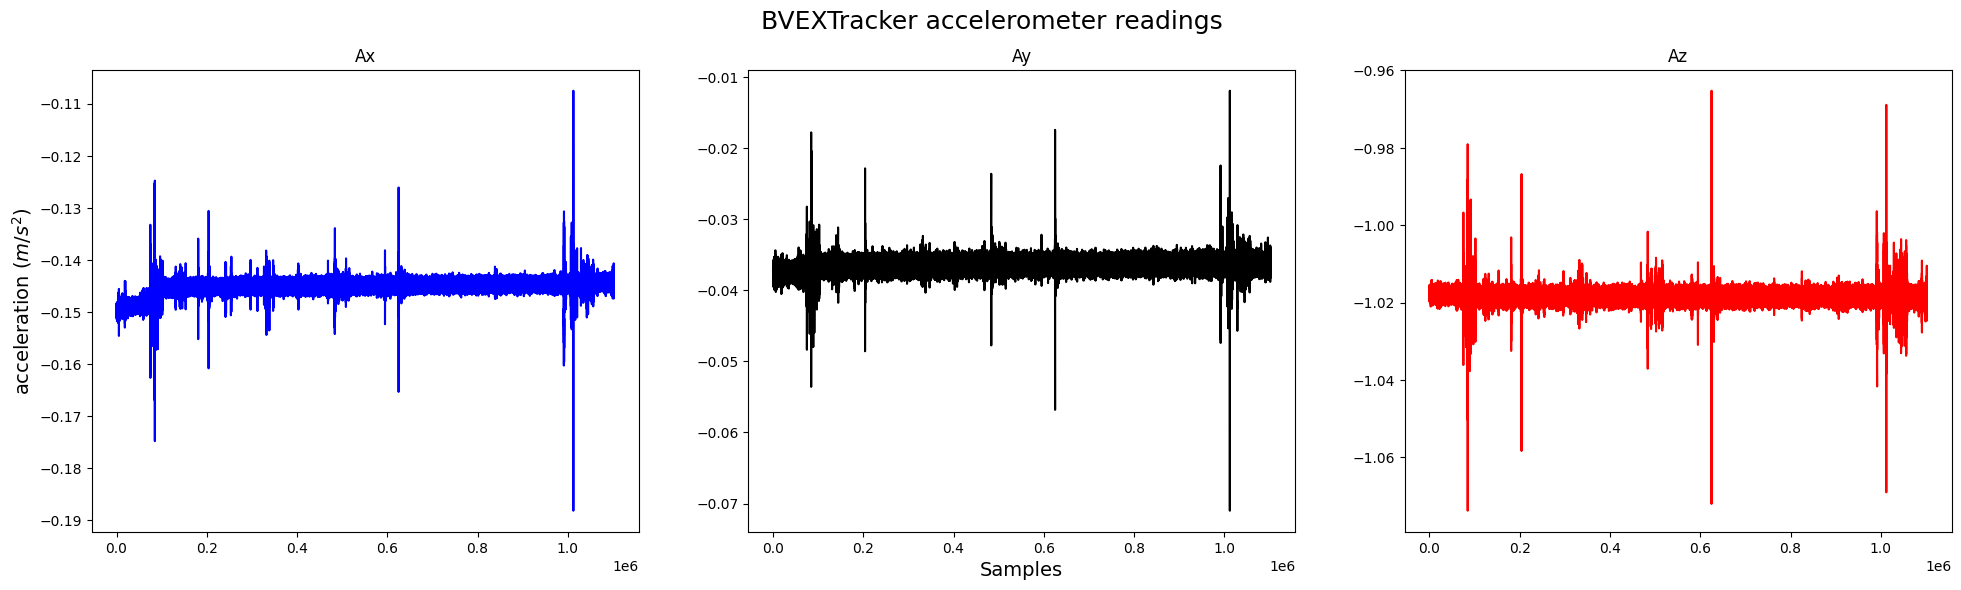

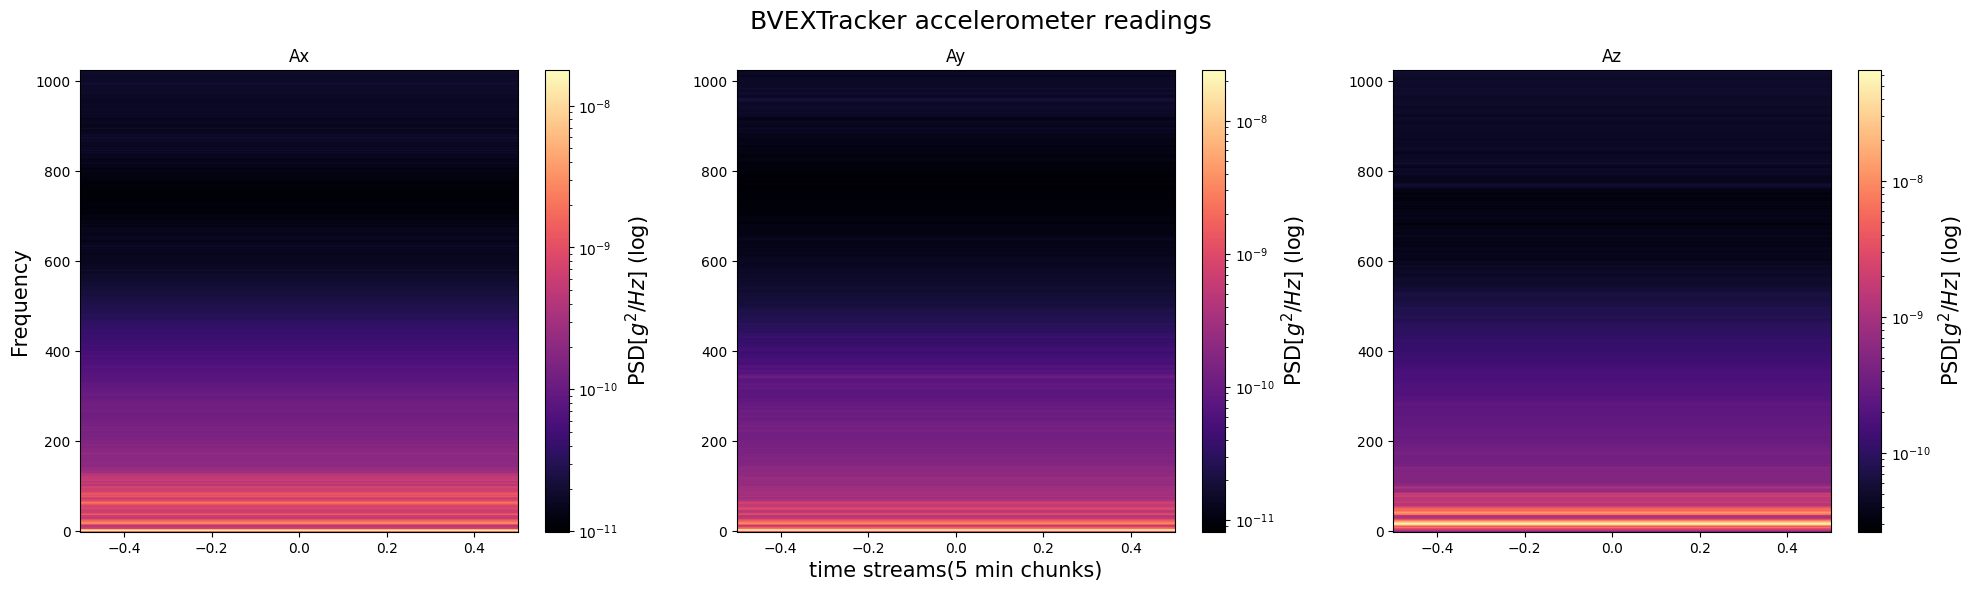

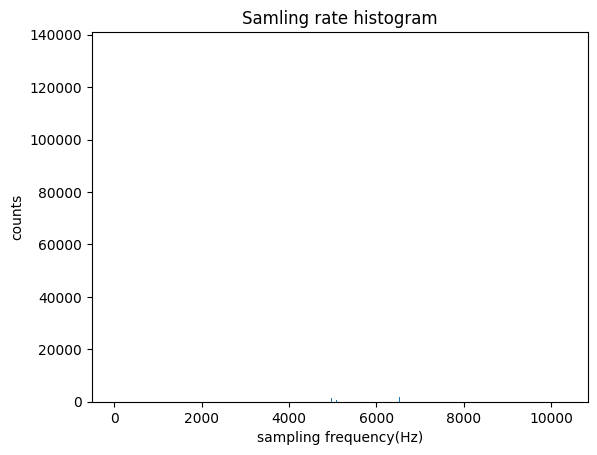

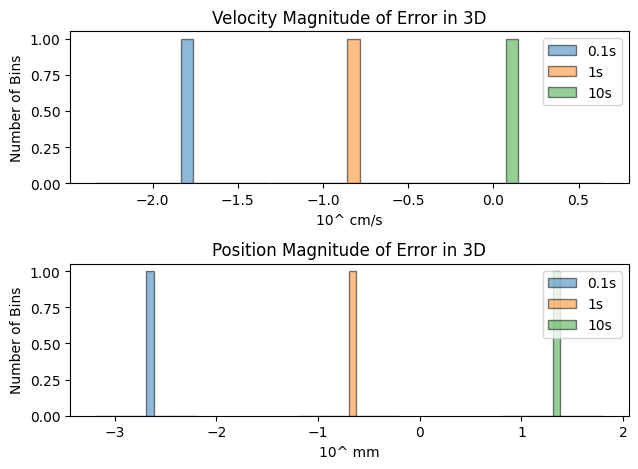

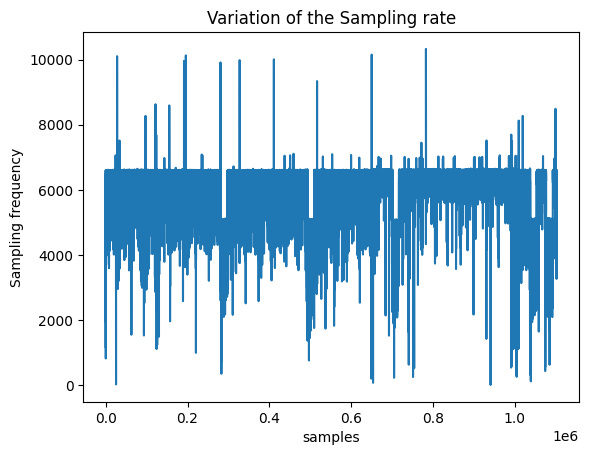

In [303]:
def get_file_names_in_folder(folder_path):
    try:
        # Get a list of all file names in the folder
        file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return file_names
    except OSError as e:
        print(f"Error: {e}")
        return []

# Replace 'folder_path' with the actual path of the folder you want to list files from
folder_path = '08-04-Acceltest_1/'
file_names_list = get_file_names_in_folder(folder_path)

if file_names_list:
    print("List of file names in the folder:")
    for file_name in file_names_list:
        print(file_name)
else:
    print("No files found in the folder.")

# file_names_list=np.array(file_names_list)

# file_names_list = file_names_list.astype(int)

# file_names_list 


axx =[]
ayy =[]
azz =[]

fsslist =[]

psdax_list =[]
psday_list=[]
psdaz_list =[]

ssdax_list =[]
ssday_list=[]
ssdaz_list =[]

fxlist =[]
fylist =[]
fzlist =[]

vxx =[]
vyy =[]
vzz =[]

dxx =[]
dyy=[]
dzz=[]

verr01 =[]
verr1 =[]
verr10 = []

derr01 =[]
derr1=[]
derr10 =[]

vstatss01 =[]
vstatss1 =[]
vstatss10 = []

dstatss01 =[]
dstatss1 =[]
dstatss10 =[]



def read_file(file):
    data = []
    while True:
        try:
            bin_dat = file.read(20)
            if not bin_dat:
                break
            raw_dat = struct.unpack("<diii", bin_dat)
            data += [struct.unpack("<diii", bin_dat)]
        except Exception as e:
            print(e)
            print("got error reading data, returned processed data")
            return data
    return data

for i in file_names_list:

    with open(folder_path+'/'+i, "rb") as f:
        temp = 0
        data = read_file(f)
        time = []
        ax = []
        ay = []
        az = []
        for line in data:
            time += [line[0]]

            ax += [line[1]*2.048 * 2 / 2**20] 
            ay += [line[2]*2.048 * 2 / 2**20] 
            az += [line[3]*2.048 * 2 / 2**20]   


    time_span = np.diff(time)
    mean_time_span = np.mean(time_span)
    fss = 1/ time_span
    mean_fss = np.mean(fss)

    print("mean dt :", mean_time_span," s")
    print("mean sampling rate :",mean_fss, "Hz")
    print("total samples",len(time))



    fs= mean_fss # Hz
    win = 2048

    fx,psdax = signal.welch(ax,fs,nperseg=win)
    fy,psday = signal.welch(ay,fs,nperseg=win)
    fz,psdaz = signal.welch(az,fs,nperseg=win)


    ax_mean = np.mean(ax)
    ay_mean = np.mean(ay)
    az_mean = np.mean(az)

    ax_avg = az - ax_mean
    ay_avg = ay - ay_mean
    az_avg = az - az_mean

    # create empty lists to put data in for 0.1s 
    vx01 = []
    vy01 = []
    vz01 = []

    dx01 = []
    dy01 = []
    dz01 = []

    # 1s
    vx1 = []
    vy1 = []
    vz1 = []

    dx1 = []
    dy1 = []
    dz1 = []

    # 10s
    vx10 = []
    vy10 = []
    vz10 = []

    dx10 = []
    dy10 = []
    dz10 = []

    t = time
    x = ax
    y = ay 
    z = az 


    t01 = np.where(t == 101)  # where t = 0.1s
    t1 = np.where(t == 1002)
    t10 = np.where(t == 10000)

    xmean = np.mean(ax)
    ymean = np.mean(ay)
    zmean = np.mean(az)

    xavg = x-xmean
    xshape = np.reshape(xavg,len(xavg))
    yavg = y-ymean
    yshape = np.reshape(yavg,len(yavg))
    zavg = z-zmean
    zshape = np.reshape(zavg,(len(zavg)))
    tshape = np.reshape(t, len(t))

    vx = np.array(1/1000 * integrate.cumtrapz(xshape, initial=1))   # integrate over 1 ms
    vy = np.array(1/1000 * integrate.cumtrapz(yshape, initial=1))
    vz = np.array(1/1000 * integrate.cumtrapz(zshape, initial=1))   # same length array as t

    dx = np.array(1/1000 * integrate.cumtrapz(vx, initial=1))
    dy = np.array(1/1000 * integrate.cumtrapz(vy, initial=1))
    dz = np.array(1/1000 * integrate.cumtrapz(vz, initial=1))  

    vx01.append(vx[32])   # list value where t=0.1
    vy01.append(vy[32])
    vz01.append(vz[32])

    dx01.append(dx[32])
    dy01.append(dy[32])
    dz01.append(dz[32])

    vx1.append(vx[297])  # where t=1
    vy1.append(vy[297])
    vz1.append(vz[297])

    dx1.append(dx[297])
    dy1.append(dy[297])
    dz1.append(dz[297])

    vx10.append(vx[2875])  # where t=10
    vy10.append(vy[2875])
    vz10.append(vz[2875])

    dx10.append(dx[2875])
    dy10.append(dy[2875])
    dz10.append(dz[2875])


    # convert to arrays
    # 0.1 s
    vxarr01 = np.array(np.abs(vx01))
    vyarr01 = np.array(np.abs(vy01))
    vzarr01 = np.array(np.abs(vz01))

    dxarr01 = np.array(np.abs(dx01))
    dyarr01 = np.array(np.abs(dy01))
    dzarr01 = np.array(np.abs(dz01))

    # 1s
    vxarr1 = np.array(np.abs(vx1))
    vyarr1 = np.array(np.abs(vy1))
    vzarr1 = np.array(np.abs(vz1))

    dxarr1 = np.array(np.abs(dx1))
    dyarr1 = np.array(np.abs(dy1))
    dzarr1 = np.array(np.abs(dz1))

    # 10 s
    vxarr10 = np.array(np.abs(vx10))
    vyarr10 = np.array(np.abs(vy10))
    vzarr10 = np.array(np.abs(vz10))

    dxarr10 = np.array(np.abs(dx10))
    dyarr10 = np.array(np.abs(dy10))
    dzarr10 = np.array(np.abs(dz10))


    # magnitude of error at 0.1s
    mag_errv01 = np.sqrt((vxarr01*100)**2 + (vyarr01*100)**2 + (vzarr01*100)**2)  # cm/s
    mag_errd01 = np.sqrt((dxarr01*1000)**2 + (dyarr01*1000)**2 + (dzarr01*1000)**2)  # mm

    # magnitude of error at 1 s
    mag_errv1 = np.sqrt((vxarr1*100)**2 + (vyarr1*100)**2 + (vzarr1*100)**2)  # cm/s
    mag_errd1 = np.sqrt((dxarr1*1000)**2 + (dyarr1*1000)**2 + (dzarr1*1000)**2)  # mm

    # magnitude of error at 10 s
    mag_errv10 = np.sqrt((vxarr10*100)**2 + (vyarr10*100)**2 + (vzarr10*100)**2)  # cm/s
    mag_errd10 = np.sqrt((dxarr10*1000)**2 + (dyarr10*1000)**2 + (dzarr10*1000)**2)  # mm


    # # log transform data to evenly distribute
    # fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

    log_verr01 = np.log10(mag_errv01)
    log_verr1 = np.log10(mag_errv1)
    log_verr10 = np.log10(mag_errv10)

    log_derr01 = np.log10(mag_errd01)
    log_derr1 = np.log10(mag_errd1)
    log_derr10 = np.log10(mag_errd10)

    
#----------------------------------------appending all dara----------------------------    
    
    fsslist.append(fss)
    
    axx.append(ax)
    ayy.append(ay)
    azz.append(az)

    psdax_list.append(psdax)
    psday_list.append(psday)
    psdaz_list.append(psdaz)
    
    # ssdax_list.append(Sxx)
    # ssday_list.append(Syy)
    # ssdaz_list.append(Szz)

    fxlist.append(fx)
    fylist.append(fy)
    fzlist.append(fy)

    vxx.append(vx)
    vyy.append(vy)
    vzz.append(vz)

    dxx.append(dx)
    dyy.append(dy)
    dzz.append(dz)

    verr01.append(log_verr01)
    verr1.append(log_verr1)
    verr10.append(log_verr10)

    derr01.append(log_derr01)
    derr1.append(log_derr1)
    derr10.append(log_derr10)

    vstatss01.append(vstats01)
    vstatss1.append(vstats1)
    vstatss10.append(vstats10)

    dstatss01.append(pstats01)
    dstatss1.append(pstats1)
    dstatss10.append(pstats10)
    
#-------------------------------------list flatenning and array mods-----------------------------    
    
def flatten_list(nested_list):
    flattened_list = []
    for item in nested_list:
        if isinstance(item, list):
            flattened_list.extend(flatten_list(item))
        else:
            flattened_list.append(item)
    return flattened_list

axx = flatten_list(axx)
ayy = flatten_list(ayy)
azz = flatten_list(azz)

#fsslist = flatten_list(fsslist)

psdax_list = np.array(psdax_list)
psday_list = np.array(psday_list)
psdaz_list = np.array(psdaz_list)

verr01= flatten_list(verr01)


def flatten_arrays_list(arrays_list):
    flattened_list = np.concatenate(arrays_list).ravel()
    return flattened_list

fsslist = flatten_arrays_list(fsslist)


verr01 = flatten_arrays_list(verr01)
verr1 = flatten_arrays_list(verr1)
verr10 = flatten_arrays_list(verr10)

derr01 = flatten_arrays_list(derr01)
derr1 = flatten_arrays_list(derr1)
derr10 = flatten_arrays_list(derr10)

#-------------------------------plotting data--------------------------------

fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker accelerometer readings',size=18)

axs[0].plot(axx,color = 'blue')
axs[0].set_title("Ax")


axs[1].plot(ayy,color = 'black')
axs[1].set_title("Ay")

axs[2].plot(azz,color = 'red')
axs[2].set_title("Az")

axs[1].set_xlabel('Samples',size=14)
axs[0].set_ylabel(r'acceleration ($m/s^2$)',size=14)


#plt.savefig("imuasd.png",dpi="figure")
plt.show()


fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker accelerometer readings',size=18)

ps1=axs[0].imshow(psdax_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[0].set_title("Ax")
cb1=fig.colorbar(ps1)
cb1.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

ps2=axs[1].imshow(psday_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[1].set_title("Ay")
cb2=fig.colorbar(ps2)
cb2.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

ps3=axs[2].imshow(psdaz_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[2].set_title("Az")
cb3=fig.colorbar(ps3)
cb3.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

axs[0].set_ylabel('Frequency',size=15)
axs[1].set_xlabel('time streams(5 min chunks)',size=15)


#plt.savefig("imuasd.png",dpi="figure")
plt.show()


plt.title("Samling rate histogram")
plt.xlabel("sampling frequency(Hz)")
plt.ylabel("counts")
plt.hist(fsslist,bins="auto")
plt.show()


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

# velocity magnitude of error
n1, bins01, patches = ax1.hist(verr01, bins=14, label='0.1s',alpha=0.5,zorder=5, histtype='bar', ec='black')
n2, bins1, patches = ax1.hist(verr1, bins=14, label='1s',alpha=0.5, histtype='bar', ec='black')
n3, bins10, patches = ax1.hist(verr10, bins=14, label='10s',alpha=0.5, histtype='bar', ec='black')
ax1.legend()
ax1.set_xscale('linear')
ax1.set_ylabel('Number of Bins')
ax1.set_title('Velocity Magnitude of Error in 3D')
ax1.set_xlabel('10^ cm/s')

nd1, binsd01, patchesd = ax2.hist(derr01, bins=14, label='0.1s',alpha=0.5, histtype='bar', ec='black')
nd2, binsd1, patchesd = ax2.hist(derr1, bins=14, label='1s',alpha=0.5, histtype='bar', ec='black')
nd3, binsd10, patchesd = ax2.hist(derr10, bins=14, label='10s',alpha=0.5, histtype='bar', ec='black')
ax2.legend()
ax2.set_xlabel('10^ mm')
ax2.set_ylabel('Number of Bins')
ax2.set_title('Position Magnitude of Error in 3D')
ax2.set_xscale('linear')

bin_centers = 0.5*(bins01[1:]+bins01[:-1])
sqrtn1 = np.sqrt(n1)

plt.tight_layout()

plt.show()

plt.title("Variation of the Sampling rate")
plt.plot(fsslist)
plt.ylabel("Sampling frequency")
plt.xlabel("samples")
plt.show()

In [295]:
fsslist

array([            inf,             inf,             inf, ...,
        5.91184528e-10, -5.91184528e-10,  5.91184528e-10])

In [296]:
1/5.5595124403416247e-11

17987188817.92

In [209]:
#plt.plot(fsslist)
len(fsslist[np.where(fsslist<500)])/len(fsslist) *100

37.497083663851434

In [211]:
len(fsslist[np.where(fsslist>795)])/len(fsslist) *100

25.43978349120433

In [198]:
fsslist[0:10]

array([80.17862058, 79.95699335, 79.98443906, 79.90368056, 79.9752884 ,
       79.97833839, 79.97223864, 79.93870666, 79.96766444, 79.94175386])

Text(0.5, 0, 'samples')

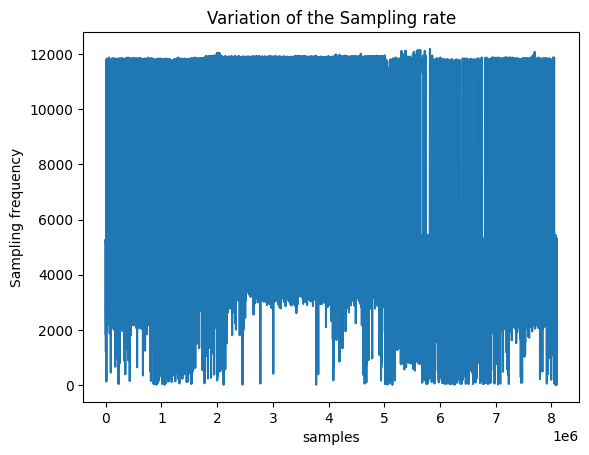

In [231]:
plt.title("Variation of the Sampling rate")
plt.plot(fsslist)
plt.ylabel("Sampling frequency")
plt.xlabel("samples")

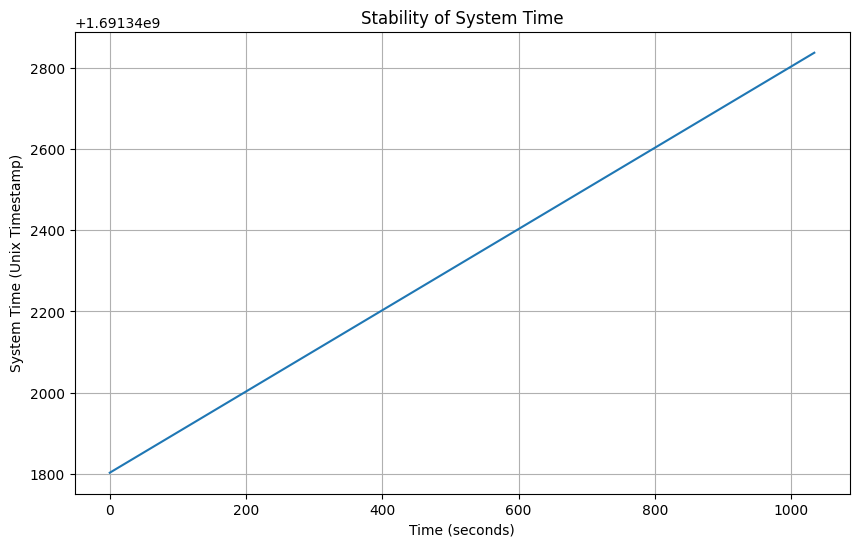

In [242]:
import os
import time
import matplotlib.pyplot as plt
from datetime import datetime

def read_log_file(log_file_path):
    timestamps = []
    with open(log_file_path, 'r') as log_file:
        for line in log_file:
            timestamp_str = line.strip()
            try:
                timestamp = datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S')
                timestamps.append(timestamp)
            except ValueError:
                print(f"Invalid timestamp format: {timestamp_str}")
    return timestamps

def plot_system_time_stability(timestamps):
    time_deltas = [(t - timestamps[0]).total_seconds() for t in timestamps]

    plt.figure(figsize=(10, 6))
    plt.plot(time_deltas, [t.timestamp() for t in timestamps])
    plt.xlabel('Time (seconds)')
    plt.ylabel('System Time (Unix Timestamp)')
    plt.title('Stability of System Time')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    # Replace 'system_time_log.txt' with your log file path
    log_file_path = "system_time_log.txt"

    try:
        timestamps = read_log_file(log_file_path)
        if timestamps:
            plot_system_time_stability(timestamps)
        else:
            print("No valid timestamps found in the log file.")
    except FileNotFoundError:
        print(f"Log file not found: {log_file_path}")


(array([87., 86., 85., 86., 86., 86., 87., 86., 86., 86., 85., 87.]),
 array([1.69134180e+09, 1.69134189e+09, 1.69134198e+09, 1.69134206e+09,
        1.69134215e+09, 1.69134223e+09, 1.69134232e+09, 1.69134241e+09,
        1.69134249e+09, 1.69134258e+09, 1.69134266e+09, 1.69134275e+09,
        1.69134284e+09]),
 <BarContainer object of 12 artists>)

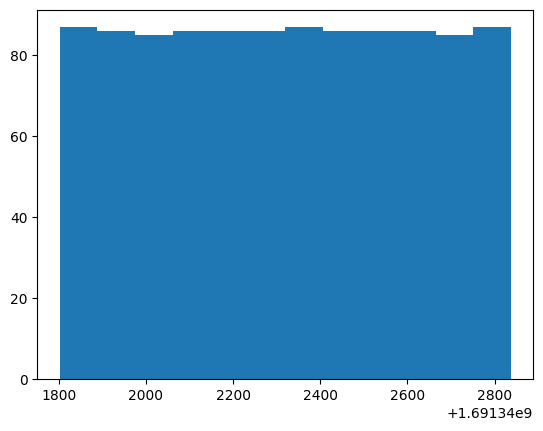

In [248]:
time=[t.timestamp() for t in timestamps]
plt.hist(time,bins="auto")

In [280]:
gpsdata = pd.read_csv("gps_log.txt")
timedata = gpsdata.Time
lat = gpsdata.Latitude
lon = gpsdata.Longitude

In [290]:
timedata[10]-timedata[9]

1.0

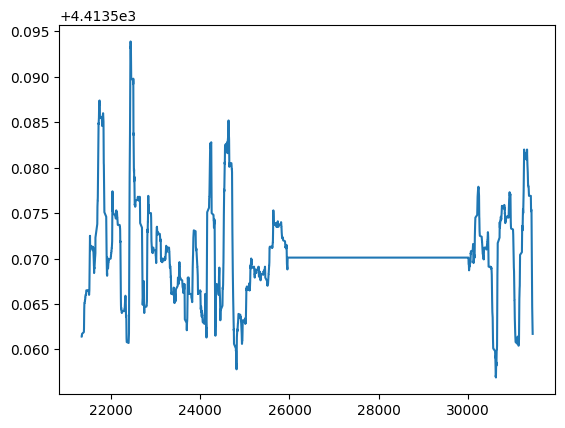

In [278]:
plt.plot(timedata,lat)

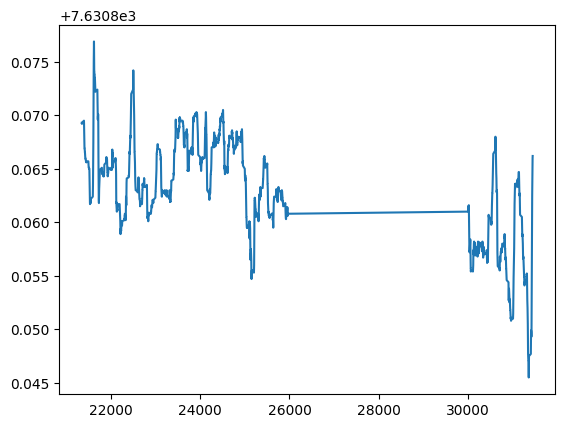

In [279]:
plt.plot(timedata,lon)

### Accelerometer(with zeros)

List of file names in the folder:
1691519233
1691518632
1691518933
unpack requires a buffer of 20 bytes
got error reading data, returned processed data
mean dt : 0.0007978632723302395  s
mean sampling rate : 1266.5316939733514 Hz
total samples 134867


/var/folders/8g/zw9cjxxx2hz2444l1w_17w640000gn/T/ipykernel_52399/3958938939.py:174: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  t01 = np.where(t == 101)  # where t = 0.1s
/var/folders/8g/zw9cjxxx2hz2444l1w_17w640000gn/T/ipykernel_52399/3958938939.py:175: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  t1 = np.where(t == 1002)
/var/folders/8g/zw9cjxxx2hz2444l1w_17w640000gn/T/ipykernel_52399/3958938939.py:176: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of t

mean dt : 0.0009088951046355039  s
mean sampling rate : 1164.384084136208 Hz
total samples 330686
mean dt : 0.0008396743969549253  s
mean sampling rate : 1232.480229144231 Hz
total samples 357689


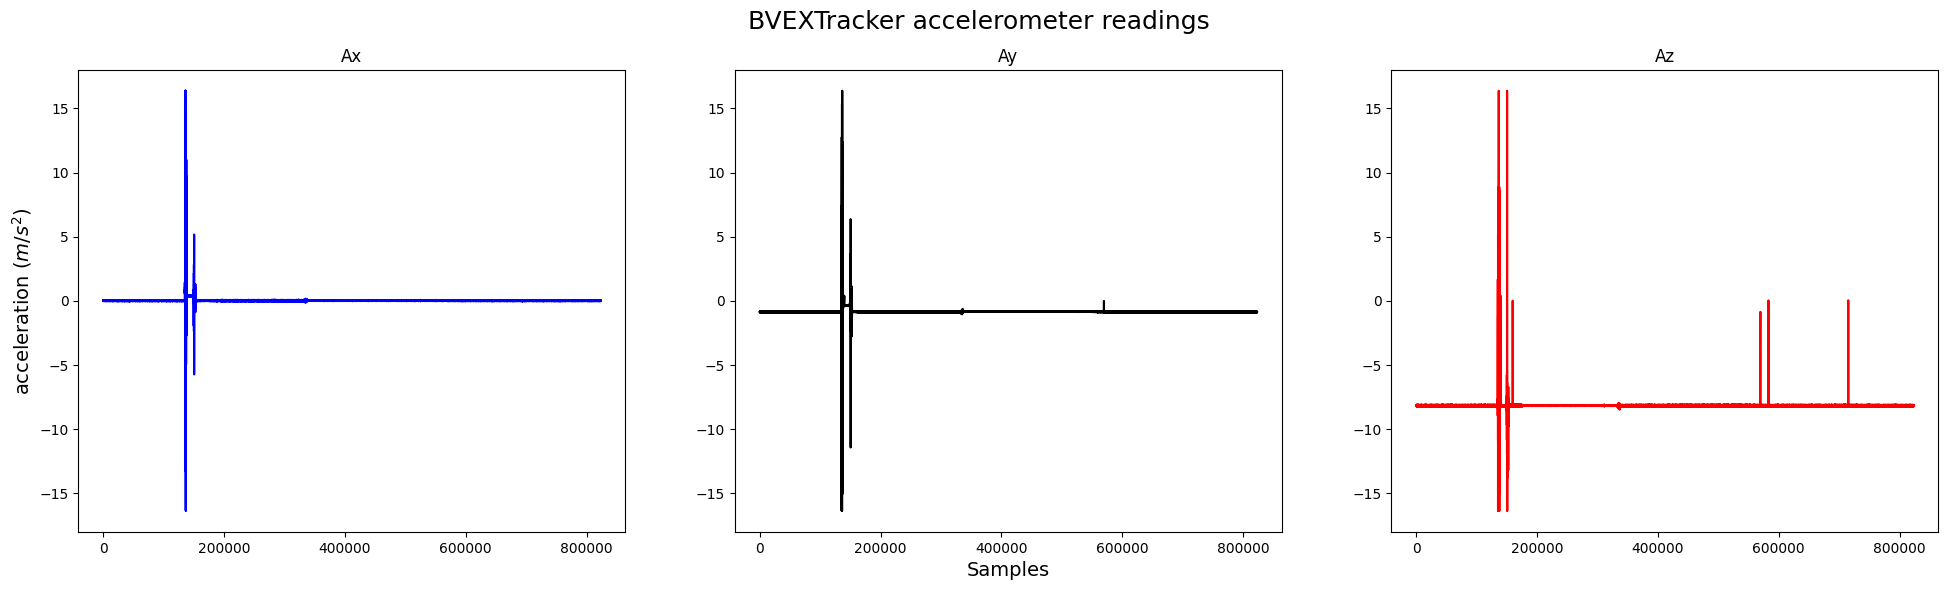

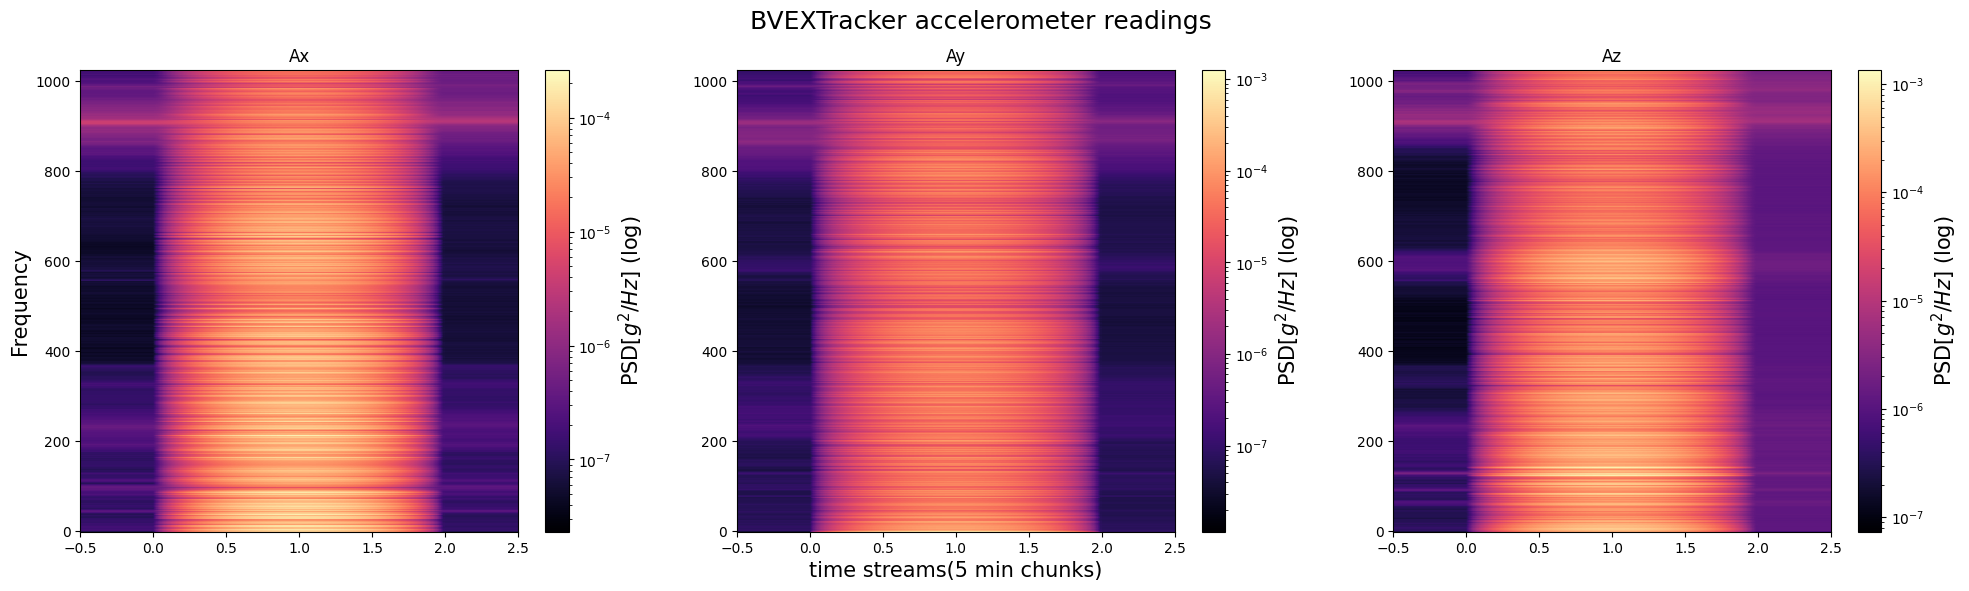

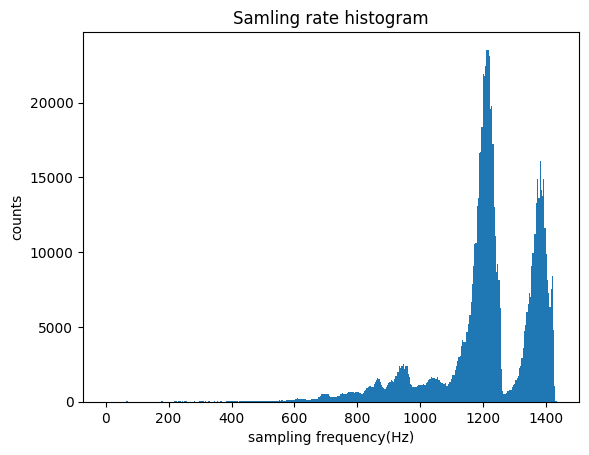

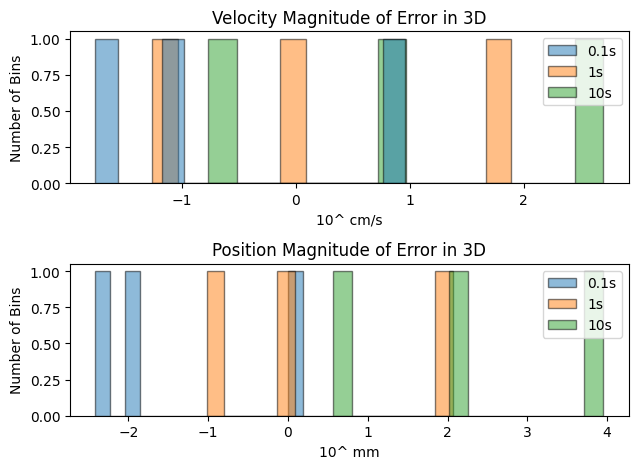

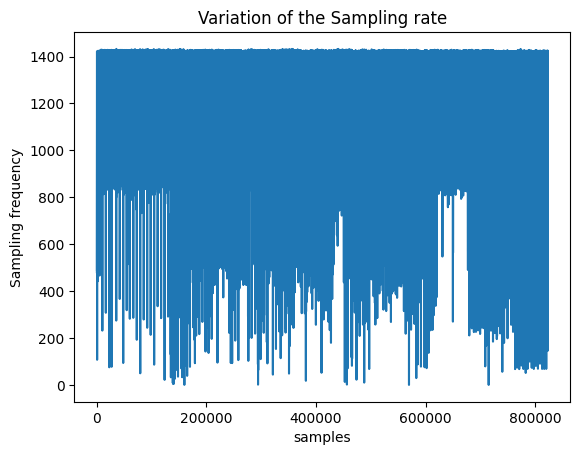

58.91476973458219 % of data has zero as it's time


In [352]:
def get_file_names_in_folder(folder_path):
    try:
        # Get a list of all file names in the folder
        file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return file_names
    except OSError as e:
        print(f"Error: {e}")
        return []

# Replace 'folder_path' with the actual path of the folder you want to list files from
folder_path = '08-08-output_1/Accelerometer/'
file_names_list = get_file_names_in_folder(folder_path)

if file_names_list:
    print("List of file names in the folder:")
    for file_name in file_names_list:
        print(file_name)
else:
    print("No files found in the folder.")

# file_names_list=np.array(file_names_list)

# file_names_list = file_names_list.astype(int)

# file_names_list 


axx =[]
ayy =[]
azz =[]

axalllist=[]

fsslist =[]
tlist=[]
timealllist=[]

psdax_list =[]
psday_list=[]
psdaz_list =[]

ssdax_list =[]
ssday_list=[]
ssdaz_list =[]

fxlist =[]
fylist =[]
fzlist =[]

vxx =[]
vyy =[]
vzz =[]

dxx =[]
dyy=[]
dzz=[]

verr01 =[]
verr1 =[]
verr10 = []

derr01 =[]
derr1=[]
derr10 =[]

vstatss01 =[]
vstatss1 =[]
vstatss10 = []

dstatss01 =[]
dstatss1 =[]
dstatss10 =[]



def read_file(file):
    data = []
    while True:
        try:
            bin_dat = file.read(20)
            if not bin_dat:
                break
            raw_dat = struct.unpack("<diii", bin_dat)
            data += [struct.unpack("<diii", bin_dat)]
        except Exception as e:
            print(e)
            print("got error reading data, returned processed data")
            return data
    return data

for i in file_names_list:

    with open(folder_path+'/'+i, "rb") as f:
        
        temp = 0
        data = read_file(f)
        time = []
        timeall =[]
        axall=[]
        ax = []
        ay = []
        az = []
        for line in data:
            timeall += [line[0]]
            axall += [line[1]*16.384 * 2 / 2**20] 
            if line[0] !=0:
                time += [line[0]]

                ax += [line[1]*16.384 * 2 / 2**20] 
                ay += [line[2]*16.384 * 2 / 2**20] 
                az += [line[3]*16.384 * 2 / 2**20]   


    time_span = np.diff(time)
    mean_time_span = np.mean(time_span)
    fss = 1/ time_span
    mean_fss = np.mean(fss)

    print("mean dt :", mean_time_span," s")
    print("mean sampling rate :",mean_fss, "Hz")
    print("total samples",len(time))



    fs= mean_fss # Hz
    win = 2048

    fx,psdax = signal.welch(ax,fs,nperseg=win)
    fy,psday = signal.welch(ay,fs,nperseg=win)
    fz,psdaz = signal.welch(az,fs,nperseg=win)


    ax_mean = np.mean(ax)
    ay_mean = np.mean(ay)
    az_mean = np.mean(az)

    ax_avg = az - ax_mean
    ay_avg = ay - ay_mean
    az_avg = az - az_mean

    # create empty lists to put data in for 0.1s 
    vx01 = []
    vy01 = []
    vz01 = []

    dx01 = []
    dy01 = []
    dz01 = []

    # 1s
    vx1 = []
    vy1 = []
    vz1 = []

    dx1 = []
    dy1 = []
    dz1 = []

    # 10s
    vx10 = []
    vy10 = []
    vz10 = []

    dx10 = []
    dy10 = []
    dz10 = []

    t = time
    x = ax
    y = ay 
    z = az 


    t01 = np.where(t == 101)  # where t = 0.1s
    t1 = np.where(t == 1002)
    t10 = np.where(t == 10000)

    xmean = np.mean(ax)
    ymean = np.mean(ay)
    zmean = np.mean(az)

    xavg = x-xmean
    xshape = np.reshape(xavg,len(xavg))
    yavg = y-ymean
    yshape = np.reshape(yavg,len(yavg))
    zavg = z-zmean
    zshape = np.reshape(zavg,(len(zavg)))
    tshape = np.reshape(t, len(t))

    vx = np.array(1/1000 * integrate.cumtrapz(xshape, initial=1))   # integrate over 1 ms
    vy = np.array(1/1000 * integrate.cumtrapz(yshape, initial=1))
    vz = np.array(1/1000 * integrate.cumtrapz(zshape, initial=1))   # same length array as t

    dx = np.array(1/1000 * integrate.cumtrapz(vx, initial=1))
    dy = np.array(1/1000 * integrate.cumtrapz(vy, initial=1))
    dz = np.array(1/1000 * integrate.cumtrapz(vz, initial=1))  

    vx01.append(vx[32])   # list value where t=0.1
    vy01.append(vy[32])
    vz01.append(vz[32])

    dx01.append(dx[32])
    dy01.append(dy[32])
    dz01.append(dz[32])

    vx1.append(vx[297])  # where t=1
    vy1.append(vy[297])
    vz1.append(vz[297])

    dx1.append(dx[297])
    dy1.append(dy[297])
    dz1.append(dz[297])

    vx10.append(vx[2875])  # where t=10
    vy10.append(vy[2875])
    vz10.append(vz[2875])

    dx10.append(dx[2875])
    dy10.append(dy[2875])
    dz10.append(dz[2875])


    # convert to arrays
    # 0.1 s
    vxarr01 = np.array(np.abs(vx01))
    vyarr01 = np.array(np.abs(vy01))
    vzarr01 = np.array(np.abs(vz01))

    dxarr01 = np.array(np.abs(dx01))
    dyarr01 = np.array(np.abs(dy01))
    dzarr01 = np.array(np.abs(dz01))

    # 1s
    vxarr1 = np.array(np.abs(vx1))
    vyarr1 = np.array(np.abs(vy1))
    vzarr1 = np.array(np.abs(vz1))

    dxarr1 = np.array(np.abs(dx1))
    dyarr1 = np.array(np.abs(dy1))
    dzarr1 = np.array(np.abs(dz1))

    # 10 s
    vxarr10 = np.array(np.abs(vx10))
    vyarr10 = np.array(np.abs(vy10))
    vzarr10 = np.array(np.abs(vz10))

    dxarr10 = np.array(np.abs(dx10))
    dyarr10 = np.array(np.abs(dy10))
    dzarr10 = np.array(np.abs(dz10))


    # magnitude of error at 0.1s
    mag_errv01 = np.sqrt((vxarr01*100)**2 + (vyarr01*100)**2 + (vzarr01*100)**2)  # cm/s
    mag_errd01 = np.sqrt((dxarr01*1000)**2 + (dyarr01*1000)**2 + (dzarr01*1000)**2)  # mm

    # magnitude of error at 1 s
    mag_errv1 = np.sqrt((vxarr1*100)**2 + (vyarr1*100)**2 + (vzarr1*100)**2)  # cm/s
    mag_errd1 = np.sqrt((dxarr1*1000)**2 + (dyarr1*1000)**2 + (dzarr1*1000)**2)  # mm

    # magnitude of error at 10 s
    mag_errv10 = np.sqrt((vxarr10*100)**2 + (vyarr10*100)**2 + (vzarr10*100)**2)  # cm/s
    mag_errd10 = np.sqrt((dxarr10*1000)**2 + (dyarr10*1000)**2 + (dzarr10*1000)**2)  # mm


    # # log transform data to evenly distribute
    # fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

    log_verr01 = np.log10(mag_errv01)
    log_verr1 = np.log10(mag_errv1)
    log_verr10 = np.log10(mag_errv10)

    log_derr01 = np.log10(mag_errd01)
    log_derr1 = np.log10(mag_errd1)
    log_derr10 = np.log10(mag_errd10)

    
# #----------------------------------------appending all dara----------------------------    
    
    fsslist.append(fss)
    
    axx.append(ax)
    ayy.append(ay)
    azz.append(az)
    tlist.append(time)
    timealllist.append(timeall)
    
    axalllist.append(axall)

    psdax_list.append(psdax)
    psday_list.append(psday)
    psdaz_list.append(psdaz)
    
    # ssdax_list.append(Sxx)
    # ssday_list.append(Syy)
    # ssdaz_list.append(Szz)

    fxlist.append(fx)
    fylist.append(fy)
    fzlist.append(fy)

    vxx.append(vx)
    vyy.append(vy)
    vzz.append(vz)

    dxx.append(dx)
    dyy.append(dy)
    dzz.append(dz)

    verr01.append(log_verr01)
    verr1.append(log_verr1)
    verr10.append(log_verr10)

    derr01.append(log_derr01)
    derr1.append(log_derr1)
    derr10.append(log_derr10)

    vstatss01.append(vstats01)
    vstatss1.append(vstats1)
    vstatss10.append(vstats10)

    dstatss01.append(pstats01)
    dstatss1.append(pstats1)
    dstatss10.append(pstats10)
    
#-------------------------------------list flatenning and array mods-----------------------------    
    
def flatten_list(nested_list):
    flattened_list = []
    for item in nested_list:
        if isinstance(item, list):
            flattened_list.extend(flatten_list(item))
        else:
            flattened_list.append(item)
    return flattened_list

axx = flatten_list(axx)
ayy = flatten_list(ayy)
azz = flatten_list(azz)

#fsslist = flatten_list(fsslist)

psdax_list = np.array(psdax_list)
psday_list = np.array(psday_list)
psdaz_list = np.array(psdaz_list)

verr01= flatten_list(verr01)


def flatten_arrays_list(arrays_list):
    flattened_list = np.concatenate(arrays_list).ravel()
    return flattened_list

fsslist = flatten_arrays_list(fsslist)
timealllist= flatten_arrays_list(timealllist)
tlist = flatten_arrays_list(tlist)

axalllist = flatten_arrays_list(axalllist)


verr01 = flatten_arrays_list(verr01)
verr1 = flatten_arrays_list(verr1)
verr10 = flatten_arrays_list(verr10)

derr01 = flatten_arrays_list(derr01)
derr1 = flatten_arrays_list(derr1)
derr10 = flatten_arrays_list(derr10)

#-------------------------------plotting data--------------------------------

fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker accelerometer readings',size=18)

axs[0].plot(axx,color = 'blue')
axs[0].set_title("Ax")


axs[1].plot(ayy,color = 'black')
axs[1].set_title("Ay")

axs[2].plot(azz,color = 'red')
axs[2].set_title("Az")

axs[1].set_xlabel('Samples',size=14)
axs[0].set_ylabel(r'acceleration ($m/s^2$)',size=14)


#plt.savefig("imuasd.png",dpi="figure")
plt.show()


fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker accelerometer readings',size=18)

ps1=axs[0].imshow(psdax_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[0].set_title("Ax")
cb1=fig.colorbar(ps1)
cb1.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

ps2=axs[1].imshow(psday_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[1].set_title("Ay")
cb2=fig.colorbar(ps2)
cb2.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

ps3=axs[2].imshow(psdaz_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[2].set_title("Az")
cb3=fig.colorbar(ps3)
cb3.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

axs[0].set_ylabel('Frequency',size=15)
axs[1].set_xlabel('time streams(5 min chunks)',size=15)


#plt.savefig("imuasd.png",dpi="figure")
plt.show()


plt.title("Samling rate histogram")
plt.xlabel("sampling frequency(Hz)")
plt.ylabel("counts")
plt.hist(fsslist,bins="auto")
plt.show()


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

# velocity magnitude of error
n1, bins01, patches = ax1.hist(verr01, bins=14, label='0.1s',alpha=0.5,zorder=5, histtype='bar', ec='black')
n2, bins1, patches = ax1.hist(verr1, bins=14, label='1s',alpha=0.5, histtype='bar', ec='black')
n3, bins10, patches = ax1.hist(verr10, bins=14, label='10s',alpha=0.5, histtype='bar', ec='black')
ax1.legend()
ax1.set_xscale('linear')
ax1.set_ylabel('Number of Bins')
ax1.set_title('Velocity Magnitude of Error in 3D')
ax1.set_xlabel('10^ cm/s')

nd1, binsd01, patchesd = ax2.hist(derr01, bins=14, label='0.1s',alpha=0.5, histtype='bar', ec='black')
nd2, binsd1, patchesd = ax2.hist(derr1, bins=14, label='1s',alpha=0.5, histtype='bar', ec='black')
nd3, binsd10, patchesd = ax2.hist(derr10, bins=14, label='10s',alpha=0.5, histtype='bar', ec='black')
ax2.legend()
ax2.set_xlabel('10^ mm')
ax2.set_ylabel('Number of Bins')
ax2.set_title('Position Magnitude of Error in 3D')
ax2.set_xscale('linear')

bin_centers = 0.5*(bins01[1:]+bins01[:-1])
sqrtn1 = np.sqrt(n1)

plt.tight_layout()

plt.show()

plt.title("Variation of the Sampling rate")
plt.plot(fsslist)
plt.ylabel("Sampling frequency")
plt.xlabel("samples")
plt.show()

print(len(tlist)/len(timealllist) *100,"% of data has zero as it's time")

In [361]:
timealllist[4]

1691519233.9092064

In [360]:
timealllist[0:100]

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.69151923e+09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       1.69151923e+09, 0.00000000e+00, 1.69151923e+09, 0.00000000e+00,
       1.69151923e+09, 0.00000000e+00, 0.00000000e+00, 1.69151923e+09,
       0.00000000e+00, 0.00000000e+00, 1.69151923e+09, 0.00000000e+00,
       0.00000000e+00, 1.69151923e+09, 0.00000000e+00, 1.69151923e+09,
       0.00000000e+00, 0.00000000e+00, 1.69151923e+09, 0.00000000e+00,
       1.69151923e+09, 0.00000000e+00, 1.69151923e+09, 1.69151923e+09,
       0.00000000e+00, 1.69151923e+09, 0.00000000e+00, 0.00000000e+00,
       1.69151923e+09, 0.00000000e+00, 1.69151923e+09, 0.00000000e+00,
       1.69151923e+09, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.69151923e+09, 0.00000000e+00, 0.00000000e+00,
       1.69151923e+09, 0.00000000e+00, 1.69151923e+09, 1.69151923e+09,
       0.00000000e+00, 1.69151923e+09, 0.00000000e+00, 1.69151923e+09,
      

List of file names in the folder:
1691706579
1691706854
1691707155
mean dt : 0.0019155284507049522  s
mean sampling rate : 789.6209253615328 Hz
total samples 92898


/var/folders/8g/zw9cjxxx2hz2444l1w_17w640000gn/T/ipykernel_52399/973893699.py:178: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  t01 = np.where(t == 101)  # where t = 0.1s
/var/folders/8g/zw9cjxxx2hz2444l1w_17w640000gn/T/ipykernel_52399/973893699.py:179: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  t1 = np.where(t == 1002)
/var/folders/8g/zw9cjxxx2hz2444l1w_17w640000gn/T/ipykernel_52399/973893699.py:180: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this

mean dt : 0.0010487797624501968  s
mean sampling rate : 1076.6063240137464 Hz
total samples 286443
mean dt : 0.0010363472250431492  s
mean sampling rate : 1082.7480157842613 Hz
total samples 137065


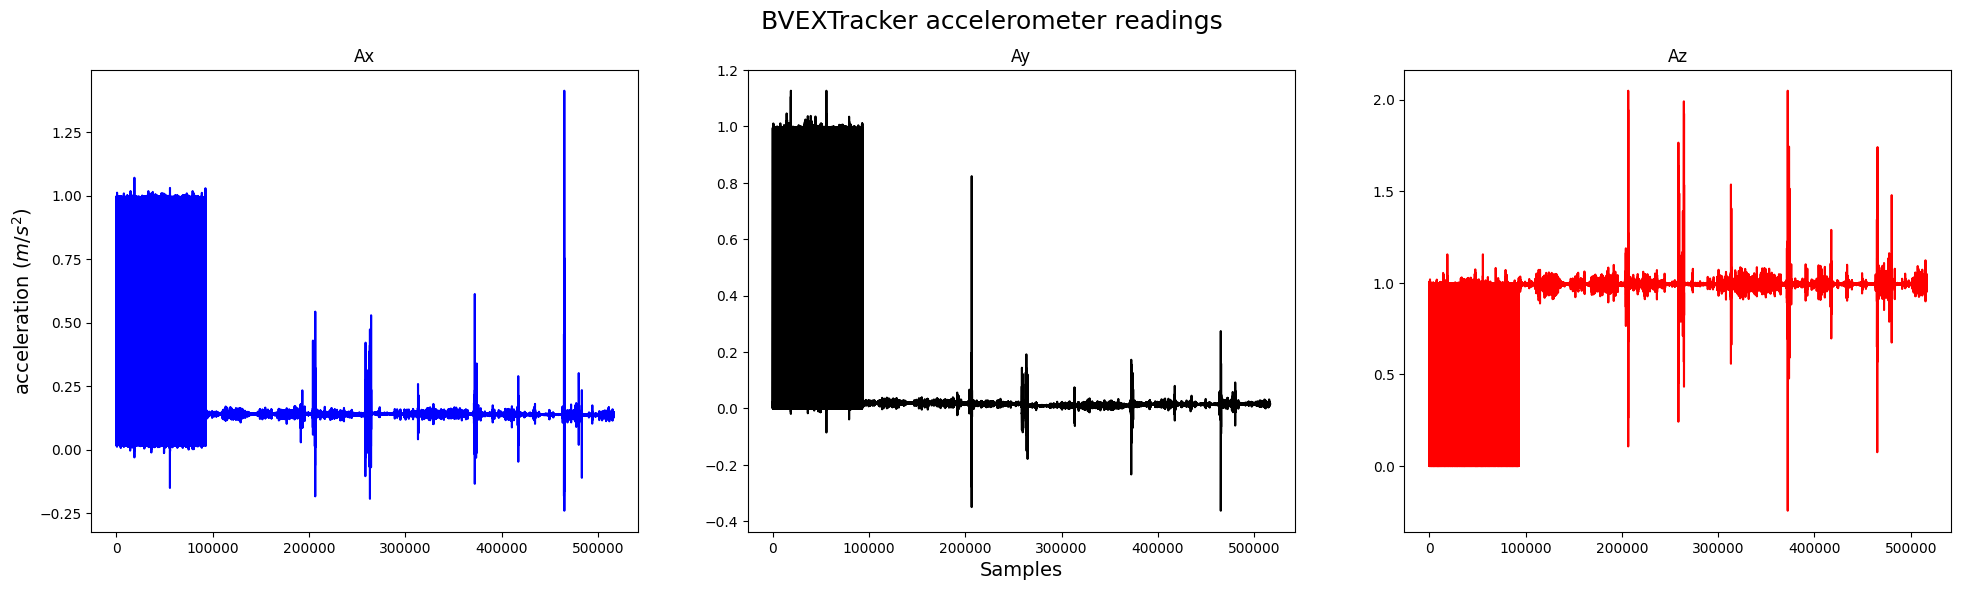

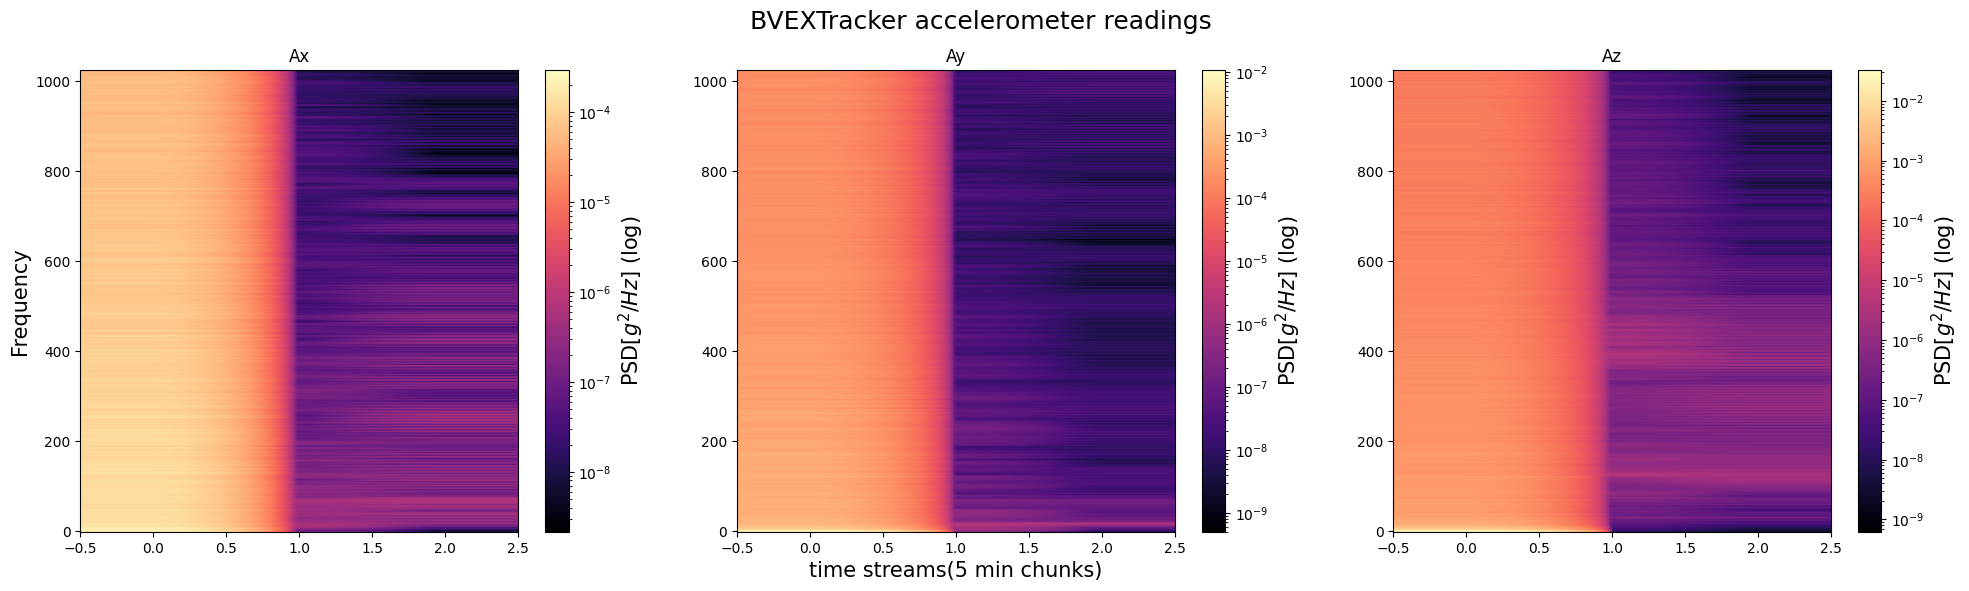

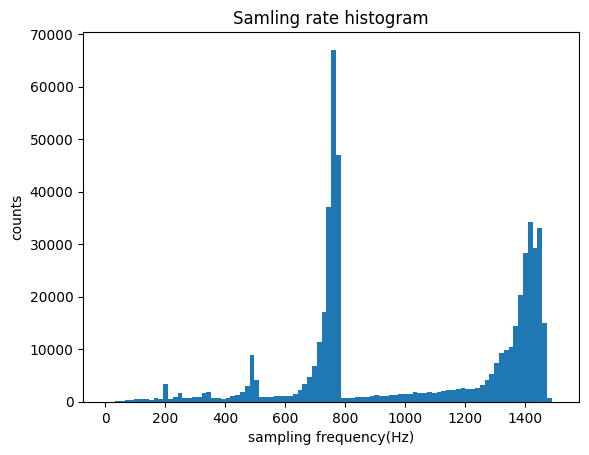

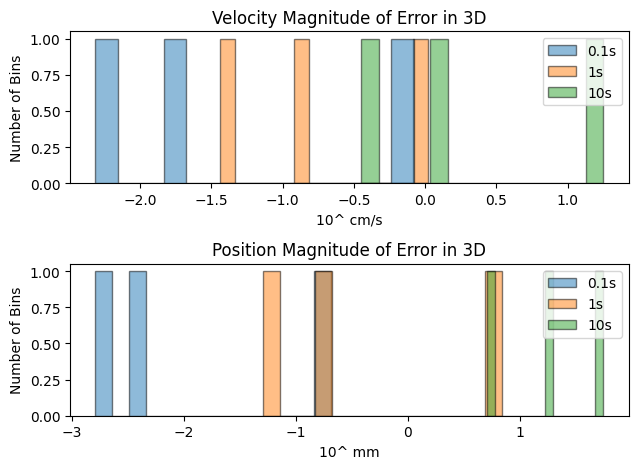

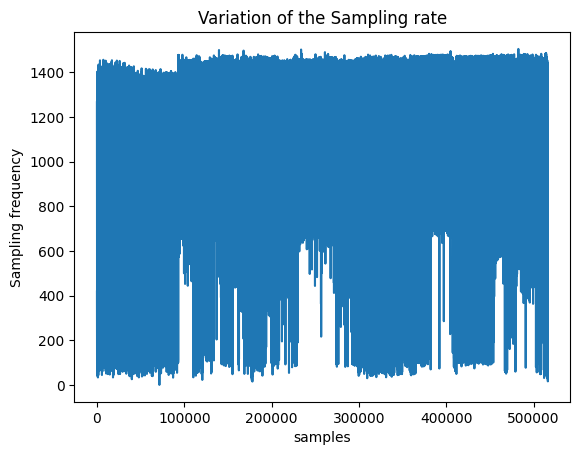

96.52322306063286 % of data does not have zero as its time


In [459]:
def get_file_names_in_folder(folder_path):
    try:
        # Get a list of all file names in the folder
        file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return file_names
    except OSError as e:
        print(f"Error: {e}")
        return []

# Replace 'folder_path' with the actual path of the folder you want to list files from
folder_path = 'output_11_1/Accelerometer'
file_names_list = get_file_names_in_folder(folder_path)

if file_names_list:
    print("List of file names in the folder:")
    for file_name in file_names_list:
        print(file_name)
else:
    print("No files found in the folder.")

# file_names_list=np.array(file_names_list)

# file_names_list = file_names_list.astype(int)

# file_names_list 


axx =[]
ayy =[]
azz =[]

axalllist=[]

fsslist =[]
tlist=[]
timealllist=[]
timezerodatalist=[]

psdax_list =[]
psday_list=[]
psdaz_list =[]

ssdax_list =[]
ssday_list=[]
ssdaz_list =[]

fxlist =[]
fylist =[]
fzlist =[]

vxx =[]
vyy =[]
vzz =[]

dxx =[]
dyy=[]
dzz=[]

verr01 =[]
verr1 =[]
verr10 = []

derr01 =[]
derr1=[]
derr10 =[]

vstatss01 =[]
vstatss1 =[]
vstatss10 = []

dstatss01 =[]
dstatss1 =[]
dstatss10 =[]



def read_file(file):
    data = []
    while True:
        try:
            bin_dat = file.read(20)
            if not bin_dat:
                break
            raw_dat = struct.unpack("<diii", bin_dat)
            data += [struct.unpack("<diii", bin_dat)]
        except Exception as e:
            print(e)
            print("got error reading data, returned processed data")
            return data
    return data

for i in file_names_list:

    with open(folder_path+'/'+i, "rb") as f:
        
        temp = 0
        data = read_file(f)
        time = []
        timezerodata=[]
        timeall =[]
        axall=[]
        ax = []
        ay = []
        az = []
        for line in data:
            timeall += [line[0]]
            axall += [line[1]*2.048 * 2 / 2**20] 
            if line[0] !=0:
                time += [line[0]]

                ax += [line[1]*2.048 * 2 / 2**20] 
                ay += [line[2]*2.048 * 2 / 2**20] 
                az += [line[3]*2.048 * 2 / 2**20]  
            else:
                timezerodata +=[line[0]]


    time_span = np.diff(time)
    mean_time_span = np.mean(time_span)
    fss = 1/ time_span
    mean_fss = np.mean(fss)

    print("mean dt :", mean_time_span," s")
    print("mean sampling rate :",mean_fss, "Hz")
    print("total samples",len(time))



    fs= mean_fss # Hz
    win = 2048

    fx,psdax = signal.welch(ax,fs,nperseg=win)
    fy,psday = signal.welch(ay,fs,nperseg=win)
    fz,psdaz = signal.welch(az,fs,nperseg=win)


    ax_mean = np.mean(ax)
    ay_mean = np.mean(ay)
    az_mean = np.mean(az)

    ax_avg = az - ax_mean
    ay_avg = ay - ay_mean
    az_avg = az - az_mean

    # create empty lists to put data in for 0.1s 
    vx01 = []
    vy01 = []
    vz01 = []

    dx01 = []
    dy01 = []
    dz01 = []

    # 1s
    vx1 = []
    vy1 = []
    vz1 = []

    dx1 = []
    dy1 = []
    dz1 = []

    # 10s
    vx10 = []
    vy10 = []
    vz10 = []

    dx10 = []
    dy10 = []
    dz10 = []

    t = time
    x = ax
    y = ay 
    z = az 


    t01 = np.where(t == 101)  # where t = 0.1s
    t1 = np.where(t == 1002)
    t10 = np.where(t == 10000)

    xmean = np.mean(ax)
    ymean = np.mean(ay)
    zmean = np.mean(az)

    xavg = x-xmean
    xshape = np.reshape(xavg,len(xavg))
    yavg = y-ymean
    yshape = np.reshape(yavg,len(yavg))
    zavg = z-zmean
    zshape = np.reshape(zavg,(len(zavg)))
    tshape = np.reshape(t, len(t))

    vx = np.array(1/1000 * integrate.cumtrapz(xshape, initial=1))   # integrate over 1 ms
    vy = np.array(1/1000 * integrate.cumtrapz(yshape, initial=1))
    vz = np.array(1/1000 * integrate.cumtrapz(zshape, initial=1))   # same length array as t

    dx = np.array(1/1000 * integrate.cumtrapz(vx, initial=1))
    dy = np.array(1/1000 * integrate.cumtrapz(vy, initial=1))
    dz = np.array(1/1000 * integrate.cumtrapz(vz, initial=1))  

    vx01.append(vx[32])   # list value where t=0.1
    vy01.append(vy[32])
    vz01.append(vz[32])

    dx01.append(dx[32])
    dy01.append(dy[32])
    dz01.append(dz[32])

    vx1.append(vx[297])  # where t=1
    vy1.append(vy[297])
    vz1.append(vz[297])

    dx1.append(dx[297])
    dy1.append(dy[297])
    dz1.append(dz[297])

    vx10.append(vx[2875])  # where t=10
    vy10.append(vy[2875])
    vz10.append(vz[2875])

    dx10.append(dx[2875])
    dy10.append(dy[2875])
    dz10.append(dz[2875])


    # convert to arrays
    # 0.1 s
    vxarr01 = np.array(np.abs(vx01))
    vyarr01 = np.array(np.abs(vy01))
    vzarr01 = np.array(np.abs(vz01))

    dxarr01 = np.array(np.abs(dx01))
    dyarr01 = np.array(np.abs(dy01))
    dzarr01 = np.array(np.abs(dz01))

    # 1s
    vxarr1 = np.array(np.abs(vx1))
    vyarr1 = np.array(np.abs(vy1))
    vzarr1 = np.array(np.abs(vz1))

    dxarr1 = np.array(np.abs(dx1))
    dyarr1 = np.array(np.abs(dy1))
    dzarr1 = np.array(np.abs(dz1))

    # 10 s
    vxarr10 = np.array(np.abs(vx10))
    vyarr10 = np.array(np.abs(vy10))
    vzarr10 = np.array(np.abs(vz10))

    dxarr10 = np.array(np.abs(dx10))
    dyarr10 = np.array(np.abs(dy10))
    dzarr10 = np.array(np.abs(dz10))


    # magnitude of error at 0.1s
    mag_errv01 = np.sqrt((vxarr01*100)**2 + (vyarr01*100)**2 + (vzarr01*100)**2)  # cm/s
    mag_errd01 = np.sqrt((dxarr01*1000)**2 + (dyarr01*1000)**2 + (dzarr01*1000)**2)  # mm

    # magnitude of error at 1 s
    mag_errv1 = np.sqrt((vxarr1*100)**2 + (vyarr1*100)**2 + (vzarr1*100)**2)  # cm/s
    mag_errd1 = np.sqrt((dxarr1*1000)**2 + (dyarr1*1000)**2 + (dzarr1*1000)**2)  # mm

    # magnitude of error at 10 s
    mag_errv10 = np.sqrt((vxarr10*100)**2 + (vyarr10*100)**2 + (vzarr10*100)**2)  # cm/s
    mag_errd10 = np.sqrt((dxarr10*1000)**2 + (dyarr10*1000)**2 + (dzarr10*1000)**2)  # mm


    # # log transform data to evenly distribute
    # fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

    log_verr01 = np.log10(mag_errv01)
    log_verr1 = np.log10(mag_errv1)
    log_verr10 = np.log10(mag_errv10)

    log_derr01 = np.log10(mag_errd01)
    log_derr1 = np.log10(mag_errd1)
    log_derr10 = np.log10(mag_errd10)

    
# #----------------------------------------appending all dara----------------------------    
    
    fsslist.append(fss)
    
    axx.append(ax)
    ayy.append(ay)
    azz.append(az)
    tlist.append(time)
    timealllist.append(timeall)
    timezerodatalist.append(timezerodata)
    
    axalllist.append(axall)

    psdax_list.append(psdax)
    psday_list.append(psday)
    psdaz_list.append(psdaz)
    
    # ssdax_list.append(Sxx)
    # ssday_list.append(Syy)
    # ssdaz_list.append(Szz)

    fxlist.append(fx)
    fylist.append(fy)
    fzlist.append(fy)

    vxx.append(vx)
    vyy.append(vy)
    vzz.append(vz)

    dxx.append(dx)
    dyy.append(dy)
    dzz.append(dz)

    verr01.append(log_verr01)
    verr1.append(log_verr1)
    verr10.append(log_verr10)

    derr01.append(log_derr01)
    derr1.append(log_derr1)
    derr10.append(log_derr10)

    vstatss01.append(vstats01)
    vstatss1.append(vstats1)
    vstatss10.append(vstats10)

    dstatss01.append(pstats01)
    dstatss1.append(pstats1)
    dstatss10.append(pstats10)
    
#-------------------------------------list flatenning and array mods-----------------------------    
    
def flatten_list(nested_list):
    flattened_list = []
    for item in nested_list:
        if isinstance(item, list):
            flattened_list.extend(flatten_list(item))
        else:
            flattened_list.append(item)
    return flattened_list

axx = flatten_list(axx)
ayy = flatten_list(ayy)
azz = flatten_list(azz)

#fsslist = flatten_list(fsslist)

psdax_list = np.array(psdax_list)
psday_list = np.array(psday_list)
psdaz_list = np.array(psdaz_list)

verr01= flatten_list(verr01)


def flatten_arrays_list(arrays_list):
    flattened_list = np.concatenate(arrays_list).ravel()
    return flattened_list

fsslist = flatten_arrays_list(fsslist)
timealllist= flatten_arrays_list(timealllist)
tlist = flatten_arrays_list(tlist)

axalllist = flatten_arrays_list(axalllist)
timezerodatalist = flatten_arrays_list(timezerodatalist)


verr01 = flatten_arrays_list(verr01)
verr1 = flatten_arrays_list(verr1)
verr10 = flatten_arrays_list(verr10)

derr01 = flatten_arrays_list(derr01)
derr1 = flatten_arrays_list(derr1)
derr10 = flatten_arrays_list(derr10)

#-------------------------------plotting data--------------------------------

fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker accelerometer readings',size=18)

axs[0].plot(axx,color = 'blue')
axs[0].set_title("Ax")


axs[1].plot(ayy,color = 'black')
axs[1].set_title("Ay")

axs[2].plot(azz,color = 'red')
axs[2].set_title("Az")

axs[1].set_xlabel('Samples',size=14)
axs[0].set_ylabel(r'acceleration ($m/s^2$)',size=14)


#plt.savefig("imuasd.png",dpi="figure")
plt.show()


fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker accelerometer readings',size=18)

ps1=axs[0].imshow(psdax_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[0].set_title("Ax")
cb1=fig.colorbar(ps1)
cb1.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

ps2=axs[1].imshow(psday_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[1].set_title("Ay")
cb2=fig.colorbar(ps2)
cb2.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

ps3=axs[2].imshow(psdaz_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[2].set_title("Az")
cb3=fig.colorbar(ps3)
cb3.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

axs[0].set_ylabel('Frequency',size=15)
axs[1].set_xlabel('time streams(5 min chunks)',size=15)


#plt.savefig("imuasd.png",dpi="figure")
plt.show()


plt.title("Samling rate histogram")
plt.xlabel("sampling frequency(Hz)")
plt.ylabel("counts")
plt.hist(fsslist,bins="auto")
plt.show()


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

# velocity magnitude of error
n1, bins01, patches = ax1.hist(verr01, bins=14, label='0.1s',alpha=0.5,zorder=5, histtype='bar', ec='black')
n2, bins1, patches = ax1.hist(verr1, bins=14, label='1s',alpha=0.5, histtype='bar', ec='black')
n3, bins10, patches = ax1.hist(verr10, bins=14, label='10s',alpha=0.5, histtype='bar', ec='black')
ax1.legend()
ax1.set_xscale('linear')
ax1.set_ylabel('Number of Bins')
ax1.set_title('Velocity Magnitude of Error in 3D')
ax1.set_xlabel('10^ cm/s')

nd1, binsd01, patchesd = ax2.hist(derr01, bins=14, label='0.1s',alpha=0.5, histtype='bar', ec='black')
nd2, binsd1, patchesd = ax2.hist(derr1, bins=14, label='1s',alpha=0.5, histtype='bar', ec='black')
nd3, binsd10, patchesd = ax2.hist(derr10, bins=14, label='10s',alpha=0.5, histtype='bar', ec='black')
ax2.legend()
ax2.set_xlabel('10^ mm')
ax2.set_ylabel('Number of Bins')
ax2.set_title('Position Magnitude of Error in 3D')
ax2.set_xscale('linear')

bin_centers = 0.5*(bins01[1:]+bins01[:-1])
sqrtn1 = np.sqrt(n1)

plt.tight_layout()

plt.show()

plt.title("Variation of the Sampling rate")
plt.plot(fsslist)
plt.ylabel("Sampling frequency")
plt.xlabel("samples")
plt.show()

print(len(tlist)/len(timealllist) *100,"% of data does not have zero as its time")

In [415]:
len(tlist)

516406

In [416]:
len(timealllist)

535007

In [417]:
#timealllist[0:1000]

In [418]:
len(tlist)/len(timealllist)

0.9652322306063286

In [419]:
len(timezerodatalist)

18601

In [460]:
timealllist[0]-timealllist[596]

-1.000739336013794

In [461]:
timealllist[596]-timealllist[0]

1.000739336013794

In [462]:
timealllist[1080]-timealllist[596]

1.0100481510162354

In [458]:
1080-596

484

In [432]:
def count_samples_within_one_second(timestamps):
    #timealllist.sort()  # Sort the timestamps in ascending order
    count = 0
    
    for i in range(len(timealllist) - 1):
        current_timestamp = timealllist[i]
        next_timestamp = timealllist[i + 1]
        time_difference = next_timestamp - current_timestamp
        
        if time_difference <= 1:  
            count += 1
    return count

samples_within_one_second = count_samples_within_one_second(timestamps)
print(f"Number of samples within one second: {samples_within_one_second}")

Number of samples within one second: 526968


In [406]:
time_difference

NameError: name 'time_difference' is not defined

In [399]:
len(timealllist)

535007

In [ ]:
526968

In [394]:
for i and m in timealllist:
    timealllist[i]-timealllist[i+n]

0.0

In [ ]:
from datetime import datetime, timedelta

def count_samples_within_one_second(timestamps):
    timestamps.sort()  # Sort the timestamps in ascending order
    count = 0
    
    for i in range(len(timestamps) - 1):
        current_timestamp = timestamps[i]
        next_timestamp = timestamps[i + 1]
        time_difference = next_timestamp - current_timestamp
        
        if time_difference <= timedelta(seconds=1):
            count += 1
    
    return count

# Example usage
timestamps = [
    datetime(2023, 8, 11, 12, 0, 0),
    datetime(2023, 8, 11, 12, 0, 1),
    datetime(2023, 8, 11, 12, 0, 2),
    datetime(2023, 8, 11, 12, 0, 3),
    datetime(2023, 8, 11, 12, 0, 5),
    datetime(2023, 8, 11, 12, 0, 6)
]

samples_within_one_second = count_samples_within_one_second(timestamps)
print(f"Number of samples within one second: {samples_within_one_second}")


In [441]:
from datetime import datetime, timedelta

def count_samples_within_one_second(timestamps):
    #timestamps.sort()  # Sort the timestamps in ascending order
    count = 0
    
    for i in range(len(timealllist) - 1):
        current_timestamp = datetime.fromtimestamp(timealllist[i])
        next_timestamp = datetime.fromtimestamp(timealllist[i + 1])
        time_difference = next_timestamp - current_timestamp
        
        if time_difference <= timedelta(seconds=1):
            count += 1
    
    return count


samples_within_one_second = count_samples_within_one_second(timestamps)
print(f"Number of samples within one second: {samples_within_one_second}")

Number of samples within one second: 526968


In [446]:
count = 0
for i in range(len(timealllist) - 1):
    current_timestamp = datetime.fromtimestamp(timealllist[i])
    next_timestamp = datetime.fromtimestamp(timealllist[i + 1])
    time_difference = next_timestamp - current_timestamp

    if time_difference <= timedelta(seconds=1):
        count += 1
return count

SyntaxError: 'return' outside function (1118844934.py, line 9)

List of file names in the folder:
1691763772
1691764072
1691764373
mean dt : 0.001012932089642625  s
mean sampling rate : 1092.0270333861697 Hz
total samples 296663


/var/folders/8g/zw9cjxxx2hz2444l1w_17w640000gn/T/ipykernel_52399/1194140762.py:178: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  t01 = np.where(t == 101)  # where t = 0.1s
/var/folders/8g/zw9cjxxx2hz2444l1w_17w640000gn/T/ipykernel_52399/1194140762.py:179: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of this warning is of the form `arr[nonzero(cond)]`, just use `arr[cond]`.
  t1 = np.where(t == 1002)
/var/folders/8g/zw9cjxxx2hz2444l1w_17w640000gn/T/ipykernel_52399/1194140762.py:180: DeprecationWarning: Calling nonzero on 0d arrays is deprecated, as it behaves surprisingly. Use `atleast_1d(cond).nonzero()` if the old behavior was intended. If the context of t

mean dt : 0.0010127308413828882  s
mean sampling rate : 1091.7667685814051 Hz
total samples 296585
mean dt : 0.0010127934741311709  s
mean sampling rate : 1093.5341141959389 Hz
total samples 37735


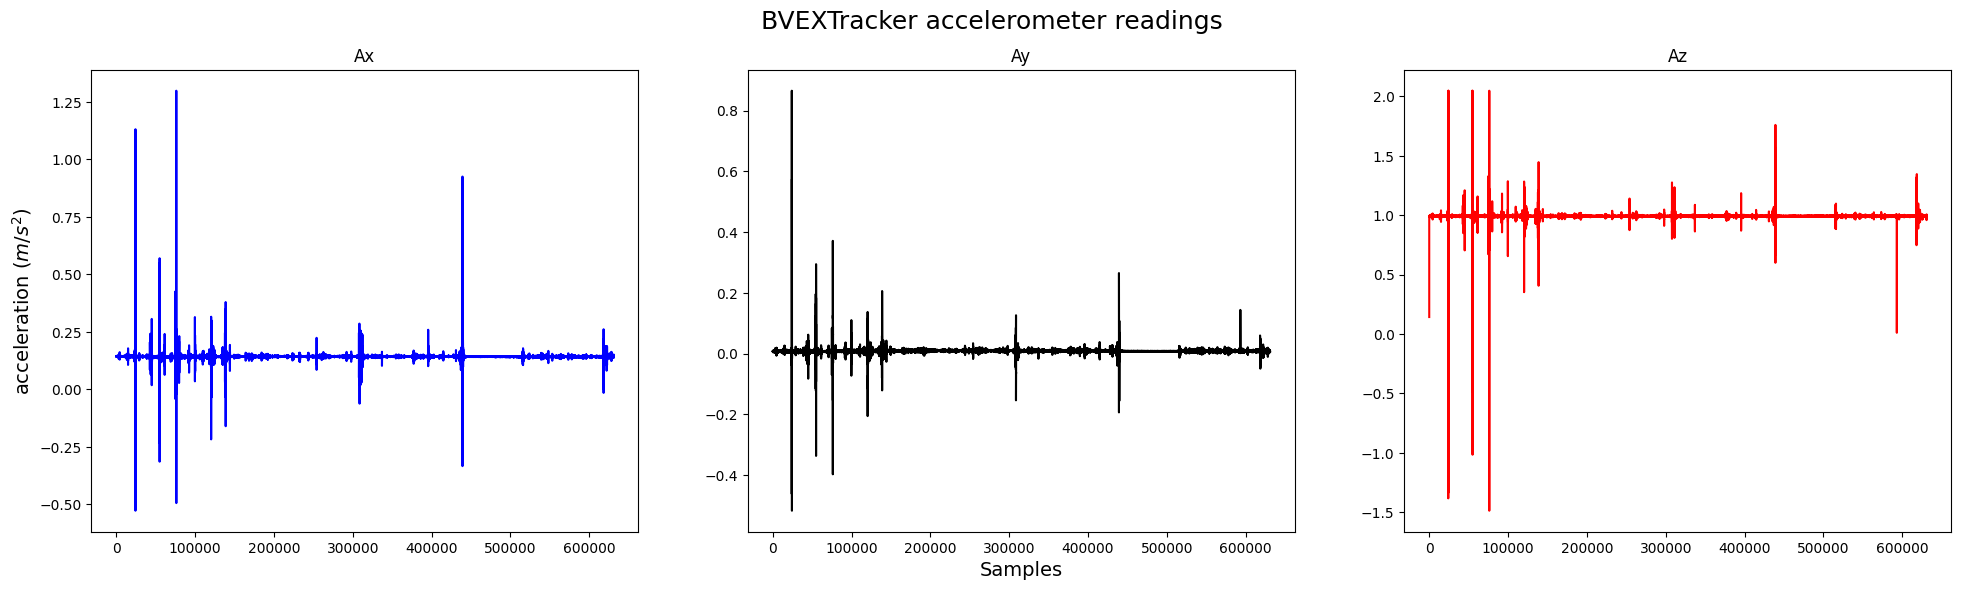

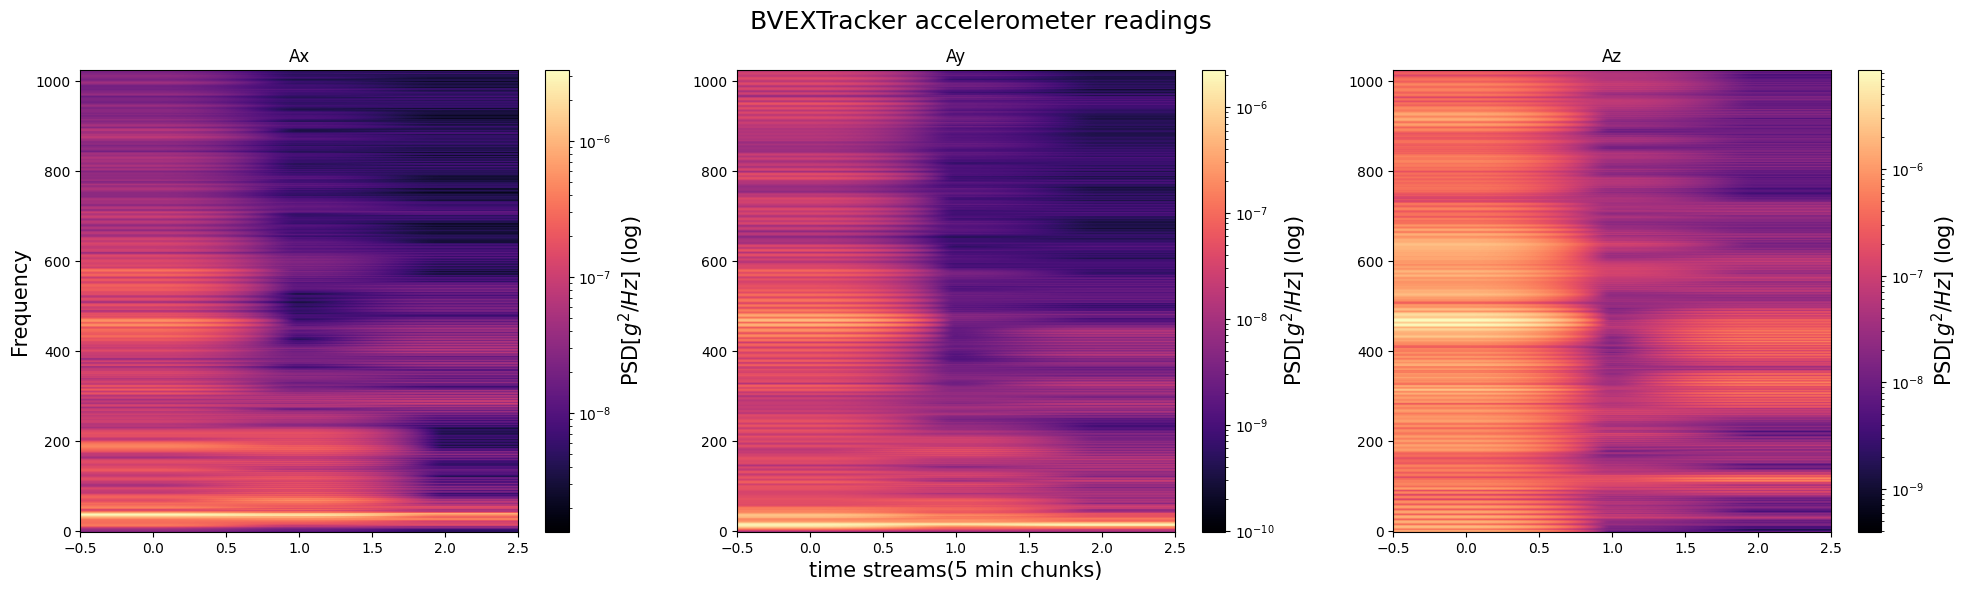

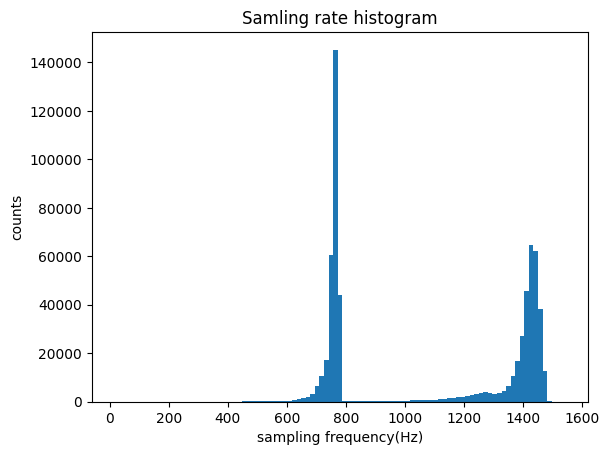

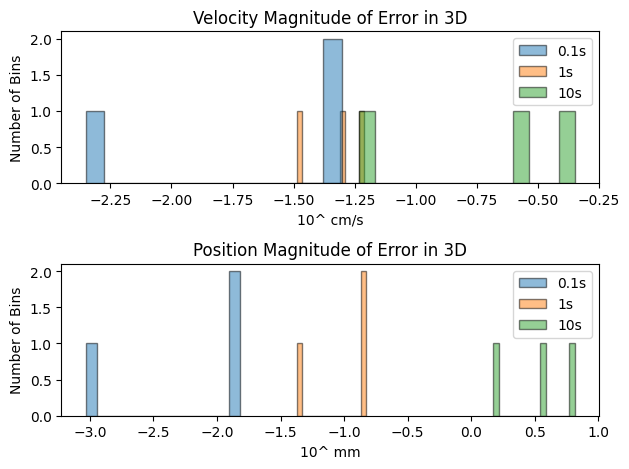

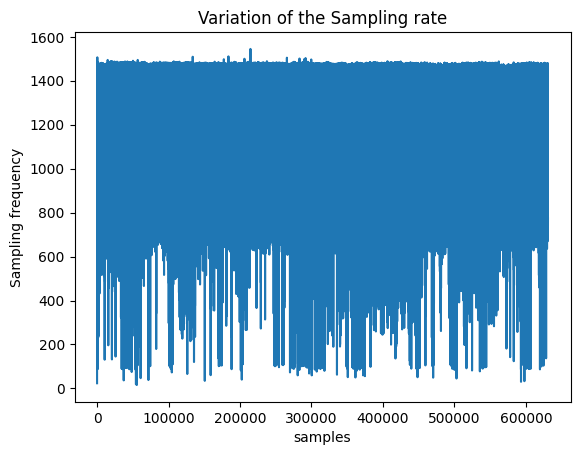

99.05774861260468 % of data does not have zero as its time


In [465]:
def get_file_names_in_folder(folder_path):
    try:
        # Get a list of all file names in the folder
        file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return file_names
    except OSError as e:
        print(f"Error: {e}")
        return []

# Replace 'folder_path' with the actual path of the folder you want to list files from
folder_path = 'output_11_2/Accelerometer'
file_names_list = get_file_names_in_folder(folder_path)

if file_names_list:
    print("List of file names in the folder:")
    for file_name in file_names_list:
        print(file_name)
else:
    print("No files found in the folder.")

# file_names_list=np.array(file_names_list)

# file_names_list = file_names_list.astype(int)

# file_names_list 


axx =[]
ayy =[]
azz =[]

axalllist=[]

fsslist =[]
tlist=[]
timealllist=[]
timezerodatalist=[]

psdax_list =[]
psday_list=[]
psdaz_list =[]

ssdax_list =[]
ssday_list=[]
ssdaz_list =[]

fxlist =[]
fylist =[]
fzlist =[]

vxx =[]
vyy =[]
vzz =[]

dxx =[]
dyy=[]
dzz=[]

verr01 =[]
verr1 =[]
verr10 = []

derr01 =[]
derr1=[]
derr10 =[]

vstatss01 =[]
vstatss1 =[]
vstatss10 = []

dstatss01 =[]
dstatss1 =[]
dstatss10 =[]



def read_file(file):
    data = []
    while True:
        try:
            bin_dat = file.read(20)
            if not bin_dat:
                break
            raw_dat = struct.unpack("<diii", bin_dat)
            data += [struct.unpack("<diii", bin_dat)]
        except Exception as e:
            print(e)
            print("got error reading data, returned processed data")
            return data
    return data

for i in file_names_list:

    with open(folder_path+'/'+i, "rb") as f:
        
        temp = 0
        data = read_file(f)
        time = []
        timezerodata=[]
        timeall =[]
        axall=[]
        ax = []
        ay = []
        az = []
        for line in data:
            timeall += [line[0]]
            axall += [line[1]*16.384 * 2 / 2**20] 
            if line[0] !=0:
                time += [line[0]]

                ax += [line[1]*2.048 * 2 / 2**20] 
                ay += [line[2]*2.048 * 2 / 2**20] 
                az += [line[3]*2.048 * 2 / 2**20]  
            else:
                timezerodata +=[line[0]]


    time_span = np.diff(time)
    mean_time_span = np.mean(time_span)
    fss = 1/ time_span
    mean_fss = np.mean(fss)

    print("mean dt :", mean_time_span," s")
    print("mean sampling rate :",mean_fss, "Hz")
    print("total samples",len(time))



    fs= mean_fss # Hz
    win = 2048

    fx,psdax = signal.welch(ax,fs,nperseg=win)
    fy,psday = signal.welch(ay,fs,nperseg=win)
    fz,psdaz = signal.welch(az,fs,nperseg=win)


    ax_mean = np.mean(ax)
    ay_mean = np.mean(ay)
    az_mean = np.mean(az)

    ax_avg = az - ax_mean
    ay_avg = ay - ay_mean
    az_avg = az - az_mean

    # create empty lists to put data in for 0.1s 
    vx01 = []
    vy01 = []
    vz01 = []

    dx01 = []
    dy01 = []
    dz01 = []

    # 1s
    vx1 = []
    vy1 = []
    vz1 = []

    dx1 = []
    dy1 = []
    dz1 = []

    # 10s
    vx10 = []
    vy10 = []
    vz10 = []

    dx10 = []
    dy10 = []
    dz10 = []

    t = time
    x = ax
    y = ay 
    z = az 


    t01 = np.where(t == 101)  # where t = 0.1s
    t1 = np.where(t == 1002)
    t10 = np.where(t == 10000)

    xmean = np.mean(ax)
    ymean = np.mean(ay)
    zmean = np.mean(az)

    xavg = x-xmean
    xshape = np.reshape(xavg,len(xavg))
    yavg = y-ymean
    yshape = np.reshape(yavg,len(yavg))
    zavg = z-zmean
    zshape = np.reshape(zavg,(len(zavg)))
    tshape = np.reshape(t, len(t))

    vx = np.array(1/1000 * integrate.cumtrapz(xshape, initial=1))   # integrate over 1 ms
    vy = np.array(1/1000 * integrate.cumtrapz(yshape, initial=1))
    vz = np.array(1/1000 * integrate.cumtrapz(zshape, initial=1))   # same length array as t

    dx = np.array(1/1000 * integrate.cumtrapz(vx, initial=1))
    dy = np.array(1/1000 * integrate.cumtrapz(vy, initial=1))
    dz = np.array(1/1000 * integrate.cumtrapz(vz, initial=1))  

    vx01.append(vx[32])   # list value where t=0.1
    vy01.append(vy[32])
    vz01.append(vz[32])

    dx01.append(dx[32])
    dy01.append(dy[32])
    dz01.append(dz[32])

    vx1.append(vx[297])  # where t=1
    vy1.append(vy[297])
    vz1.append(vz[297])

    dx1.append(dx[297])
    dy1.append(dy[297])
    dz1.append(dz[297])

    vx10.append(vx[2875])  # where t=10
    vy10.append(vy[2875])
    vz10.append(vz[2875])

    dx10.append(dx[2875])
    dy10.append(dy[2875])
    dz10.append(dz[2875])


    # convert to arrays
    # 0.1 s
    vxarr01 = np.array(np.abs(vx01))
    vyarr01 = np.array(np.abs(vy01))
    vzarr01 = np.array(np.abs(vz01))

    dxarr01 = np.array(np.abs(dx01))
    dyarr01 = np.array(np.abs(dy01))
    dzarr01 = np.array(np.abs(dz01))

    # 1s
    vxarr1 = np.array(np.abs(vx1))
    vyarr1 = np.array(np.abs(vy1))
    vzarr1 = np.array(np.abs(vz1))

    dxarr1 = np.array(np.abs(dx1))
    dyarr1 = np.array(np.abs(dy1))
    dzarr1 = np.array(np.abs(dz1))

    # 10 s
    vxarr10 = np.array(np.abs(vx10))
    vyarr10 = np.array(np.abs(vy10))
    vzarr10 = np.array(np.abs(vz10))

    dxarr10 = np.array(np.abs(dx10))
    dyarr10 = np.array(np.abs(dy10))
    dzarr10 = np.array(np.abs(dz10))


    # magnitude of error at 0.1s
    mag_errv01 = np.sqrt((vxarr01*100)**2 + (vyarr01*100)**2 + (vzarr01*100)**2)  # cm/s
    mag_errd01 = np.sqrt((dxarr01*1000)**2 + (dyarr01*1000)**2 + (dzarr01*1000)**2)  # mm

    # magnitude of error at 1 s
    mag_errv1 = np.sqrt((vxarr1*100)**2 + (vyarr1*100)**2 + (vzarr1*100)**2)  # cm/s
    mag_errd1 = np.sqrt((dxarr1*1000)**2 + (dyarr1*1000)**2 + (dzarr1*1000)**2)  # mm

    # magnitude of error at 10 s
    mag_errv10 = np.sqrt((vxarr10*100)**2 + (vyarr10*100)**2 + (vzarr10*100)**2)  # cm/s
    mag_errd10 = np.sqrt((dxarr10*1000)**2 + (dyarr10*1000)**2 + (dzarr10*1000)**2)  # mm


    # # log transform data to evenly distribute
    # fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

    log_verr01 = np.log10(mag_errv01)
    log_verr1 = np.log10(mag_errv1)
    log_verr10 = np.log10(mag_errv10)

    log_derr01 = np.log10(mag_errd01)
    log_derr1 = np.log10(mag_errd1)
    log_derr10 = np.log10(mag_errd10)

    
# #----------------------------------------appending all dara----------------------------    
    
    fsslist.append(fss)
    
    axx.append(ax)
    ayy.append(ay)
    azz.append(az)
    tlist.append(time)
    timealllist.append(timeall)
    timezerodatalist.append(timezerodata)
    
    axalllist.append(axall)

    psdax_list.append(psdax)
    psday_list.append(psday)
    psdaz_list.append(psdaz)
    
    # ssdax_list.append(Sxx)
    # ssday_list.append(Syy)
    # ssdaz_list.append(Szz)

    fxlist.append(fx)
    fylist.append(fy)
    fzlist.append(fy)

    vxx.append(vx)
    vyy.append(vy)
    vzz.append(vz)

    dxx.append(dx)
    dyy.append(dy)
    dzz.append(dz)

    verr01.append(log_verr01)
    verr1.append(log_verr1)
    verr10.append(log_verr10)

    derr01.append(log_derr01)
    derr1.append(log_derr1)
    derr10.append(log_derr10)

    vstatss01.append(vstats01)
    vstatss1.append(vstats1)
    vstatss10.append(vstats10)

    dstatss01.append(pstats01)
    dstatss1.append(pstats1)
    dstatss10.append(pstats10)
    
#-------------------------------------list flatenning and array mods-----------------------------    
    
def flatten_list(nested_list):
    flattened_list = []
    for item in nested_list:
        if isinstance(item, list):
            flattened_list.extend(flatten_list(item))
        else:
            flattened_list.append(item)
    return flattened_list

axx = flatten_list(axx)
ayy = flatten_list(ayy)
azz = flatten_list(azz)

#fsslist = flatten_list(fsslist)

psdax_list = np.array(psdax_list)
psday_list = np.array(psday_list)
psdaz_list = np.array(psdaz_list)

verr01= flatten_list(verr01)


def flatten_arrays_list(arrays_list):
    flattened_list = np.concatenate(arrays_list).ravel()
    return flattened_list

fsslist = flatten_arrays_list(fsslist)
timealllist= flatten_arrays_list(timealllist)
tlist = flatten_arrays_list(tlist)

axalllist = flatten_arrays_list(axalllist)
timezerodatalist = flatten_arrays_list(timezerodatalist)


verr01 = flatten_arrays_list(verr01)
verr1 = flatten_arrays_list(verr1)
verr10 = flatten_arrays_list(verr10)

derr01 = flatten_arrays_list(derr01)
derr1 = flatten_arrays_list(derr1)
derr10 = flatten_arrays_list(derr10)

#-------------------------------plotting data--------------------------------

fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker accelerometer readings',size=18)

axs[0].plot(axx,color = 'blue')
axs[0].set_title("Ax")


axs[1].plot(ayy,color = 'black')
axs[1].set_title("Ay")

axs[2].plot(azz,color = 'red')
axs[2].set_title("Az")

axs[1].set_xlabel('Samples',size=14)
axs[0].set_ylabel(r'acceleration ($m/s^2$)',size=14)


#plt.savefig("imuasd.png",dpi="figure")
plt.show()


fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker accelerometer readings',size=18)

ps1=axs[0].imshow(psdax_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[0].set_title("Ax")
cb1=fig.colorbar(ps1)
cb1.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

ps2=axs[1].imshow(psday_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[1].set_title("Ay")
cb2=fig.colorbar(ps2)
cb2.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

ps3=axs[2].imshow(psdaz_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[2].set_title("Az")
cb3=fig.colorbar(ps3)
cb3.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

axs[0].set_ylabel('Frequency',size=15)
axs[1].set_xlabel('time streams(5 min chunks)',size=15)


#plt.savefig("imuasd.png",dpi="figure")
plt.show()


plt.title("Samling rate histogram")
plt.xlabel("sampling frequency(Hz)")
plt.ylabel("counts")
plt.hist(fsslist,bins="auto")
plt.show()


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

# velocity magnitude of error
n1, bins01, patches = ax1.hist(verr01, bins=14, label='0.1s',alpha=0.5,zorder=5, histtype='bar', ec='black')
n2, bins1, patches = ax1.hist(verr1, bins=14, label='1s',alpha=0.5, histtype='bar', ec='black')
n3, bins10, patches = ax1.hist(verr10, bins=14, label='10s',alpha=0.5, histtype='bar', ec='black')
ax1.legend()
ax1.set_xscale('linear')
ax1.set_ylabel('Number of Bins')
ax1.set_title('Velocity Magnitude of Error in 3D')
ax1.set_xlabel('10^ cm/s')

nd1, binsd01, patchesd = ax2.hist(derr01, bins=14, label='0.1s',alpha=0.5, histtype='bar', ec='black')
nd2, binsd1, patchesd = ax2.hist(derr1, bins=14, label='1s',alpha=0.5, histtype='bar', ec='black')
nd3, binsd10, patchesd = ax2.hist(derr10, bins=14, label='10s',alpha=0.5, histtype='bar', ec='black')
ax2.legend()
ax2.set_xlabel('10^ mm')
ax2.set_ylabel('Number of Bins')
ax2.set_title('Position Magnitude of Error in 3D')
ax2.set_xscale('linear')

bin_centers = 0.5*(bins01[1:]+bins01[:-1])
sqrtn1 = np.sqrt(n1)

plt.tight_layout()

plt.show()

plt.title("Variation of the Sampling rate")
plt.plot(fsslist)
plt.ylabel("Sampling frequency")
plt.xlabel("samples")
plt.show()

print(len(tlist)/len(timealllist) *100,"% of data does not have zero as its time")


def calculate_rms(accel_data):
    squared_data = np.square(accel_data)
    mean_squared = np.mean(squared_data)
    rms_value = np.sqrt(mean_squared)
    return rms_value

axx_rms = calculate_rms(axx)
ayy_rms = calculate_rms(ayy)
azz_rms = calculate_rms(azz)

print("RMS ax:",axx_rms)
print("RMS ay:",ayy_rms)
print("RMS az:",azz_rms)

In [473]:
timealllist[2000]-timealllist[1000]

1.0031383037567139

In [474]:
timealllist[3000]-timealllist[2000]

1.0033204555511475

In [475]:
fssalllist=1/np.diff(timealllist)
plt.hist()

/var/folders/8g/zw9cjxxx2hz2444l1w_17w640000gn/T/ipykernel_52399/594950936.py:1: RuntimeWarning: divide by zero encountered in divide
  fssalllist=1/np.diff(timealllist)


### gyrodata

In [483]:
def read_file(file):
    data = []
    while True:
        try:
            bin_dat = file.read(14)
            if not bin_dat:
                break
            raw_dat = struct.unpack("<dHHH", bin_dat)
            data += [struct.unpack("<dHHH", bin_dat)]
        except Exception as e:
            print(e)
            print("got error reading data, returned processed data")
            return data
    return data

with open("output_11_2/Gyroscope/1691763772", "rb") as f:
    temp = 0
    data = read_file(f)
    time = []
    ax = []
    ay = []
    az = []
    for line in data:
        time += [line[0]]

        ax += [np.int16(line[1])*0.00875+ 1.25617] 
        ay += [np.int16(line[2])*0.00875- 1.65475] 
        az += [np.int16(line[3])*0.00875- 0.48935] 

List of file names in the folder:
1691763772
1691764072
1691764373
mean dt : 0.005019285085664021  s
mean sampling rate : 199.35102030410013 Hz
total samples 59879
mean dt : 0.005019433071044297  s
mean sampling rate : 199.33160016545884 Hz
total samples 59843
mean dt : 0.005020093748955124  s
mean sampling rate : 199.58791557890962 Hz
total samples 7624


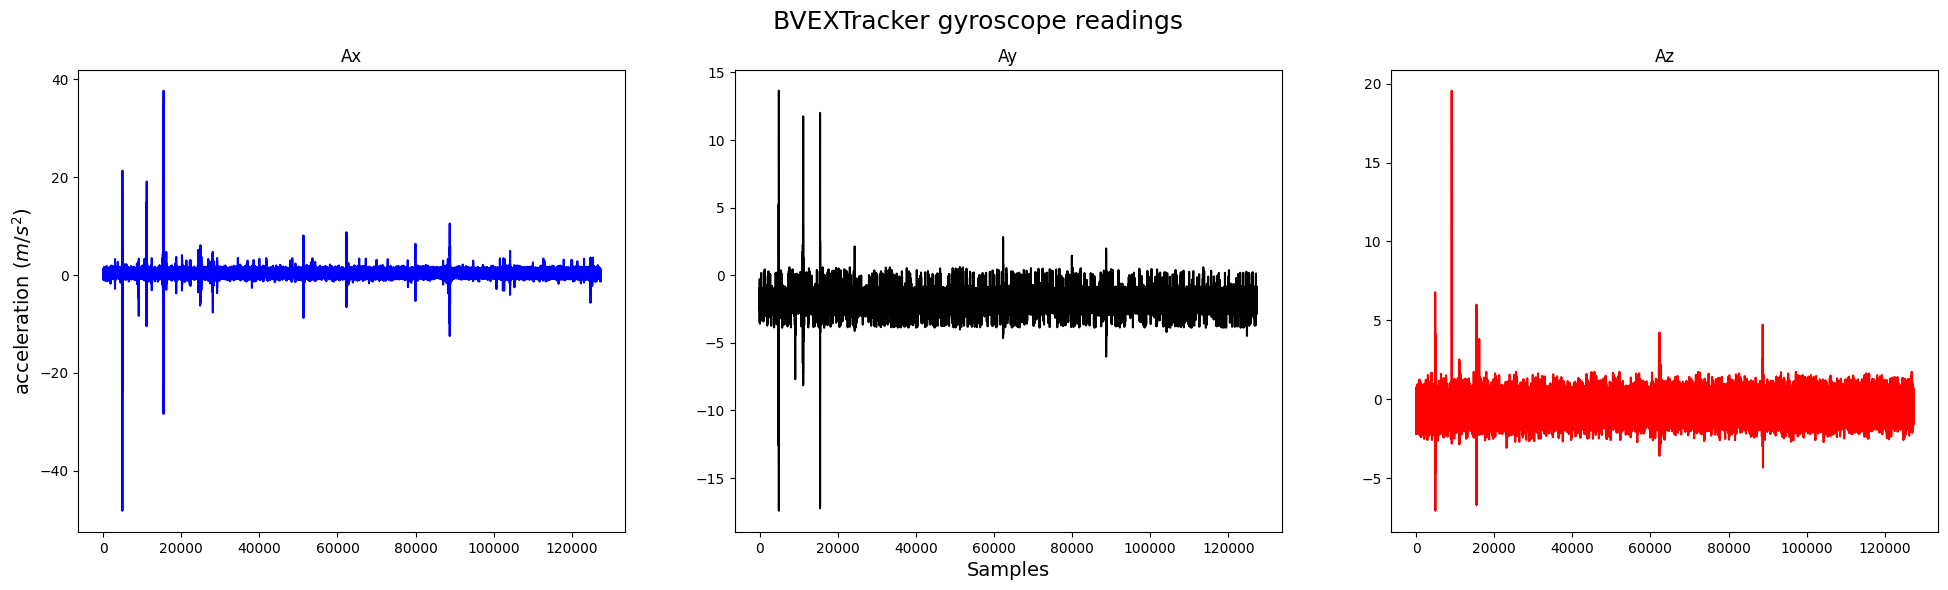

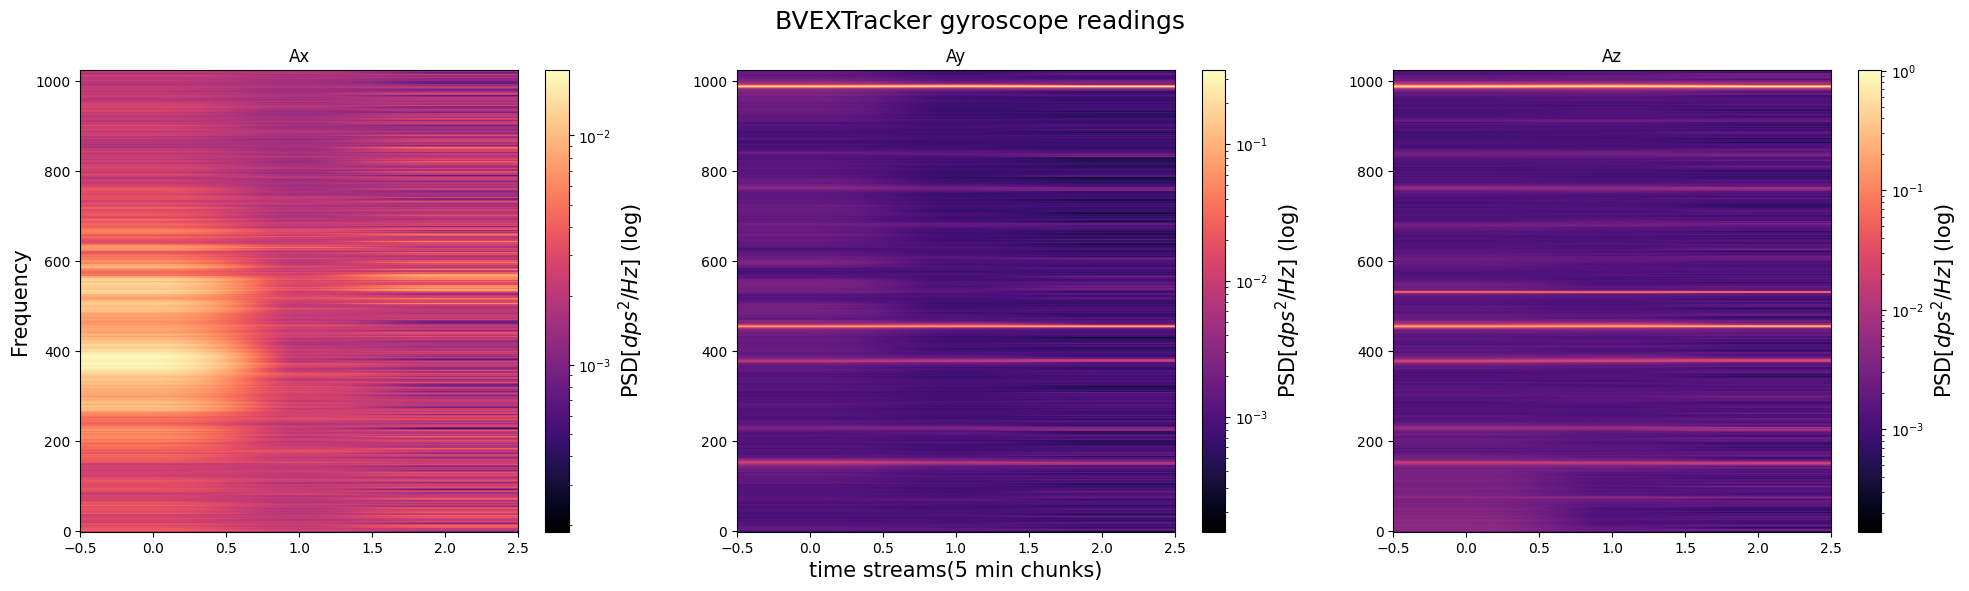

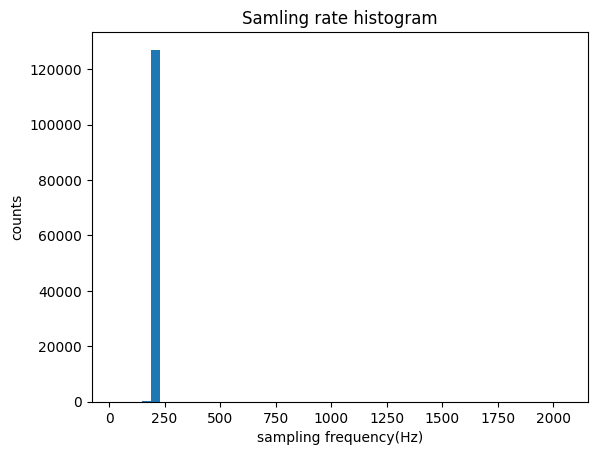

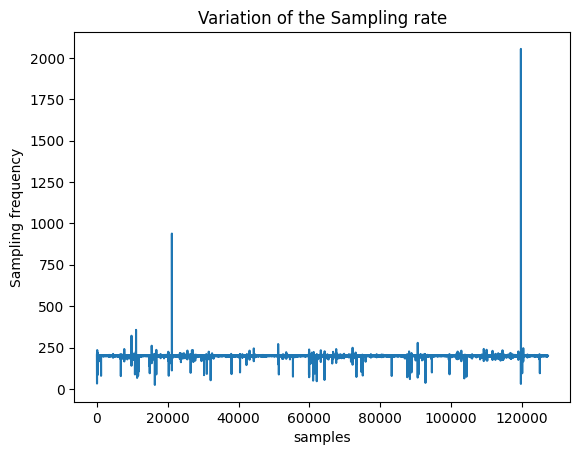

In [503]:
def get_file_names_in_folder(folder_path):
    try:
        # Get a list of all file names in the folder
        file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return file_names
    except OSError as e:
        print(f"Error: {e}")
        return []

# Replace 'folder_path' with the actual path of the folder you want to list files from
folder_path = 'output_11_2/Gyroscope/'
file_names_list = get_file_names_in_folder(folder_path)

if file_names_list:
    print("List of file names in the folder:")
    for file_name in file_names_list:
        print(file_name)
else:
    print("No files found in the folder.")

# file_names_list=np.array(file_names_list)

# file_names_list = file_names_list.astype(int)

# file_names_list 


axx =[]
ayy =[]
azz =[]

fsslist =[]

psdax_list =[]
psday_list=[]
psdaz_list =[]

ssdax_list =[]
ssday_list=[]
ssdaz_list =[]

fxlist =[]
fylist =[]
fzlist =[]

def read_file(file):
    data = []
    while True:
        try:
            bin_dat = file.read(14)
            if not bin_dat:
                break
            raw_dat = struct.unpack("<dHHH", bin_dat)
            data += [struct.unpack("<dHHH", bin_dat)]
        except Exception as e:
            print(e)
            print("got error reading data, returned processed data")
            return data
    return data

for i in file_names_list:

    with open(folder_path+'/'+i, "rb") as f:
        temp = 0
        data = read_file(f)
        time = []
        ax = []
        ay = []
        az = []
        for line in data:
            time += [line[0]]
            
            ax += [np.int16(line[1])*0.00875+ 1.25617] #degrees per second
            ay += [np.int16(line[2])*0.00875- 1.65475] 
            az += [np.int16(line[3])*0.00875- 0.48935]   


    time_span = np.diff(time)
    mean_time_span = np.mean(time_span)
    fss = 1/ time_span
    mean_fss = np.mean(fss)

    print("mean dt :", mean_time_span," s")
    print("mean sampling rate :",mean_fss, "Hz")
    print("total samples",len(time))


    fs= mean_fss # Hz
    win = 2048

    fx,psdax = signal.welch(ax,fs,nperseg=win)
    fy,psday = signal.welch(ay,fs,nperseg=win)
    fz,psdaz = signal.welch(az,fs,nperseg=win)


#----------------------------------------appending all dara----------------------------    
    
    fsslist.append(fss)
    
    axx.append(ax)
    ayy.append(ay)
    azz.append(az)

    psdax_list.append(psdax)
    psday_list.append(psday)
    psdaz_list.append(psdaz)
    
    # ssdax_list.append(Sxx)
    # ssday_list.append(Syy)
    # ssdaz_list.append(Szz)

    fxlist.append(fx)
    fylist.append(fy)
    fzlist.append(fy)
    
#-------------------------------------list flatenning and array mods-----------------------------    
    
def flatten_list(nested_list):
    flattened_list = []
    for item in nested_list:
        if isinstance(item, list):
            flattened_list.extend(flatten_list(item))
        else:
            flattened_list.append(item)
    return flattened_list

axx = flatten_list(axx)
ayy = flatten_list(ayy)
azz = flatten_list(azz)

#fsslist = flatten_list(fsslist)

psdax_list = np.array(psdax_list)
psday_list = np.array(psday_list)
psdaz_list = np.array(psdaz_list)

verr01= flatten_list(verr01)


def flatten_arrays_list(arrays_list):
    flattened_list = np.concatenate(arrays_list).ravel()
    return flattened_list

fsslist = flatten_arrays_list(fsslist)


# verr01 = flatten_arrays_list(verr01)
# verr1 = flatten_arrays_list(verr1)
# verr10 = flatten_arrays_list(verr10)

# derr01 = flatten_arrays_list(derr01)
# derr1 = flatten_arrays_list(derr1)
# derr10 = flatten_arrays_list(derr10)

#-------------------------------plotting data--------------------------------

fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker gyroscope readings',size=18)

axs[0].plot(axx,color = 'blue')
axs[0].set_title("Ax")


axs[1].plot(ayy,color = 'black')
axs[1].set_title("Ay")

axs[2].plot(azz,color = 'red')
axs[2].set_title("Az")

axs[1].set_xlabel('Samples',size=14)
axs[0].set_ylabel(r'acceleration ($m/s^2$)',size=14)


#plt.savefig("imuasd.png",dpi="figure")
plt.show()


fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker gyroscope readings',size=18)

ps1=axs[0].imshow(psdax_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[0].set_title("Ax")
cb1=fig.colorbar(ps1)
cb1.set_label(label='PSD[$dps^2/Hz$] (log)', size='15')

ps2=axs[1].imshow(psday_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[1].set_title("Ay")
cb2=fig.colorbar(ps2)
cb2.set_label(label='PSD[$dps^2/Hz$] (log)', size='15')

ps3=axs[2].imshow(psdaz_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[2].set_title("Az")
cb3=fig.colorbar(ps3)
cb3.set_label(label='PSD[$dps^2/Hz$] (log)', size='15')

axs[0].set_ylabel('Frequency',size=15)
axs[1].set_xlabel('time streams(5 min chunks)',size=15)


#plt.savefig("imuasd.png",dpi="figure")
plt.show()


plt.title("Samling rate histogram")
plt.xlabel("sampling frequency(Hz)")
plt.ylabel("counts")
plt.hist(fsslist,bins=50)
plt.show()

plt.title("Variation of the Sampling rate")
plt.plot(fsslist)
plt.ylabel("Sampling frequency")
plt.xlabel("samples")
plt.show()

In [504]:
def calculate_rms(accel_data):
    squared_data = np.square(accel_data)
    mean_squared = np.mean(squared_data)
    rms_value = np.sqrt(mean_squared)
    return rms_value

axx_rms = calculate_rms(axx)

0.672331043511045

## tests

### Accl tests

List of file names in the folder:
1691783294
1691782693
1691782695
1691782994
unpack requires a buffer of 20 bytes
got error reading data, returned processed data
mean dt : 0.001316405920536515  s
mean sampling rate : 917.7178920216124 Hz
total samples 71562
mean dt : 0.0013827821849566515  s
mean sampling rate : 914.3752151127296 Hz
total samples 217505
mean dt : 0.0024426403832659457  s
mean sampling rate : 815.99973873458 Hz
total samples 12143
mean dt : 0.0013074138016040198  s
mean sampling rate : 922.4300696641627 Hz
total samples 229877


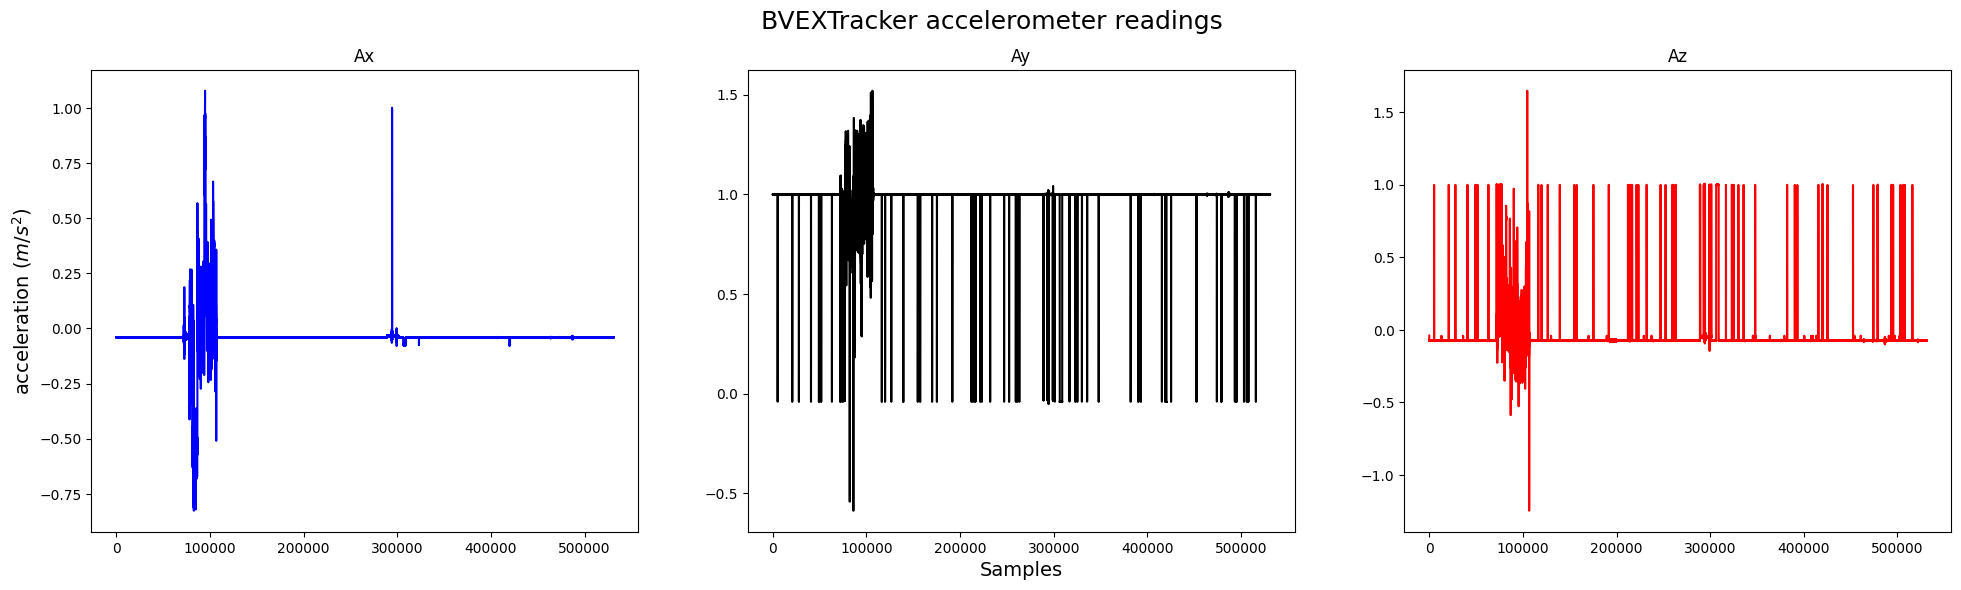

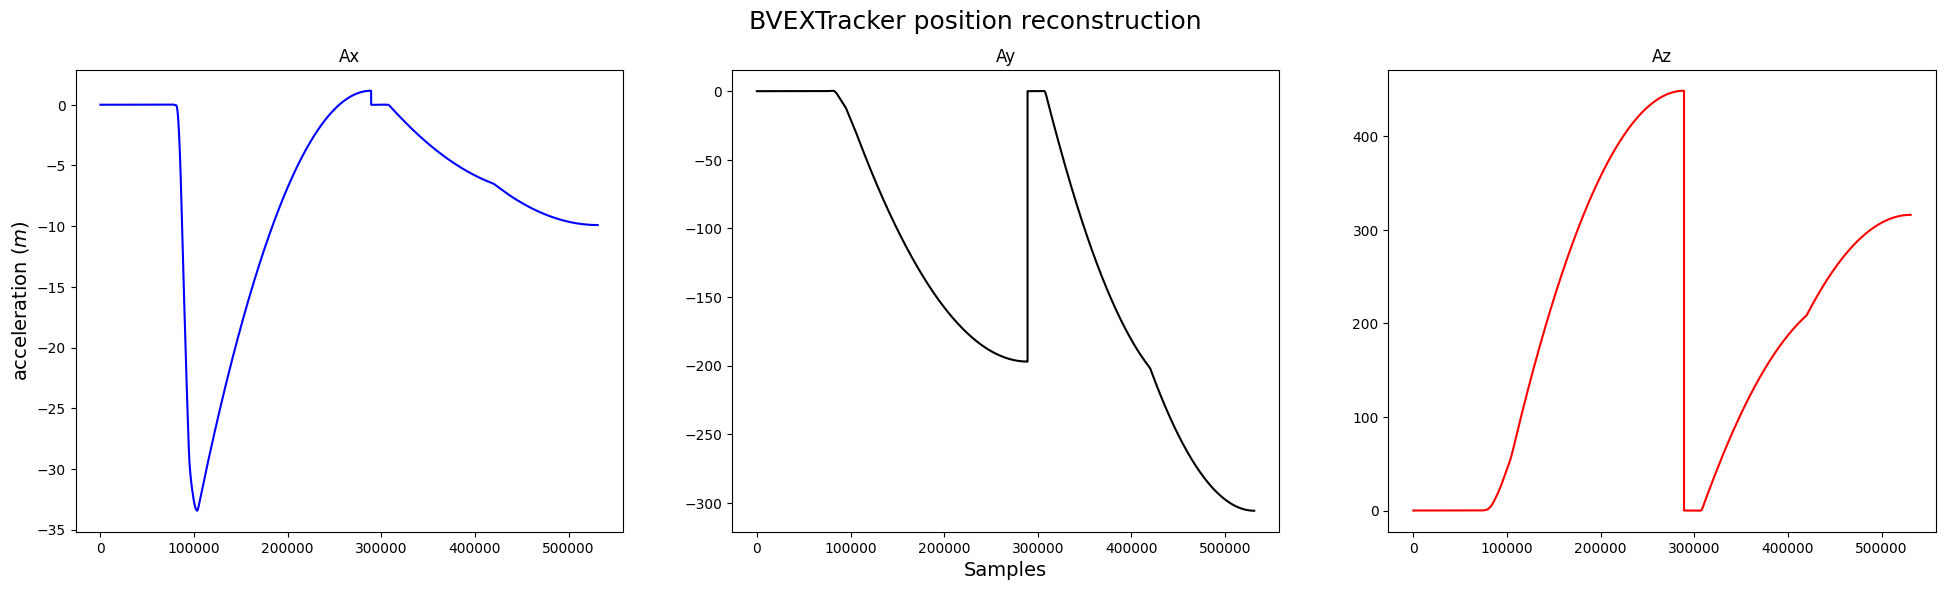

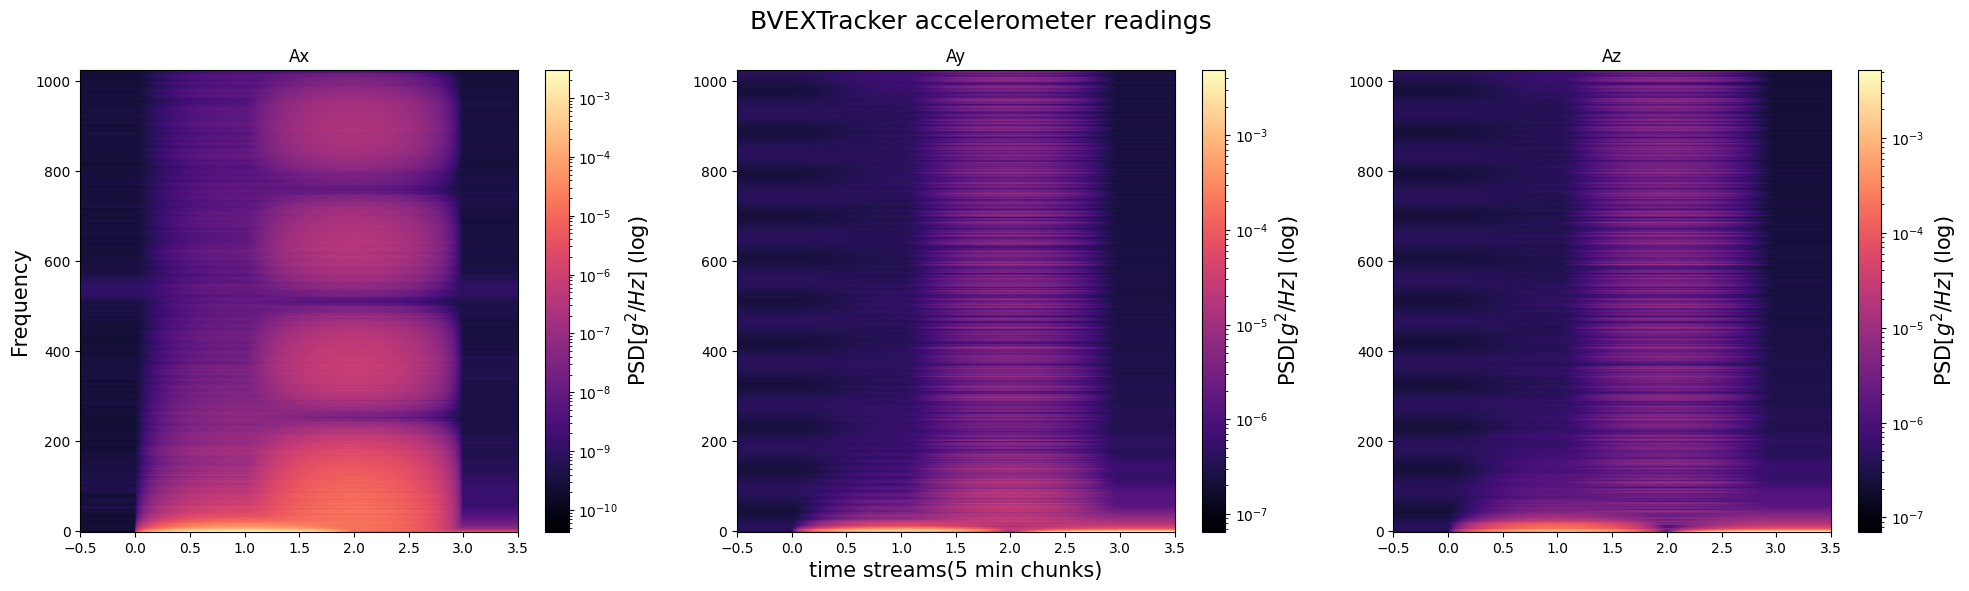

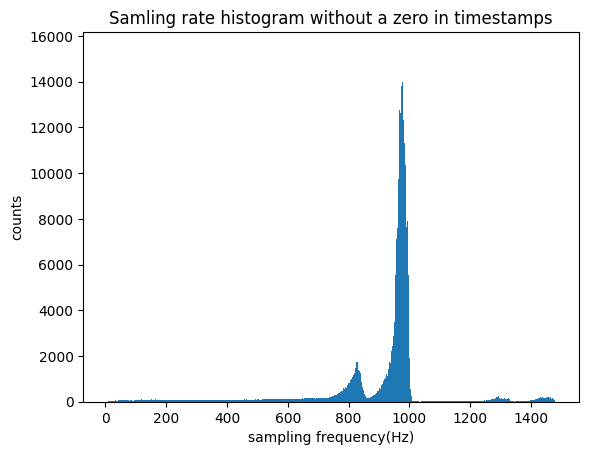

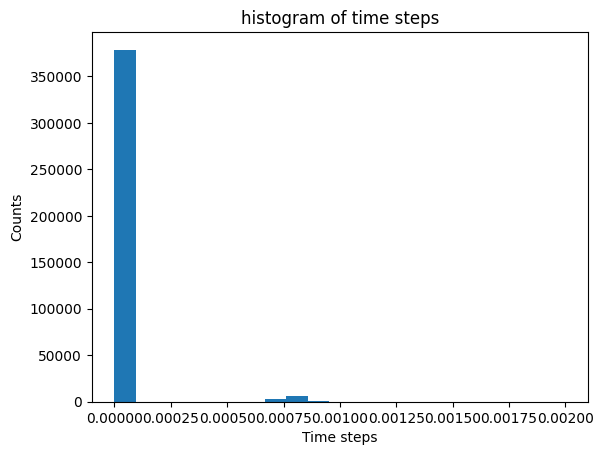

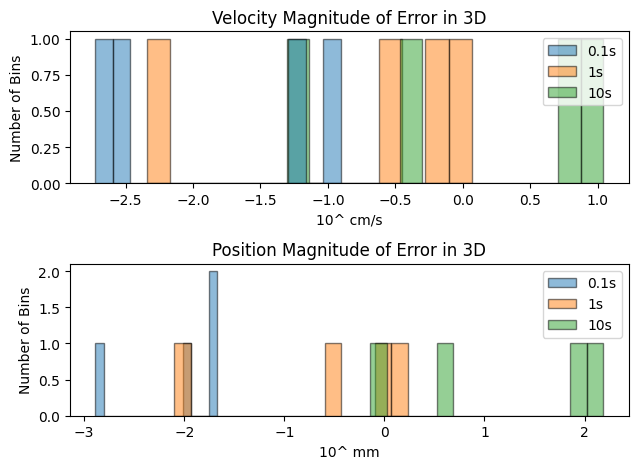

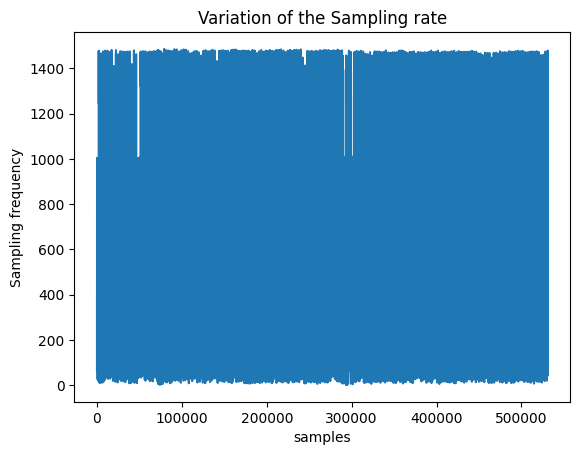

37.12700809529802 % of data does not have zero as its time
RMS ax: 0.0888462810740145
RMS ay: 0.9920039083466036
RMS az: 0.12048268018299965
1691783295.865346
-1691783295.865346
0.0


In [43]:
def get_file_names_in_folder(folder_path):
    try:
        # Get a list of all file names in the folder
        file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return file_names
    except OSError as e:
        print(f"Error: {e}")
        return []

# Replace 'folder_path' with the actual path of the folder you want to list files from
folder_path = 'output_11_4/Accelerometer'
file_names_list = get_file_names_in_folder(folder_path)

if file_names_list:
    print("List of file names in the folder:")
    for file_name in file_names_list:
        print(file_name)
else:
    print("No files found in the folder.")

# file_names_list=np.array(file_names_list)

# file_names_list = file_names_list.astype(int)

# file_names_list 


axx =[]
ayy =[]
azz =[]

axalllist=[]

fsslist =[]
tlist=[]
timealllist=[]
timezerodatalist=[]

psdax_list =[]
psday_list=[]
psdaz_list =[]

ssdax_list =[]
ssday_list=[]
ssdaz_list =[]

fxlist =[]
fylist =[]
fzlist =[]

vxx =[]
vyy =[]
vzz =[]

dxx =[]
dyy=[]
dzz=[]

verr01 =[]
verr1 =[]
verr10 = []

derr01 =[]
derr1=[]
derr10 =[]

vstatss01 =[]
vstatss1 =[]
vstatss10 = []

dstatss01 =[]
dstatss1 =[]
dstatss10 =[]



def read_file(file):
    data = []
    while True:
        try:
            bin_dat = file.read(20)
            if not bin_dat:
                break
            raw_dat = struct.unpack("<diii", bin_dat)
            data += [struct.unpack("<diii", bin_dat)]
        except Exception as e:
            print(e)
            print("got error reading data, returned processed data")
            return data
    return data

for i in file_names_list:

    with open(folder_path+'/'+i, "rb") as f:
        
        temp = 0
        data = read_file(f)
        time = []
        timezerodata=[]
        timeall =[]
        axall=[]
        ax = []
        ay = []
        az = []
        for line in data:
            timeall += [line[0]]
            axall += [line[1]*16.384 * 2 / 2**20] 
            if line[0] !=0:
                time += [line[0]]

                ax += [line[1]*2.048 * 2 / 2**20] 
                ay += [line[2]*2.048 * 2 / 2**20] 
                az += [line[3]*2.048 * 2 / 2**20]  
            else:
                timezerodata +=[line[0]]


    time_span = np.diff(time)
    mean_time_span = np.mean(time_span)
    fss = 1/ time_span
    mean_fss = np.mean(fss)

    print("mean dt :", mean_time_span," s")
    print("mean sampling rate :",mean_fss, "Hz")
    print("total samples",len(time))



    fs= mean_fss # Hz
    win = 2048

    fx,psdax = signal.welch(ax,fs,nperseg=win)
    fy,psday = signal.welch(ay,fs,nperseg=win)
    fz,psdaz = signal.welch(az,fs,nperseg=win)


    ax_mean = np.mean(ax)
    ay_mean = np.mean(ay)
    az_mean = np.mean(az)

    ax_avg = az - ax_mean
    ay_avg = ay - ay_mean
    az_avg = az - az_mean

    # create empty lists to put data in for 0.1s 
    vx01 = []
    vy01 = []
    vz01 = []

    dx01 = []
    dy01 = []
    dz01 = []

    # 1s
    vx1 = []
    vy1 = []
    vz1 = []

    dx1 = []
    dy1 = []
    dz1 = []

    # 10s
    vx10 = []
    vy10 = []
    vz10 = []

    dx10 = []
    dy10 = []
    dz10 = []

    t = time
    x = ax
    y = ay 
    z = az 


    t01 = np.where(t == 101)  # where t = 0.1s
    t1 = np.where(t == 1002)
    t10 = np.where(t == 10000)

    xmean = np.mean(ax)
    ymean = np.mean(ay)
    zmean = np.mean(az)

    xavg = x-xmean
    xshape = np.reshape(xavg,len(xavg))
    yavg = y-ymean
    yshape = np.reshape(yavg,len(yavg))
    zavg = z-zmean
    zshape = np.reshape(zavg,(len(zavg)))
    tshape = np.reshape(t, len(t))

    vx = np.array(1/1000 * integrate.cumtrapz(xshape, initial=1))   # integrate over 1 ms
    vy = np.array(1/1000 * integrate.cumtrapz(yshape, initial=1))
    vz = np.array(1/1000 * integrate.cumtrapz(zshape, initial=1))   # same length array as t

    dx = np.array(1/1000 * integrate.cumtrapz(vx, initial=1))
    dy = np.array(1/1000 * integrate.cumtrapz(vy, initial=1))
    dz = np.array(1/1000 * integrate.cumtrapz(vz, initial=1))  

    vx01.append(vx[32])   # list value where t=0.1
    vy01.append(vy[32])
    vz01.append(vz[32])

    dx01.append(dx[32])
    dy01.append(dy[32])
    dz01.append(dz[32])

    vx1.append(vx[297])  # where t=1
    vy1.append(vy[297])
    vz1.append(vz[297])

    dx1.append(dx[297])
    dy1.append(dy[297])
    dz1.append(dz[297])

    vx10.append(vx[2875])  # where t=10
    vy10.append(vy[2875])
    vz10.append(vz[2875])

    dx10.append(dx[2875])
    dy10.append(dy[2875])
    dz10.append(dz[2875])


    # convert to arrays
    # 0.1 s
    vxarr01 = np.array(np.abs(vx01))
    vyarr01 = np.array(np.abs(vy01))
    vzarr01 = np.array(np.abs(vz01))

    dxarr01 = np.array(np.abs(dx01))
    dyarr01 = np.array(np.abs(dy01))
    dzarr01 = np.array(np.abs(dz01))

    # 1s
    vxarr1 = np.array(np.abs(vx1))
    vyarr1 = np.array(np.abs(vy1))
    vzarr1 = np.array(np.abs(vz1))

    dxarr1 = np.array(np.abs(dx1))
    dyarr1 = np.array(np.abs(dy1))
    dzarr1 = np.array(np.abs(dz1))

    # 10 s
    vxarr10 = np.array(np.abs(vx10))
    vyarr10 = np.array(np.abs(vy10))
    vzarr10 = np.array(np.abs(vz10))

    dxarr10 = np.array(np.abs(dx10))
    dyarr10 = np.array(np.abs(dy10))
    dzarr10 = np.array(np.abs(dz10))


    # magnitude of error at 0.1s
    mag_errv01 = np.sqrt((vxarr01*100)**2 + (vyarr01*100)**2 + (vzarr01*100)**2)  # cm/s
    mag_errd01 = np.sqrt((dxarr01*1000)**2 + (dyarr01*1000)**2 + (dzarr01*1000)**2)  # mm

    # magnitude of error at 1 s
    mag_errv1 = np.sqrt((vxarr1*100)**2 + (vyarr1*100)**2 + (vzarr1*100)**2)  # cm/s
    mag_errd1 = np.sqrt((dxarr1*1000)**2 + (dyarr1*1000)**2 + (dzarr1*1000)**2)  # mm

    # magnitude of error at 10 s
    mag_errv10 = np.sqrt((vxarr10*100)**2 + (vyarr10*100)**2 + (vzarr10*100)**2)  # cm/s
    mag_errd10 = np.sqrt((dxarr10*1000)**2 + (dyarr10*1000)**2 + (dzarr10*1000)**2)  # mm


    # # log transform data to evenly distribute
    # fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

    log_verr01 = np.log10(mag_errv01)
    log_verr1 = np.log10(mag_errv1)
    log_verr10 = np.log10(mag_errv10)

    log_derr01 = np.log10(mag_errd01)
    log_derr1 = np.log10(mag_errd1)
    log_derr10 = np.log10(mag_errd10)

    
# #----------------------------------------appending all dara----------------------------    
    
    fsslist.append(fss)
    
    axx.append(ax)
    ayy.append(ay)
    azz.append(az)
    tlist.append(time)
    timealllist.append(timeall)
    timezerodatalist.append(timezerodata)
    
    axalllist.append(axall)

    psdax_list.append(psdax)
    psday_list.append(psday)
    psdaz_list.append(psdaz)
    
    # ssdax_list.append(Sxx)
    # ssday_list.append(Syy)
    # ssdaz_list.append(Szz)

    fxlist.append(fx)
    fylist.append(fy)
    fzlist.append(fy)

    vxx.append(vx)
    vyy.append(vy)
    vzz.append(vz)

    dxx.append(dx)
    dyy.append(dy)
    dzz.append(dz)

    verr01.append(log_verr01)
    verr1.append(log_verr1)
    verr10.append(log_verr10)

    derr01.append(log_derr01)
    derr1.append(log_derr1)
    derr10.append(log_derr10)

#     vstatss01.append(vstats01)
#     vstatss1.append(vstats1)
#     vstatss10.append(vstats10)

#     dstatss01.append(pstats01)
#     dstatss1.append(pstats1)
#     dstatss10.append(pstats10)
    
#-------------------------------------list flatenning and array mods-----------------------------    
    
def flatten_list(nested_list):
    flattened_list = []
    for item in nested_list:
        if isinstance(item, list):
            flattened_list.extend(flatten_list(item))
        else:
            flattened_list.append(item)
    return flattened_list

axx = flatten_list(axx)
ayy = flatten_list(ayy)
azz = flatten_list(azz)

#fsslist = flatten_list(fsslist)

psdax_list = np.array(psdax_list)
psday_list = np.array(psday_list)
psdaz_list = np.array(psdaz_list)

verr01= flatten_list(verr01)


def flatten_arrays_list(arrays_list):
    flattened_list = np.concatenate(arrays_list).ravel()
    return flattened_list

fsslist = flatten_arrays_list(fsslist)
timealllist= flatten_arrays_list(timealllist)
tlist = flatten_arrays_list(tlist)

axalllist = flatten_arrays_list(axalllist)
timezerodatalist = flatten_arrays_list(timezerodatalist)


verr01 = flatten_arrays_list(verr01)
verr1 = flatten_arrays_list(verr1)
verr10 = flatten_arrays_list(verr10)

derr01 = flatten_arrays_list(derr01)
derr1 = flatten_arrays_list(derr1)
derr10 = flatten_arrays_list(derr10)

dxx = flatten_arrays_list(dxx)
dyy = flatten_arrays_list(dyy)
dzz = flatten_arrays_list(dzz)


#-------------------------------plotting data--------------------------------

fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker accelerometer readings',size=18)

axs[0].plot(axx,color = 'blue')
axs[0].set_title("Ax")


axs[1].plot(ayy,color = 'black')
axs[1].set_title("Ay")

axs[2].plot(azz,color = 'red')
axs[2].set_title("Az")

axs[1].set_xlabel('Samples',size=14)
axs[0].set_ylabel(r'acceleration ($m/s^2$)',size=14)


#plt.savefig("imuasd.png",dpi="figure")
plt.show()



fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker position reconstruction',size=18)

axs[0].plot(dxx,color = 'blue')
axs[0].set_title("Ax")


axs[1].plot(dyy,color = 'black')
axs[1].set_title("Ay")

axs[2].plot(dzz,color = 'red')
axs[2].set_title("Az")

axs[1].set_xlabel('Samples',size=14)
axs[0].set_ylabel(r'acceleration ($m$)',size=14)


#plt.savefig("imuasd.png",dpi="figure")
plt.show()



fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker accelerometer readings',size=18)

ps1=axs[0].imshow(psdax_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[0].set_title("Ax")
cb1=fig.colorbar(ps1)
cb1.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

ps2=axs[1].imshow(psday_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[1].set_title("Ay")
cb2=fig.colorbar(ps2)
cb2.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

ps3=axs[2].imshow(psdaz_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[2].set_title("Az")
cb3=fig.colorbar(ps3)
cb3.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

axs[0].set_ylabel('Frequency',size=15)
axs[1].set_xlabel('time streams(5 min chunks)',size=15)


#plt.savefig("imuasd.png",dpi="figure")
plt.show()


plt.title("Samling rate histogram without a zero in timestamps")
plt.xlabel("sampling frequency(Hz)")
plt.ylabel("counts")
plt.hist(fsslist,bins="auto")
plt.show()

plt.title("histogram of time steps")
plt.hist(np.diff(timealllist),range=[0, 0.002],bins="auto")
plt.ylabel("Counts")
plt.xlabel("Time steps")
plt.show()

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

# velocity magnitude of error
n1, bins01, patches = ax1.hist(verr01, bins=14, label='0.1s',alpha=0.5,zorder=5, histtype='bar', ec='black')
n2, bins1, patches = ax1.hist(verr1, bins=14, label='1s',alpha=0.5, histtype='bar', ec='black')
n3, bins10, patches = ax1.hist(verr10, bins=14, label='10s',alpha=0.5, histtype='bar', ec='black')
ax1.legend()
ax1.set_xscale('linear')
ax1.set_ylabel('Number of Bins')
ax1.set_title('Velocity Magnitude of Error in 3D')
ax1.set_xlabel('10^ cm/s')

nd1, binsd01, patchesd = ax2.hist(derr01, bins=14, label='0.1s',alpha=0.5, histtype='bar', ec='black')
nd2, binsd1, patchesd = ax2.hist(derr1, bins=14, label='1s',alpha=0.5, histtype='bar', ec='black')
nd3, binsd10, patchesd = ax2.hist(derr10, bins=14, label='10s',alpha=0.5, histtype='bar', ec='black')
ax2.legend()
ax2.set_xlabel('10^ mm')
ax2.set_ylabel('Number of Bins')
ax2.set_title('Position Magnitude of Error in 3D')
ax2.set_xscale('linear')

bin_centers = 0.5*(bins01[1:]+bins01[:-1])
sqrtn1 = np.sqrt(n1)

plt.tight_layout()

plt.show()

plt.title("Variation of the Sampling rate")
plt.plot(fsslist)
plt.ylabel("Sampling frequency")
plt.xlabel("samples")
plt.show()

print(len(tlist)/len(timealllist) *100,"% of data does not have zero as its time")


def calculate_rms(accel_data):
    squared_data = np.square(accel_data)
    mean_squared = np.mean(squared_data)
    rms_value = np.sqrt(mean_squared)
    return rms_value

axx_rms = calculate_rms(axx)
ayy_rms = calculate_rms(ayy)
azz_rms = calculate_rms(azz)

print("RMS ax:",axx_rms)
print("RMS ay:",ayy_rms)
print("RMS az:",azz_rms)

print(timealllist[2000]-timealllist[1000])
print(timealllist[3000]-timealllist[2000])
print(timealllist[4000]-timealllist[3000])

1691825743
1691821541
1691829946
1691841654
1691805326
1691838052
1691805926
1691836551
1691831146
1691814034
1691816135
1691823642
1691827845
1691801122
1691812532
1691843156
1691827245
1691819438
1691837151
1691817936
1691826644
1691813133
1691834147
1691844056
1691798295
1691802024
1691806226
1691828145
1691796192
1691832046
1691806827
1691811631
1691830546
1691804125
1691807127
1691838352
1691825443
1691827545
1691838953
1691821241
1691797695
1691812833
1691836251
1691810131
1691809229
1691814334
1691836851
1691814934
1691840153
1691800822
1691796491
1691844958
1691802924
1691842856
1691802324
1691830246
1691835350
1691819738
1691832947
1691835950
1691830846
1691820640
1691844357
1691808629
1691822142
1691817635
1691806526
1691832346
1691823042
1691816735
1691814634
1691803825
1691831746
1691810431
1691818838
1691797995
1691820038
1691807428
1691843756
1691829345
1691838653
1691818237
1691803224
1691825143
1691841054
1691801723
1691797394
1691833847
1691833247
1691839253
1691796792

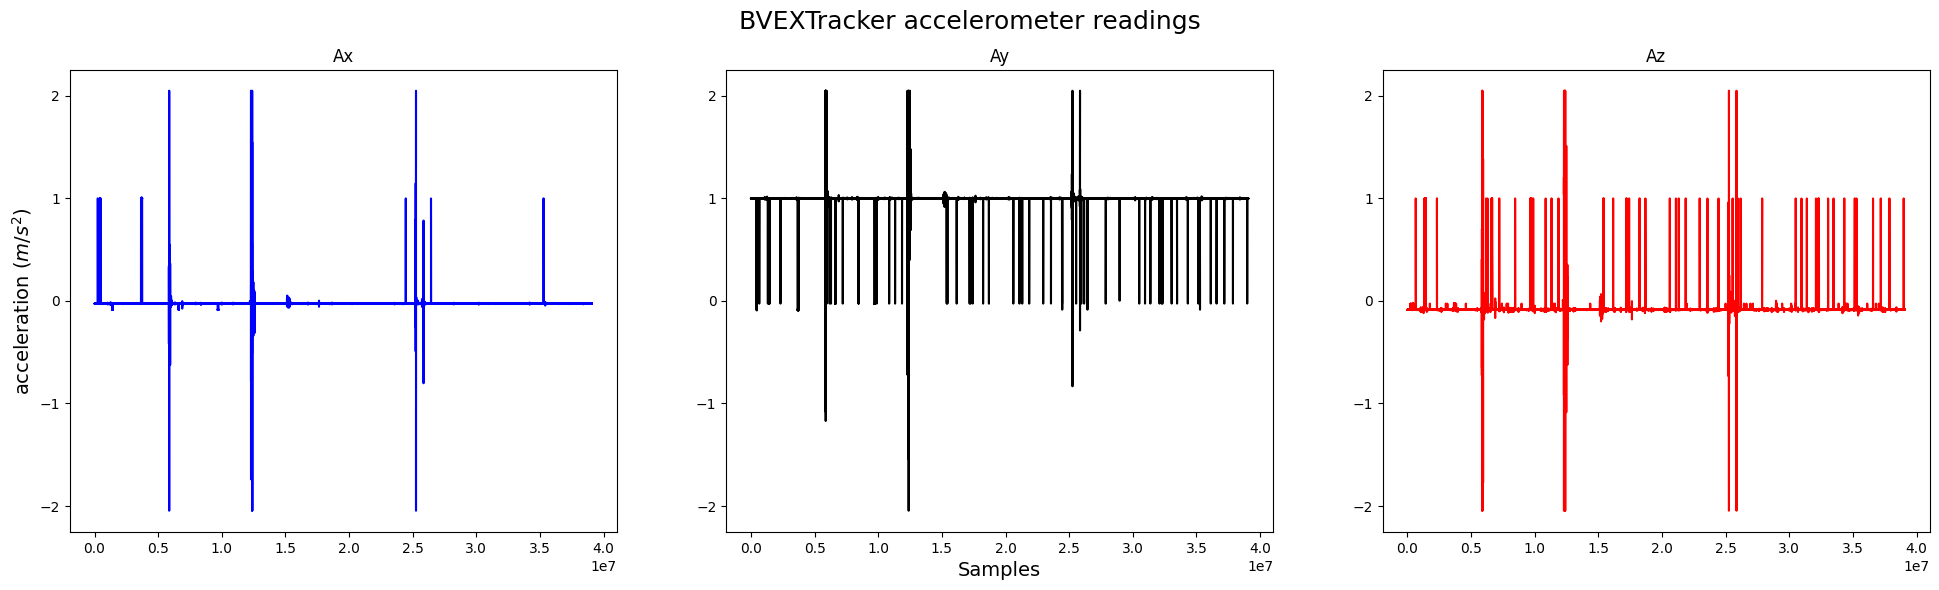

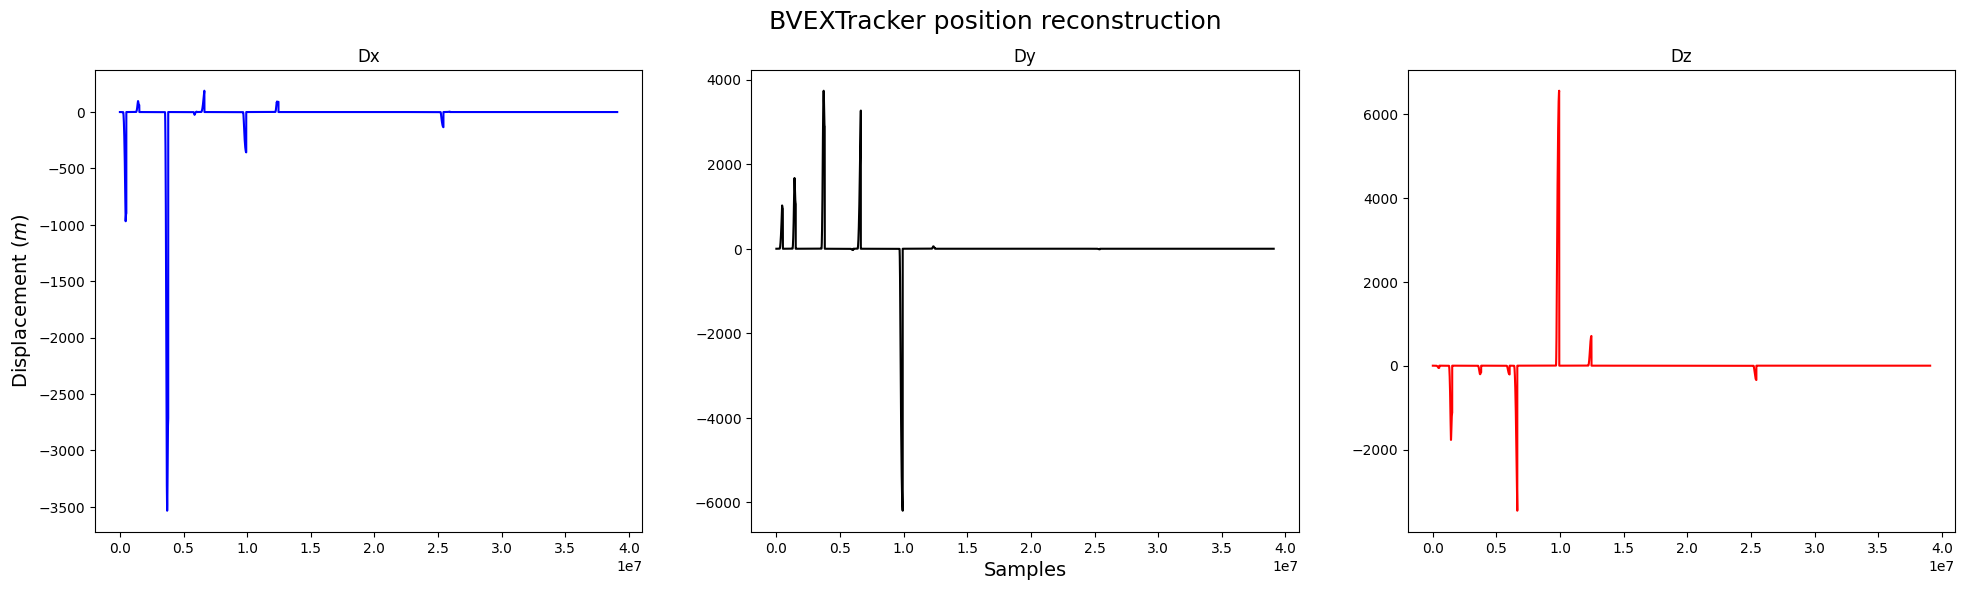

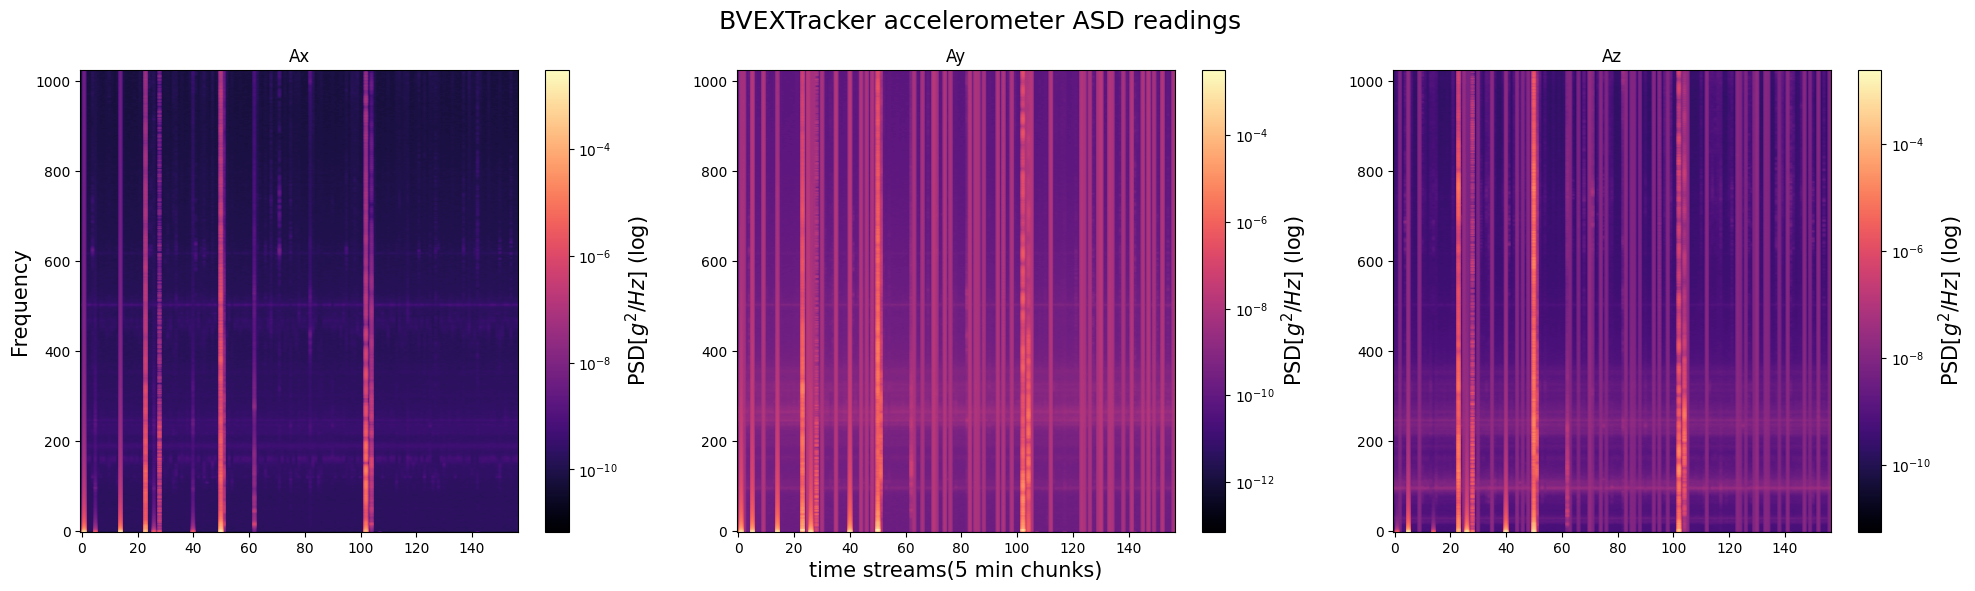

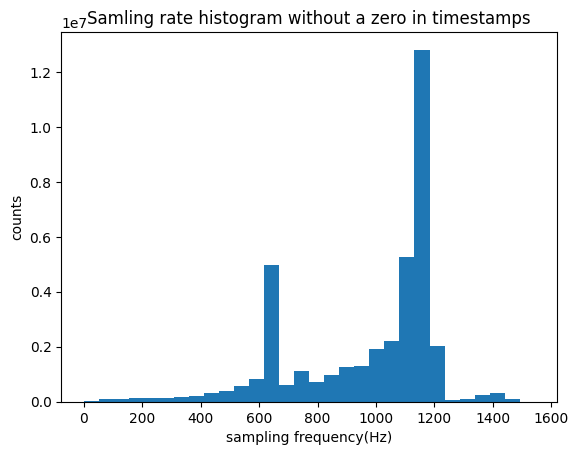

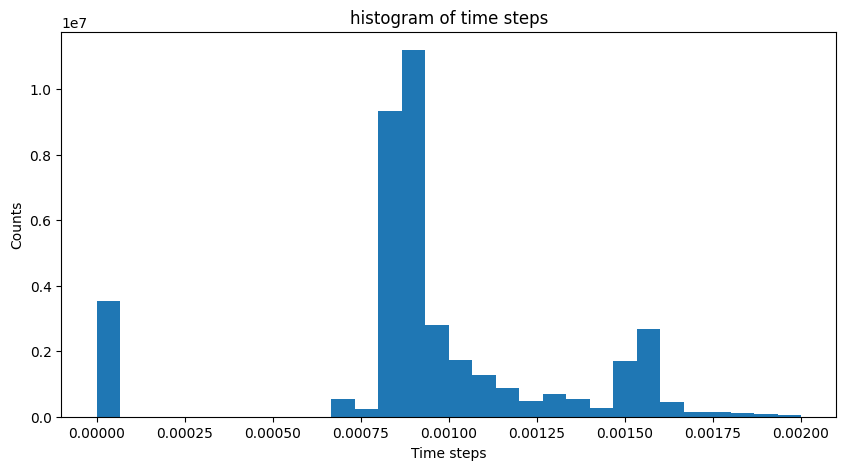

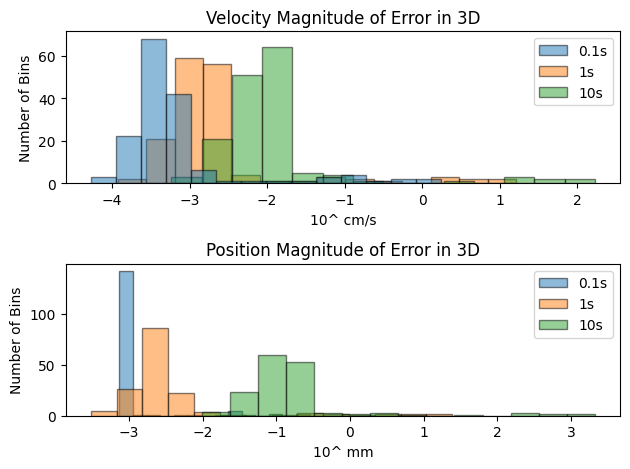

84.94307647103489 % of data does not have zero as its time
RMS ax: 0.060171792291144374
RMS ay: 0.994571867984155
RMS az: 0.10450234315105385
1.003622055053711
1.0030183792114258
1.0037577152252197


In [27]:
def get_file_names_in_folder(folder_path):
    try:
        # Get a list of all file names in the folder
        file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return file_names
    except OSError as e:
        print(f"Error: {e}")
        return []

# Replace 'folder_path' with the actual path of the folder you want to list files from
folder_path = 'output_12_1/Accelerometer'
file_names_list = get_file_names_in_folder(folder_path)

if file_names_list:
    #print("List of file names in the folder:")
    for file_name in file_names_list:
        print(file_name)
else:
    print("No files found in the folder.")
    
print("Total files analyzed:",len(file_name_list))

# file_names_list=np.array(file_names_list)

# file_names_list = file_names_list.astype(int)

# file_names_list 


axx =[]
ayy =[]
azz =[]

axalllist=[]

fsslist =[]
tlist=[]
timealllist=[]
timezerodatalist=[]

psdax_list =[]
psday_list=[]
psdaz_list =[]

ssdax_list =[]
ssday_list=[]
ssdaz_list =[]

fxlist =[]
fylist =[]
fzlist =[]

vxx =[]
vyy =[]
vzz =[]

dxx =[]
dyy=[]
dzz=[]

verr01 =[]
verr1 =[]
verr10 = []

derr01 =[]
derr1=[]
derr10 =[]

vstatss01 =[]
vstatss1 =[]
vstatss10 = []

dstatss01 =[]
dstatss1 =[]
dstatss10 =[]

mean_timespanlist=[]
mean_samplinglist=[]



def read_file(file):
    data = []
    while True:
        try:
            bin_dat = file.read(20)
            if not bin_dat:
                break
            raw_dat = struct.unpack("<diii", bin_dat)
            data += [struct.unpack("<diii", bin_dat)]
        except Exception as e:
            print(e)
            print("got error reading data, returned processed data")
            return data
    return data

for i in file_names_list:

    with open(folder_path+'/'+i, "rb") as f:
        
        temp = 0
        data = read_file(f)
        time = []
        timezerodata=[]
        timeall =[]
        axall=[]
        ax = []
        ay = []
        az = []
        for line in data:
            timeall += [line[0]]
            axall += [line[1]*16.384 * 2 / 2**20] 
            if line[0] !=0:
                time += [line[0]]

                ax += [line[1]*2.048 * 2 / 2**20] 
                ay += [line[2]*2.048 * 2 / 2**20] 
                az += [line[3]*2.048 * 2 / 2**20]  
            else:
                timezerodata +=[line[0]]


    time_span = np.diff(time)
    mean_time_span = np.mean(time_span)
    fss = 1/ time_span
    mean_fss = np.mean(fss)
    
    

    # print("mean dt :", mean_time_span," s")
    # print("mean sampling rate :",mean_fss, "Hz")
    # print("total samples",len(time))



    fs= mean_fss # Hz
    win = 2048

    fx,psdax = signal.welch(ax,fs,nperseg=win)
    fy,psday = signal.welch(ay,fs,nperseg=win)
    fz,psdaz = signal.welch(az,fs,nperseg=win)


    ax_mean = np.mean(ax)
    ay_mean = np.mean(ay)
    az_mean = np.mean(az)

    ax_avg = az - ax_mean
    ay_avg = ay - ay_mean
    az_avg = az - az_mean

    # create empty lists to put data in for 0.1s 
    vx01 = []
    vy01 = []
    vz01 = []

    dx01 = []
    dy01 = []
    dz01 = []

    # 1s
    vx1 = []
    vy1 = []
    vz1 = []

    dx1 = []
    dy1 = []
    dz1 = []

    # 10s
    vx10 = []
    vy10 = []
    vz10 = []

    dx10 = []
    dy10 = []
    dz10 = []

    t = time
    x = ax
    y = ay 
    z = az 


    t01 = np.where(t == 101)  # where t = 0.1s
    t1 = np.where(t == 1002)
    t10 = np.where(t == 10000)

    xmean = np.mean(ax)
    ymean = np.mean(ay)
    zmean = np.mean(az)

    xavg = x-xmean
    xshape = np.reshape(xavg,len(xavg))
    yavg = y-ymean
    yshape = np.reshape(yavg,len(yavg))
    zavg = z-zmean
    zshape = np.reshape(zavg,(len(zavg)))
    tshape = np.reshape(t, len(t))

    vx = np.array(1/1000 * integrate.cumtrapz(xshape, initial=1))   # integrate over 1 ms
    vy = np.array(1/1000 * integrate.cumtrapz(yshape, initial=1))
    vz = np.array(1/1000 * integrate.cumtrapz(zshape, initial=1))   # same length array as t

    dx = np.array(1/1000 * integrate.cumtrapz(vx, initial=1))
    dy = np.array(1/1000 * integrate.cumtrapz(vy, initial=1))
    dz = np.array(1/1000 * integrate.cumtrapz(vz, initial=1))  

    vx01.append(vx[32])   # list value where t=0.1
    vy01.append(vy[32])
    vz01.append(vz[32])

    dx01.append(dx[32])
    dy01.append(dy[32])
    dz01.append(dz[32])

    vx1.append(vx[297])  # where t=1
    vy1.append(vy[297])
    vz1.append(vz[297])

    dx1.append(dx[297])
    dy1.append(dy[297])
    dz1.append(dz[297])

    vx10.append(vx[2764])  # where t=10
    vy10.append(vy[2764])
    vz10.append(vz[2764])

    dx10.append(dx[2764])
    dy10.append(dy[2764])
    dz10.append(dz[2764])


    # convert to arrays
    # 0.1 s
    vxarr01 = np.array(np.abs(vx01))
    vyarr01 = np.array(np.abs(vy01))
    vzarr01 = np.array(np.abs(vz01))

    dxarr01 = np.array(np.abs(dx01))
    dyarr01 = np.array(np.abs(dy01))
    dzarr01 = np.array(np.abs(dz01))

    # 1s
    vxarr1 = np.array(np.abs(vx1))
    vyarr1 = np.array(np.abs(vy1))
    vzarr1 = np.array(np.abs(vz1))

    dxarr1 = np.array(np.abs(dx1))
    dyarr1 = np.array(np.abs(dy1))
    dzarr1 = np.array(np.abs(dz1))

    # 10 s
    vxarr10 = np.array(np.abs(vx10))
    vyarr10 = np.array(np.abs(vy10))
    vzarr10 = np.array(np.abs(vz10))

    dxarr10 = np.array(np.abs(dx10))
    dyarr10 = np.array(np.abs(dy10))
    dzarr10 = np.array(np.abs(dz10))


    # magnitude of error at 0.1s
    mag_errv01 = np.sqrt((vxarr01*100)**2 + (vyarr01*100)**2 + (vzarr01*100)**2)  # cm/s
    mag_errd01 = np.sqrt((dxarr01*1000)**2 + (dyarr01*1000)**2 + (dzarr01*1000)**2)  # mm

    # magnitude of error at 1 s
    mag_errv1 = np.sqrt((vxarr1*100)**2 + (vyarr1*100)**2 + (vzarr1*100)**2)  # cm/s
    mag_errd1 = np.sqrt((dxarr1*1000)**2 + (dyarr1*1000)**2 + (dzarr1*1000)**2)  # mm

    # magnitude of error at 10 s
    mag_errv10 = np.sqrt((vxarr10*100)**2 + (vyarr10*100)**2 + (vzarr10*100)**2)  # cm/s
    mag_errd10 = np.sqrt((dxarr10*1000)**2 + (dyarr10*1000)**2 + (dzarr10*1000)**2)  # mm


    # # log transform data to evenly distribute
    # fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

    log_verr01 = np.log10(mag_errv01)
    log_verr1 = np.log10(mag_errv1)
    log_verr10 = np.log10(mag_errv10)

    log_derr01 = np.log10(mag_errd01)
    log_derr1 = np.log10(mag_errd1)
    log_derr10 = np.log10(mag_errd10)

    
# #----------------------------------------appending all dara----------------------------    
    
    fsslist.append(fss)
    
    axx.append(ax)
    ayy.append(ay)
    azz.append(az)
    tlist.append(time)
    timealllist.append(timeall)
    timezerodatalist.append(timezerodata)
    
    mean_timespanlist.append(mean_time_span)
    mean_samplinglist.append(mean_fss)

    
    axalllist.append(axall)

    psdax_list.append(psdax)
    psday_list.append(psday)
    psdaz_list.append(psdaz)
    
    # ssdax_list.append(Sxx)
    # ssday_list.append(Syy)
    # ssdaz_list.append(Szz)

    fxlist.append(fx)
    fylist.append(fy)
    fzlist.append(fy)

    vxx.append(vx)
    vyy.append(vy)
    vzz.append(vz)

    dxx.append(dx)
    dyy.append(dy)
    dzz.append(dz)

    verr01.append(log_verr01)
    verr1.append(log_verr1)
    verr10.append(log_verr10)

    derr01.append(log_derr01)
    derr1.append(log_derr1)
    derr10.append(log_derr10)

#     vstatss01.append(vstats01)
#     vstatss1.append(vstats1)
#     vstatss10.append(vstats10)

#     dstatss01.append(pstats01)
#     dstatss1.append(pstats1)
#     dstatss10.append(pstats10)
    
#-------------------------------------list flatenning and array mods-----------------------------    
    
def flatten_list(nested_list):
    flattened_list = []
    for item in nested_list:
        if isinstance(item, list):
            flattened_list.extend(flatten_list(item))
        else:
            flattened_list.append(item)
    return flattened_list

axx = flatten_list(axx)
ayy = flatten_list(ayy)
azz = flatten_list(azz)

#fsslist = flatten_list(fsslist)

psdax_list = np.array(psdax_list)
psday_list = np.array(psday_list)
psdaz_list = np.array(psdaz_list)

verr01= flatten_list(verr01)


def flatten_arrays_list(arrays_list):
    flattened_list = np.concatenate(arrays_list).ravel()
    return flattened_list

fsslist = flatten_arrays_list(fsslist)
timealllist= flatten_arrays_list(timealllist)
tlist = flatten_arrays_list(tlist)

axalllist = flatten_arrays_list(axalllist)
timezerodatalist = flatten_arrays_list(timezerodatalist)


verr01 = flatten_arrays_list(verr01)
verr1 = flatten_arrays_list(verr1)
verr10 = flatten_arrays_list(verr10)

derr01 = flatten_arrays_list(derr01)
derr1 = flatten_arrays_list(derr1)
derr10 = flatten_arrays_list(derr10)

dxx = flatten_arrays_list(dxx)
dyy = flatten_arrays_list(dyy)
dzz = flatten_arrays_list(dzz)


# mean_timespanlist = flatten_arrays_list(mean_timespanlist)
# mean_samplinglist = flatten_arrays_list(mean_timespanlist)

#-------------------------------plotting data--------------------------------


print("The mean dt for the whole data",np.mean(mean_timespanlist))
print("The mean sampling rate for the whole data",np.mean(mean_samplinglist))

fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker accelerometer readings',size=18)

axs[0].plot(axx,color = 'blue')
axs[0].set_title("Ax")


axs[1].plot(ayy,color = 'black')
axs[1].set_title("Ay")

axs[2].plot(azz,color = 'red')
axs[2].set_title("Az")

axs[1].set_xlabel('Samples',size=14)
axs[0].set_ylabel(r'acceleration ($m/s^2$)',size=14)


plt.savefig("accelerometer_ax_ay_az.png",dpi="figure")
plt.show()



fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker position reconstruction',size=18)

axs[0].plot(dxx,color = 'blue')
axs[0].set_title("Dx")


axs[1].plot(dyy,color = 'black')
axs[1].set_title("Dy")

axs[2].plot(dzz,color = 'red')
axs[2].set_title("Dz")

axs[1].set_xlabel('Samples',size=14)
axs[0].set_ylabel(r'Displacement ($m$)',size=14)


plt.savefig("accelerometer_disp.png",dpi="figure")
plt.show()



fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker accelerometer ASD readings',size=18)

ps1=axs[0].imshow(psdax_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[0].set_title("Ax")
cb1=fig.colorbar(ps1)
cb1.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

ps2=axs[1].imshow(psday_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[1].set_title("Ay")
cb2=fig.colorbar(ps2)
cb2.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

ps3=axs[2].imshow(psdaz_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[2].set_title("Az")
cb3=fig.colorbar(ps3)
cb3.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

axs[0].set_ylabel('Frequency',size=15)
axs[1].set_xlabel('time streams(5 min chunks)',size=15)


plt.savefig("accelerometer_asd.png",dpi="figure")
plt.show()


plt.title("Samling rate histogram without a zero in timestamps")
plt.xlabel("sampling frequency(Hz)")
plt.ylabel("counts")
plt.hist(fsslist,bins=30)
plt.show()

plt.figure(figsize=(10,5))
plt.title("histogram of time steps")
plt.hist(np.diff(timealllist),range=[0, 0.002],bins=30)
plt.ylabel("Counts")
plt.xlabel("Time steps")
plt.savefig("accelerometer_hist_dt.png",dpi="figure")

plt.show()

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

# velocity magnitude of error
n1, bins01, patches = ax1.hist(verr01, bins=14, label='0.1s',alpha=0.5,zorder=5, histtype='bar', ec='black')
n2, bins1, patches = ax1.hist(verr1, bins=14, label='1s',alpha=0.5, histtype='bar', ec='black')
n3, bins10, patches = ax1.hist(verr10, bins=14, label='10s',alpha=0.5, histtype='bar', ec='black')
ax1.legend()
ax1.set_xscale('linear')
ax1.set_ylabel('Number of Bins')
ax1.set_title('Velocity Magnitude of Error in 3D')
ax1.set_xlabel('10^ cm/s')

nd1, binsd01, patchesd = ax2.hist(derr01, bins=14, label='0.1s',alpha=0.5, histtype='bar', ec='black')
nd2, binsd1, patchesd = ax2.hist(derr1, bins=14, label='1s',alpha=0.5, histtype='bar', ec='black')
nd3, binsd10, patchesd = ax2.hist(derr10, bins=14, label='10s',alpha=0.5, histtype='bar', ec='black')
ax2.legend()
ax2.set_xlabel('10^ mm')
ax2.set_ylabel('Number of Bins')
ax2.set_title('Position Magnitude of Error in 3D')
ax2.set_xscale('linear')

bin_centers = 0.5*(bins01[1:]+bins01[:-1])
sqrtn1 = np.sqrt(n1)

plt.tight_layout()

plt.savefig("accelerometer_vel_disp_errstats.png",dpi="figure")

plt.show()

# plt.title("Variation of the Sampling rate")
# plt.plot(fsslist)
# plt.ylabel("Sampling frequency")
# plt.xlabel("samples")
# plt.show()

print(len(tlist)/len(timealllist) *100,"% of data does not have zero as its time")


def calculate_rms(accel_data):
    squared_data = np.square(accel_data)
    mean_squared = np.mean(squared_data)
    rms_value = np.sqrt(mean_squared)
    return rms_value

axx_rms = calculate_rms(axx)
ayy_rms = calculate_rms(ayy)
azz_rms = calculate_rms(azz)

print("RMS ax:",axx_rms)
print("RMS ay:",ayy_rms)
print("RMS az:",azz_rms)

print(timealllist[2000]-timealllist[1000])
print(timealllist[3000]-timealllist[2000])
print(timealllist[4000]-timealllist[3000])

List of file names in the folder:
1691852536
1691852236
mean dt : 0.0011992353141350271  s
mean sampling rate : 963.553209234617 Hz
total samples 40730
mean dt : 0.0011832943833501944  s
mean sampling rate : 975.8464525062251 Hz
total samples 253692


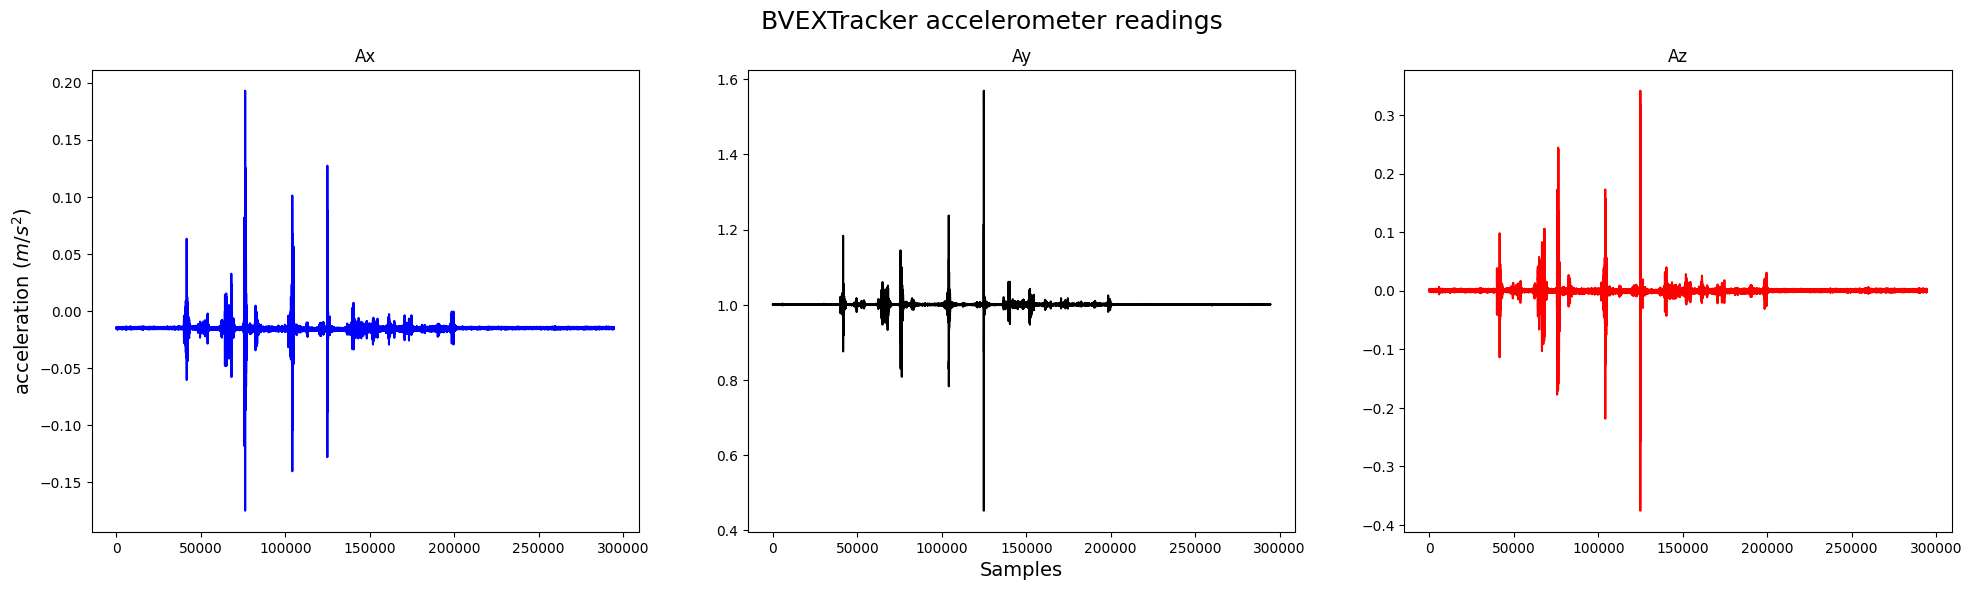

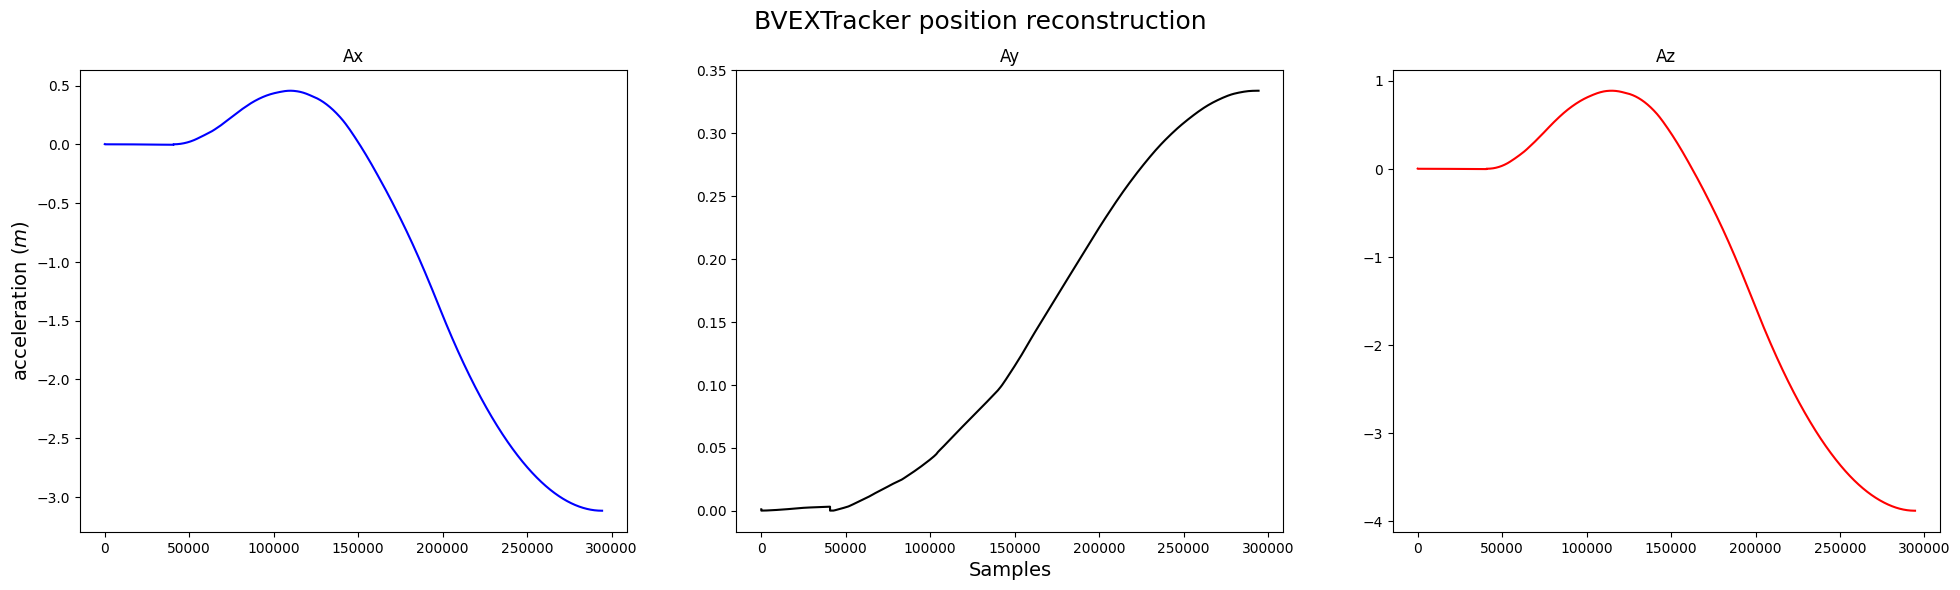

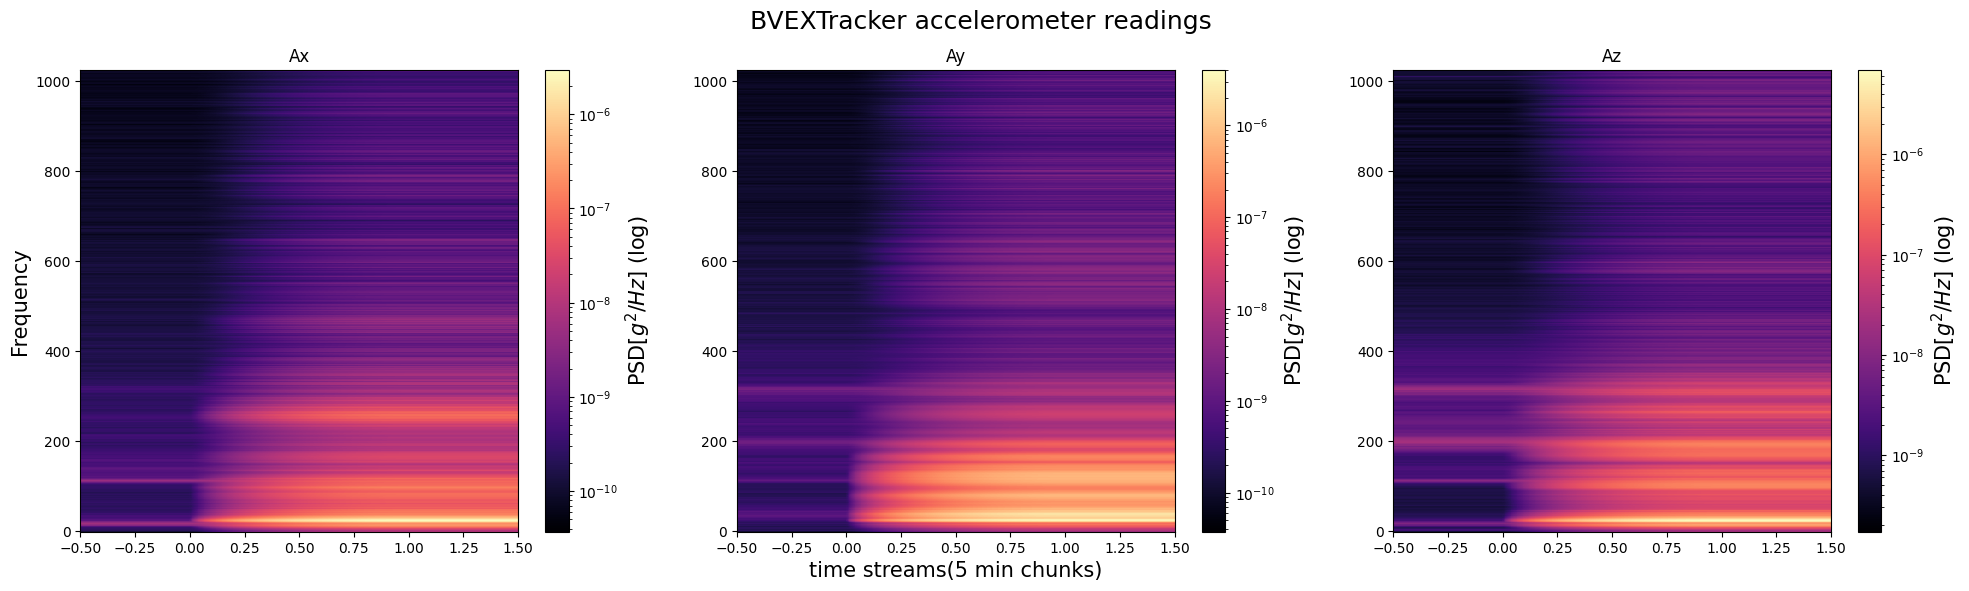

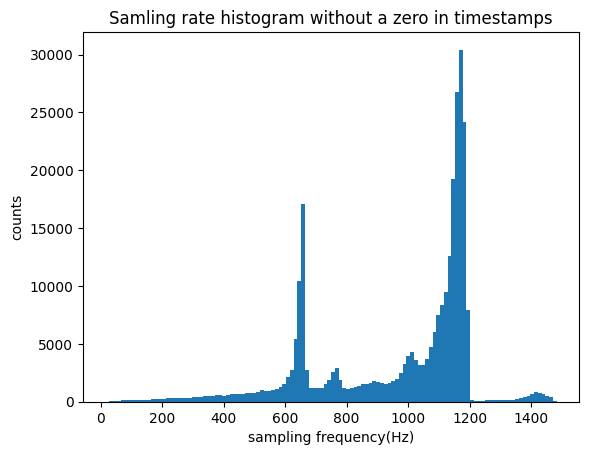

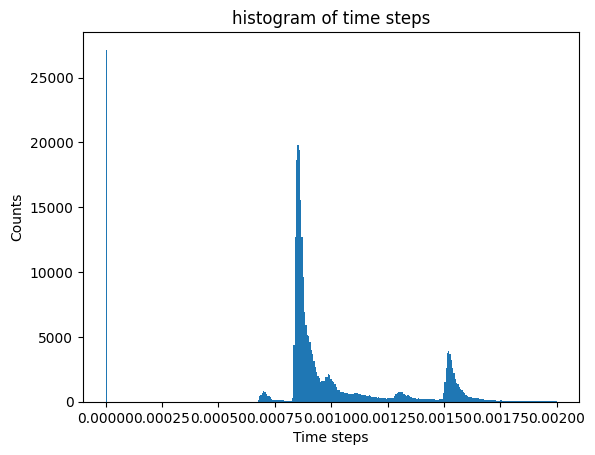

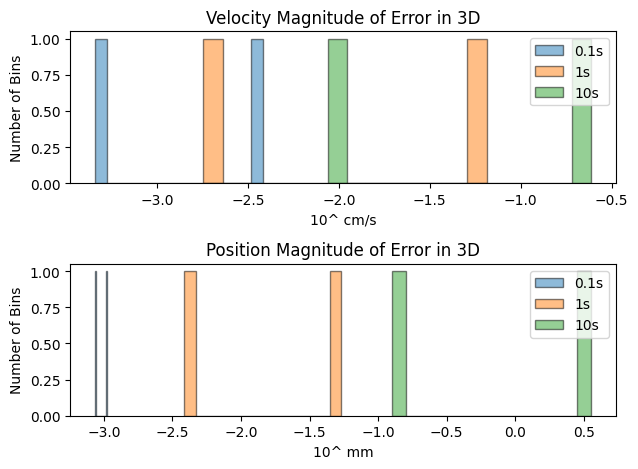

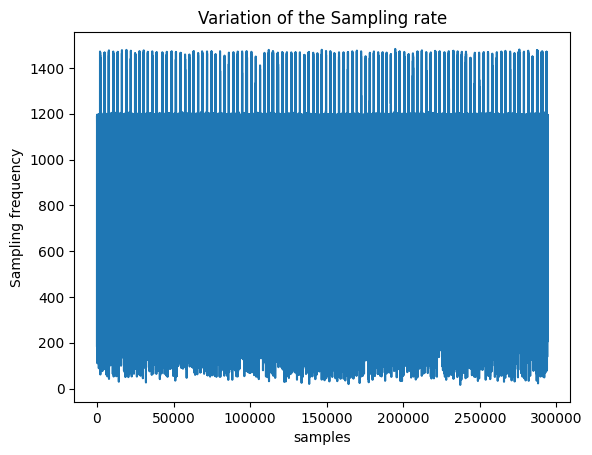

84.6088855681361 % of data does not have zero as its time
RMS ax: 0.015897944102800106
RMS ay: 1.0006853003907794
RMS az: 0.006325852617192853
1.0031647682189941
1.0035862922668457
1.0031218528747559


In [117]:
def get_file_names_in_folder(folder_path):
    try:
        # Get a list of all file names in the folder
        file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return file_names
    except OSError as e:
        print(f"Error: {e}")
        return []

# Replace 'folder_path' with the actual path of the folder you want to list files from
folder_path = 'output_12_7/Accelerometer'
file_names_list = get_file_names_in_folder(folder_path)

if file_names_list:
    print("List of file names in the folder:")
    for file_name in file_names_list:
        print(file_name)
else:
    print("No files found in the folder.")

# file_names_list=np.array(file_names_list)

# file_names_list = file_names_list.astype(int)

# file_names_list 


axx =[]
ayy =[]
azz =[]

axalllist=[]

fsslist =[]
tlist=[]
timealllist=[]
timezerodatalist=[]

psdax_list =[]
psday_list=[]
psdaz_list =[]

ssdax_list =[]
ssday_list=[]
ssdaz_list =[]

fxlist =[]
fylist =[]
fzlist =[]

vxx =[]
vyy =[]
vzz =[]

dxx =[]
dyy=[]
dzz=[]

verr01 =[]
verr1 =[]
verr10 = []

derr01 =[]
derr1=[]
derr10 =[]

vstatss01 =[]
vstatss1 =[]
vstatss10 = []

dstatss01 =[]
dstatss1 =[]
dstatss10 =[]



def read_file(file):
    data = []
    while True:
        try:
            bin_dat = file.read(20)
            if not bin_dat:
                break
            raw_dat = struct.unpack("<diii", bin_dat)
            data += [struct.unpack("<diii", bin_dat)]
        except Exception as e:
            print(e)
            print("got error reading data, returned processed data")
            return data
    return data

for i in file_names_list:

    with open(folder_path+'/'+i, "rb") as f:
        
        temp = 0
        data = read_file(f)
        time = []
        timezerodata=[]
        timeall =[]
        axall=[]
        ax = []
        ay = []
        az = []
        for line in data:
            timeall += [line[0]]
            axall += [line[1]*16.384 * 2 / 2**20] 
            if line[0] !=0:
                time += [line[0]]

                ax += [line[1]*2.048 * 2 / 2**20] 
                ay += [line[2]*2.048 * 2 / 2**20] 
                az += [line[3]*2.048 * 2 / 2**20]  
            else:
                timezerodata +=[line[0]]


    time_span = np.diff(time)
    mean_time_span = np.mean(time_span)
    fss = 1/ time_span
    mean_fss = np.mean(fss)

    print("mean dt :", mean_time_span," s")
    print("mean sampling rate :",mean_fss, "Hz")
    print("total samples",len(time))



    fs= mean_fss # Hz
    win = 2048

    fx,psdax = signal.welch(ax,fs,nperseg=win)
    fy,psday = signal.welch(ay,fs,nperseg=win)
    fz,psdaz = signal.welch(az,fs,nperseg=win)


    ax_mean = np.mean(ax)
    ay_mean = np.mean(ay)
    az_mean = np.mean(az)

    ax_avg = az - ax_mean
    ay_avg = ay - ay_mean
    az_avg = az - az_mean

    # create empty lists to put data in for 0.1s 
    vx01 = []
    vy01 = []
    vz01 = []

    dx01 = []
    dy01 = []
    dz01 = []

    # 1s
    vx1 = []
    vy1 = []
    vz1 = []

    dx1 = []
    dy1 = []
    dz1 = []

    # 10s
    vx10 = []
    vy10 = []
    vz10 = []

    dx10 = []
    dy10 = []
    dz10 = []

    t = time
    x = ax
    y = ay 
    z = az 


    t01 = np.where(t == 101)  # where t = 0.1s
    t1 = np.where(t == 1002)
    t10 = np.where(t == 10000)

    xmean = np.mean(ax)
    ymean = np.mean(ay)
    zmean = np.mean(az)

    xavg = x-xmean
    xshape = np.reshape(xavg,len(xavg))
    yavg = y-ymean
    yshape = np.reshape(yavg,len(yavg))
    zavg = z-zmean
    zshape = np.reshape(zavg,(len(zavg)))
    tshape = np.reshape(t, len(t))

    vx = np.array(1/1000 * integrate.cumtrapz(xshape, initial=1))   # integrate over 1 ms
    vy = np.array(1/1000 * integrate.cumtrapz(yshape, initial=1))
    vz = np.array(1/1000 * integrate.cumtrapz(zshape, initial=1))   # same length array as t

    dx = np.array(1/1000 * integrate.cumtrapz(vx, initial=1))
    dy = np.array(1/1000 * integrate.cumtrapz(vy, initial=1))
    dz = np.array(1/1000 * integrate.cumtrapz(vz, initial=1))  

    vx01.append(vx[32])   # list value where t=0.1
    vy01.append(vy[32])
    vz01.append(vz[32])

    dx01.append(dx[32])
    dy01.append(dy[32])
    dz01.append(dz[32])

    vx1.append(vx[297])  # where t=1
    vy1.append(vy[297])
    vz1.append(vz[297])

    dx1.append(dx[297])
    dy1.append(dy[297])
    dz1.append(dz[297])

    vx10.append(vx[2875])  # where t=10
    vy10.append(vy[2875])
    vz10.append(vz[2875])

    dx10.append(dx[2875])
    dy10.append(dy[2875])
    dz10.append(dz[2875])


    # convert to arrays
    # 0.1 s
    vxarr01 = np.array(np.abs(vx01))
    vyarr01 = np.array(np.abs(vy01))
    vzarr01 = np.array(np.abs(vz01))

    dxarr01 = np.array(np.abs(dx01))
    dyarr01 = np.array(np.abs(dy01))
    dzarr01 = np.array(np.abs(dz01))

    # 1s
    vxarr1 = np.array(np.abs(vx1))
    vyarr1 = np.array(np.abs(vy1))
    vzarr1 = np.array(np.abs(vz1))

    dxarr1 = np.array(np.abs(dx1))
    dyarr1 = np.array(np.abs(dy1))
    dzarr1 = np.array(np.abs(dz1))

    # 10 s
    vxarr10 = np.array(np.abs(vx10))
    vyarr10 = np.array(np.abs(vy10))
    vzarr10 = np.array(np.abs(vz10))

    dxarr10 = np.array(np.abs(dx10))
    dyarr10 = np.array(np.abs(dy10))
    dzarr10 = np.array(np.abs(dz10))


    # magnitude of error at 0.1s
    mag_errv01 = np.sqrt((vxarr01*100)**2 + (vyarr01*100)**2 + (vzarr01*100)**2)  # cm/s
    mag_errd01 = np.sqrt((dxarr01*1000)**2 + (dyarr01*1000)**2 + (dzarr01*1000)**2)  # mm

    # magnitude of error at 1 s
    mag_errv1 = np.sqrt((vxarr1*100)**2 + (vyarr1*100)**2 + (vzarr1*100)**2)  # cm/s
    mag_errd1 = np.sqrt((dxarr1*1000)**2 + (dyarr1*1000)**2 + (dzarr1*1000)**2)  # mm

    # magnitude of error at 10 s
    mag_errv10 = np.sqrt((vxarr10*100)**2 + (vyarr10*100)**2 + (vzarr10*100)**2)  # cm/s
    mag_errd10 = np.sqrt((dxarr10*1000)**2 + (dyarr10*1000)**2 + (dzarr10*1000)**2)  # mm


    # # log transform data to evenly distribute
    # fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

    log_verr01 = np.log10(mag_errv01)
    log_verr1 = np.log10(mag_errv1)
    log_verr10 = np.log10(mag_errv10)

    log_derr01 = np.log10(mag_errd01)
    log_derr1 = np.log10(mag_errd1)
    log_derr10 = np.log10(mag_errd10)

    
# #----------------------------------------appending all dara----------------------------    
    
    fsslist.append(fss)
    
    axx.append(ax)
    ayy.append(ay)
    azz.append(az)
    tlist.append(time)
    timealllist.append(timeall)
    timezerodatalist.append(timezerodata)
    
    axalllist.append(axall)

    psdax_list.append(psdax)
    psday_list.append(psday)
    psdaz_list.append(psdaz)
    
    # ssdax_list.append(Sxx)
    # ssday_list.append(Syy)
    # ssdaz_list.append(Szz)

    fxlist.append(fx)
    fylist.append(fy)
    fzlist.append(fy)

    vxx.append(vx)
    vyy.append(vy)
    vzz.append(vz)

    dxx.append(dx)
    dyy.append(dy)
    dzz.append(dz)

    verr01.append(log_verr01)
    verr1.append(log_verr1)
    verr10.append(log_verr10)

    derr01.append(log_derr01)
    derr1.append(log_derr1)
    derr10.append(log_derr10)

#     vstatss01.append(vstats01)
#     vstatss1.append(vstats1)
#     vstatss10.append(vstats10)

#     dstatss01.append(pstats01)
#     dstatss1.append(pstats1)
#     dstatss10.append(pstats10)
    
#-------------------------------------list flatenning and array mods-----------------------------    
    
def flatten_list(nested_list):
    flattened_list = []
    for item in nested_list:
        if isinstance(item, list):
            flattened_list.extend(flatten_list(item))
        else:
            flattened_list.append(item)
    return flattened_list

axx = flatten_list(axx)
ayy = flatten_list(ayy)
azz = flatten_list(azz)

#fsslist = flatten_list(fsslist)

psdax_list = np.array(psdax_list)
psday_list = np.array(psday_list)
psdaz_list = np.array(psdaz_list)

verr01= flatten_list(verr01)


def flatten_arrays_list(arrays_list):
    flattened_list = np.concatenate(arrays_list).ravel()
    return flattened_list

fsslist = flatten_arrays_list(fsslist)
timealllist= flatten_arrays_list(timealllist)
tlist = flatten_arrays_list(tlist)

axalllist = flatten_arrays_list(axalllist)
timezerodatalist = flatten_arrays_list(timezerodatalist)


verr01 = flatten_arrays_list(verr01)
verr1 = flatten_arrays_list(verr1)
verr10 = flatten_arrays_list(verr10)

derr01 = flatten_arrays_list(derr01)
derr1 = flatten_arrays_list(derr1)
derr10 = flatten_arrays_list(derr10)

dxx = flatten_arrays_list(dxx)
dyy = flatten_arrays_list(dyy)
dzz = flatten_arrays_list(dzz)


#-------------------------------plotting data--------------------------------

fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker accelerometer readings',size=18)

axs[0].plot(axx,color = 'blue')
axs[0].set_title("Ax")


axs[1].plot(ayy,color = 'black')
axs[1].set_title("Ay")

axs[2].plot(azz,color = 'red')
axs[2].set_title("Az")

axs[1].set_xlabel('Samples',size=14)
axs[0].set_ylabel(r'acceleration ($m/s^2$)',size=14)


#plt.savefig("imuasd.png",dpi="figure")
plt.show()



fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker position reconstruction',size=18)

axs[0].plot(dxx,color = 'blue')
axs[0].set_title("Ax")


axs[1].plot(dyy,color = 'black')
axs[1].set_title("Ay")

axs[2].plot(dzz,color = 'red')
axs[2].set_title("Az")

axs[1].set_xlabel('Samples',size=14)
axs[0].set_ylabel(r'acceleration ($m$)',size=14)


#plt.savefig("imuasd.png",dpi="figure")
plt.show()



fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker accelerometer readings',size=18)

ps1=axs[0].imshow(psdax_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[0].set_title("Ax")
cb1=fig.colorbar(ps1)
cb1.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

ps2=axs[1].imshow(psday_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[1].set_title("Ay")
cb2=fig.colorbar(ps2)
cb2.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

ps3=axs[2].imshow(psdaz_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[2].set_title("Az")
cb3=fig.colorbar(ps3)
cb3.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

axs[0].set_ylabel('Frequency',size=15)
axs[1].set_xlabel('time streams(5 min chunks)',size=15)


#plt.savefig("imuasd.png",dpi="figure")
plt.show()


plt.title("Samling rate histogram without a zero in timestamps")
plt.xlabel("sampling frequency(Hz)")
plt.ylabel("counts")
plt.hist(fsslist,bins="auto")
plt.show()

plt.title("histogram of time steps")
plt.hist(np.diff(timealllist),range=[0, 0.002],bins="auto")
plt.ylabel("Counts")
plt.xlabel("Time steps")
plt.show()

fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

# velocity magnitude of error
n1, bins01, patches = ax1.hist(verr01, bins=14, label='0.1s',alpha=0.5,zorder=5, histtype='bar', ec='black')
n2, bins1, patches = ax1.hist(verr1, bins=14, label='1s',alpha=0.5, histtype='bar', ec='black')
n3, bins10, patches = ax1.hist(verr10, bins=14, label='10s',alpha=0.5, histtype='bar', ec='black')
ax1.legend()
ax1.set_xscale('linear')
ax1.set_ylabel('Number of Bins')
ax1.set_title('Velocity Magnitude of Error in 3D')
ax1.set_xlabel('10^ cm/s')

nd1, binsd01, patchesd = ax2.hist(derr01, bins=14, label='0.1s',alpha=0.5, histtype='bar', ec='black')
nd2, binsd1, patchesd = ax2.hist(derr1, bins=14, label='1s',alpha=0.5, histtype='bar', ec='black')
nd3, binsd10, patchesd = ax2.hist(derr10, bins=14, label='10s',alpha=0.5, histtype='bar', ec='black')
ax2.legend()
ax2.set_xlabel('10^ mm')
ax2.set_ylabel('Number of Bins')
ax2.set_title('Position Magnitude of Error in 3D')
ax2.set_xscale('linear')

bin_centers = 0.5*(bins01[1:]+bins01[:-1])
sqrtn1 = np.sqrt(n1)

plt.tight_layout()

plt.show()

plt.title("Variation of the Sampling rate")
plt.plot(fsslist)
plt.ylabel("Sampling frequency")
plt.xlabel("samples")
plt.show()

print(len(tlist)/len(timealllist) *100,"% of data does not have zero as its time")


def calculate_rms(accel_data):
    squared_data = np.square(accel_data)
    mean_squared = np.mean(squared_data)
    rms_value = np.sqrt(mean_squared)
    return rms_value

axx_rms = calculate_rms(axx)
ayy_rms = calculate_rms(ayy)
azz_rms = calculate_rms(azz)

print("RMS ax:",axx_rms)
print("RMS ay:",ayy_rms)
print("RMS az:",azz_rms)

print(timealllist[2000]-timealllist[1000])
print(timealllist[3000]-timealllist[2000])
print(timealllist[4000]-timealllist[3000])

In [116]:
psdax_list.flatten()

array([5.94664589e-09, 3.45160246e-08, 3.26801491e-08, ...,
       2.00973406e-09, 1.51916763e-09, 6.31285658e-10])

In [17]:
# pn1 = 20*np.log((0.8e-9*np.sqrt(2*psdax_list[0])*10e6)/2*1)
# plt.plot(pn)

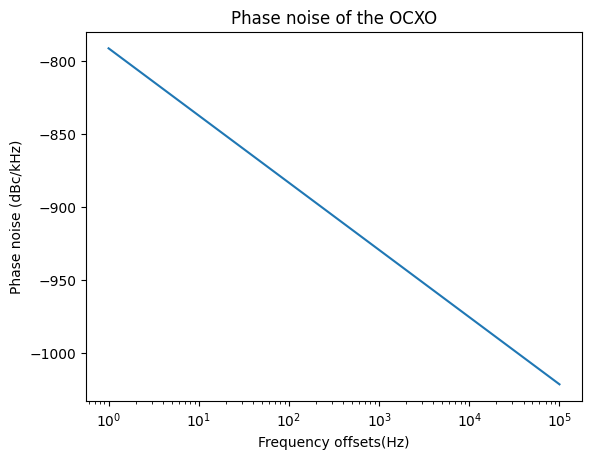

In [18]:
pn = 20*np.log((0.8e-9*np.sqrt(2*psdax_list[0])*10e6)/(2*freqlist))
plt.plot(freqlist,pn)
plt.title("Phase noise of the OCXO")
plt.xlabel("Frequency offsets(Hz)")
plt.ylabel("Phase noise (dBc/kHz)")
plt.xscale("log")

### Gyro test

List of file names in the folder:
1691852536
1691852236
mean dt : 0.005082397535249784  s
mean sampling rate : 198.34740212844218 Hz
total samples 9626
mean dt : 0.005094659457948041  s
mean sampling rate : 197.80082786918564 Hz
total samples 58921


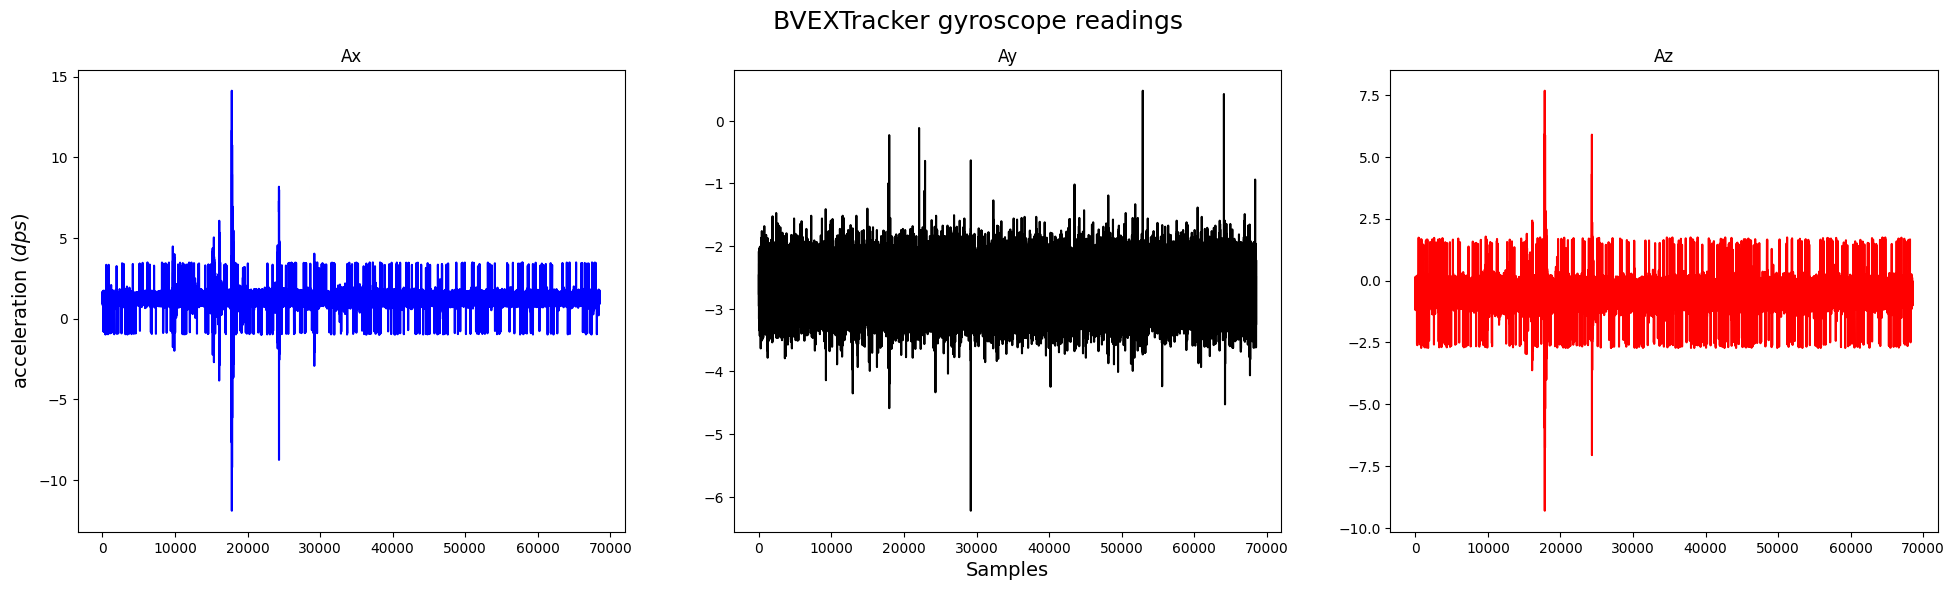

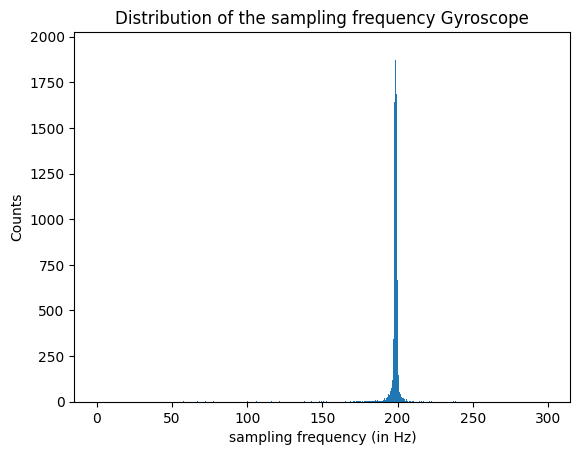

In [118]:
def get_file_names_in_folder(folder_path):
    try:
        # Get a list of all file names in the folder
        file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return file_names
    except OSError as e:
        print(f"Error: {e}")
        return []

# Replace 'folder_path' with the actual path of the folder you want to list files from
folder_path = 'output_12_7/Gyroscope/'
file_names_list = get_file_names_in_folder(folder_path)

if file_names_list:
    print("List of file names in the folder:")
    for file_name in file_names_list:
        print(file_name)
else:
    print("No files found in the folder.")

# file_names_list=np.array(file_names_list)

# file_names_list = file_names_list.astype(int)

# file_names_list 


axx =[]
ayy =[]
azz =[]

fsslist =[]

psdax_list =[]
psday_list=[]
psdaz_list =[]

ssdax_list =[]
ssday_list=[]
ssdaz_list =[]

fxlist =[]
fylist =[]
fzlist =[]

def read_file(file):
    data = []
    while True:
        try:
            bin_dat = file.read(14)
            if not bin_dat:
                break
            raw_dat = struct.unpack("<dHHH", bin_dat)
            data += [struct.unpack("<dHHH", bin_dat)]
        except Exception as e:
            print(e)
            print("got error reading data, returned processed data")
            #return data
    return data

for i in file_names_list:

    with open(folder_path+'/'+i, "rb") as f:
        temp = 0
        data = read_file(f)
        time = []
        ax = []
        ay = []
        az = []
        for line in data:
            time += [line[0]]
            
            ax += [np.int16(line[1])*0.00875+ 1.25617] #degrees per second
            ay += [np.int16(line[2])*0.00875- 1.65475] 
            az += [np.int16(line[3])*0.00875- 0.48935]   


    time_span = np.diff(time)
    mean_time_span = np.mean(time_span)
    fss = 1/ time_span
    mean_fss = np.mean(fss)

    print("mean dt :", mean_time_span," s")
    print("mean sampling rate :",mean_fss, "Hz")
    print("total samples",len(time))


    fs= mean_fss # Hz
    win = 2048

    fx,psdax = signal.welch(ax,fs,nperseg=win)
    fy,psday = signal.welch(ay,fs,nperseg=win)
    fz,psdaz = signal.welch(az,fs,nperseg=win)


#----------------------------------------appending all dara----------------------------    
    
    fsslist.append(fss)
    
    axx.append(ax)
    ayy.append(ay)
    azz.append(az)

    psdax_list.append(psdax)
    psday_list.append(psday)
    psdaz_list.append(psdaz)
    
    # ssdax_list.append(Sxx)
    # ssday_list.append(Syy)
    # ssdaz_list.append(Szz)

    fxlist.append(fx)
    fylist.append(fy)
    fzlist.append(fy)
    
#-------------------------------------list flatenning and array mods-----------------------------    
    
def flatten_list(nested_list):
    flattened_list = []
    for item in nested_list:
        if isinstance(item, list):
            flattened_list.extend(flatten_list(item))
        else:
            flattened_list.append(item)
    return flattened_list

axx = flatten_list(axx)
ayy = flatten_list(ayy)
azz = flatten_list(azz)

#fsslist = flatten_list(fsslist)

# psdax_list = np.array(psdax_list)
# psday_list = np.array(psday_list)
# psdaz_list = np.array(psdaz_list)

#verr01= flatten_list(verr01)


def flatten_arrays_list(arrays_list):
    flattened_list = np.concatenate(arrays_list).ravel()
    return flattened_list

fsslist = flatten_arrays_list(fsslist)
psdax_list = flatten_arrays_list(psdax_list)
psday_list = flatten_arrays_list(psday_list)
psdaz_list = flatten_arrays_list(psdaz_list)


# verr01 = flatten_arrays_list(verr01)
# verr1 = flatten_arrays_list(verr1)
# verr10 = flatten_arrays_list(verr10)

# derr01 = flatten_arrays_list(derr01)
# derr1 = flatten_arrays_list(derr1)
# derr10 = flatten_arrays_list(derr10)

#-------------------------------plotting data--------------------------------

fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker gyroscope readings',size=18)

axs[0].plot(axx,color = 'blue')
axs[0].set_title("Ax")


axs[1].plot(ayy,color = 'black')
axs[1].set_title("Ay")

axs[2].plot(azz,color = 'red')
axs[2].set_title("Az")

axs[1].set_xlabel('Samples',size=14)
axs[0].set_ylabel(r'acceleration ($dps$)',size=14)


#plt.savefig("imuasd.png",dpi="figure")
plt.show()


# fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
# fig.suptitle('BVEXTracker gyroscope readings',size=18)

# ps1=axs[0].imshow(psdax_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
# axs[0].set_title("Ax")
# cb1=fig.colorbar(ps1)
# cb1.set_label(label='PSD[$dps^2/Hz$] (log)', size='15')

# ps2=axs[1].imshow(psday_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
# axs[1].set_title("Ay")
# cb2=fig.colorbar(ps2)
# cb2.set_label(label='PSD[$dps^2/Hz$] (log)', size='15')

# ps3=axs[2].imshow(psdaz_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
# axs[2].set_title("Az")
# cb3=fig.colorbar(ps3)
# cb3.set_label(label='PSD[$dps^2/Hz$] (log)', size='15')

# axs[0].set_ylabel('Frequency',size=15)
# axs[1].set_xlabel('time streams(5 min chunks)',size=15)


# #plt.savefig("imuasd.png",dpi="figure")
# plt.show()


# plt.title("Samling rate histogram")
# plt.xlabel("sampling frequency(Hz)")
# plt.ylabel("counts")
# plt.hist(fsslist,bins=50)
# plt.show()

# plt.title("Variation of the Sampling rate")
# plt.plot(fsslist)
# plt.ylabel("Sampling frequency")
# plt.xlabel("samples")
# plt.show()


plt.hist(fsslist,range=[0,300],bins="auto")
plt.title("Distribution of the sampling frequency Gyroscope")
plt.xlabel("sampling frequency (in Hz)")
plt.ylabel("Counts")
plt.show()

In [547]:
# def read_file(f):
#     f.read(8)
#     while True:
#         try:
#             bin_dat = f.read(108)
#                 #print(bin_dat, "\n\n")
#             time_bin_dat = bin_dat[0:8]
#             nav_pvt_bin = bin_dat[8:108]
#             #print(nav_pvt_bin)
#             #print(self.checksum(nav_pvt_bin, 100), int(nav_pvt_bin[-2]), int(nav_pvt_bin[-1]))
#             u = struct.unpack_from('<LHBBBBBBLlBBBBllllLLlllllLLHHHH', nav_pvt_bin[6:90], 0)
#             #print("\n\n")
#             s = ('  iTOW %u time %u/%u/%u %02u:%02u:%02u valid x%x\n'
#                  '  tAcc %u nano %d fixType %u flags x%x flags2 x%x\n'
#                  '  numSV %u lon %d lat %d height %d\n'
#                  '  hMSL %d hAcc %u vAcc %u\n'
#                  '  velN %d velE %d velD %d gSpeed %d headMot %d\n'
#                  '  sAcc %u headAcc %u pDOP %u reserved1 %u %u %u' % u)
#             print(s)
#         except Exception as e:
#             #print(e)
#             break

# #     def checksum(self, msg, m_len):
# #         """Calculate u-blox message checksum"""
# #         # the checksum is calculated over the Message, starting and including
# #         # the CLASS field, up until, but excluding, the Checksum Field:

# #         ck_a = 0
# #         ck_b = 0
# #         for c in msg[0:m_len]:
# #             ck_a += c
# #             ck_b += ck_a

# #         return [ck_a & 0xff, ck_b & 0xff]

# if __name__ == "__main__":
    
#     #with open("/home/fissellab/BVEXTracker/Logs/GpsLog", "a") as log:
#         #test = Gps("output_11_3/i2c_GPS/1691767035", log)
#         with open("output_11_3/i2c_GPS/1691771049", "rb") as f:
#             temp = 0
#             data = read_file(f)
#             time = []
#             itow = []
#             lat = []
#             lon = []
#             for line in data:
#                 time += [line[0]]
            
#                 itow += [line[1]] #degrees per second
#                 lat += [line[2]] 
#                 lon += [line[3]]   


### IMU data

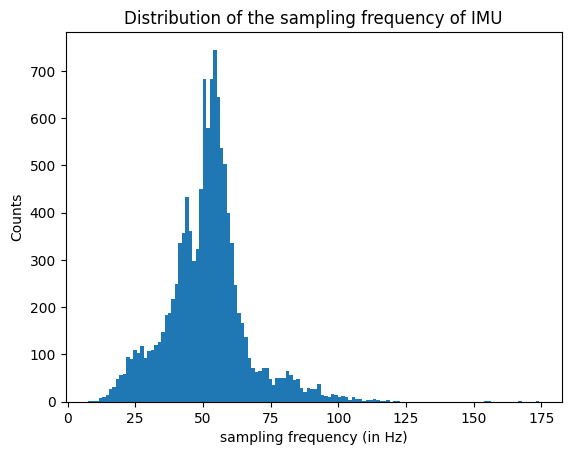

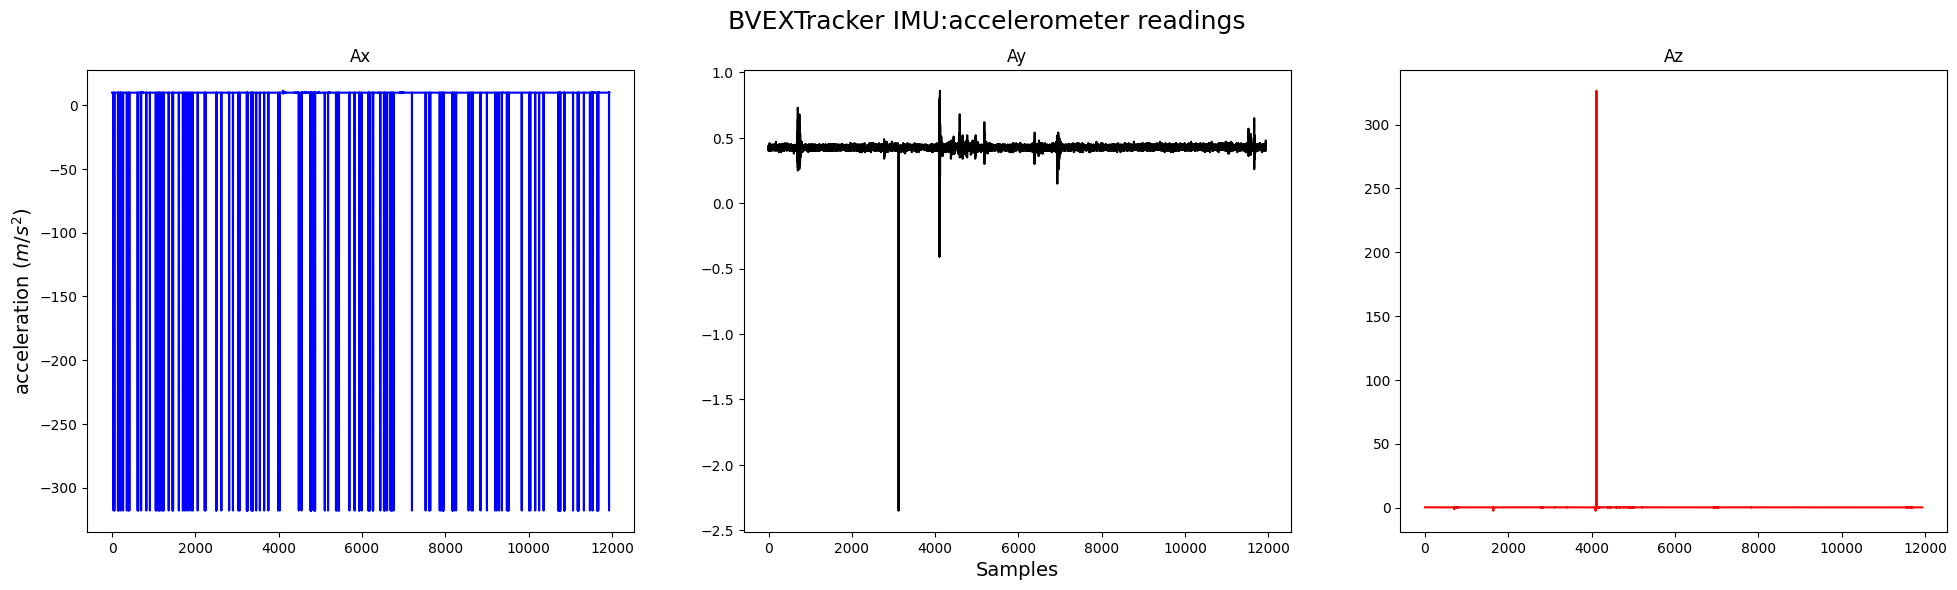

In [167]:
# saving raw data from sensor, these convert numbers to default units
# see data sheet

scales = {
        "acceleration" : 0.01,
        "magnetic" : 0.0625,
        "gyro" : 0.001090830782496456,
        "euler" : 0.0625,
        "quaternion" : (1 / (1<<14)),
        "linear accel" : 0.01,
        "gravity" : 0.01,
        "temperature" : 0.5
        }

def read_file(file):
    data=[]
    while True:
        try:
            temp  = []
            bin_dat = file.read(8)
            temp += struct.unpack("<d", bin_dat)

            bin_dat = file.read(12)
            temp += struct.unpack("<fff", bin_dat)#[i*scales["acceleration"] for i in struct.unpack("<fff", bin_dat)]

            bin_dat = file.read(12)
            temp +=struct.unpack("<fff", bin_dat)#[i*scales["magnetic"] for i in struct.unpack("<fff", bin_dat)]

            bin_dat = file.read(12)
            temp += struct.unpack("<fff", bin_dat)#[i*scales["gyro"] for i in struct.unpack("<fff", bin_dat)]

            bin_dat = file.read(12)
            temp += struct.unpack("<fff", bin_dat) #[i*scales["euler"] for i in struct.unpack("<fff", bin_dat)]
            
            bin_dat = file.read(4)
            temp += struct.unpack("<f", bin_dat) #[i*scales["euler"] for i in struct.unpack("<fff", bin_dat)]

            data += [temp]
        except Exception as e:
            #print(e)
            #print("IMU: got error reading data, returned processed data")
            return data
    return data

with open('output_12_5/IMU/1691852405', "rb") as f:
    temp = 0
    #dataa=[]
    data = read_file(f)
    time = []
    
    ax = [] #m/s^2
    ay = []
    az = []
    
    mx=[]  # uT
    my=[]
    mz=[]
    
    gx=[] #dps
    gy=[]
    gz=[]
    
    roll=[] #degrees
    pitch=[]
    yaw=[]
    
    tempa=[]
       
    for line in data:
        time += [line[0]]

        ax += [line[1]] 
        ay += [line[2]]
        az += [line[3]]   
        
        
        mx += [line[4]] 
        my += [line[5]] 
        mz += [line[6]] 
        
        
        gx += [line[7]] 
        gy += [line[8]] 
        gz += [line[9]] 
        
        roll += [line[10]] 
        pitch += [line[11]] 
        yaw += [line[12]] 
        
        tempa +=[line[13]]
        
fss = 1/np.diff(time)

plt.hist(fss,bins="auto")
plt.title("Distribution of the sampling frequency of IMU")
plt.xlabel("sampling frequency (in Hz)")
plt.ylabel("Counts")
plt.show()

fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker IMU:accelerometer readings',size=18)

axs[0].plot(ax,color = 'blue')
axs[0].set_title("Ax")


axs[1].plot(ay,color = 'black')
axs[1].set_title("Ay")

axs[2].plot(az,color = 'red')
axs[2].set_title("Az")

axs[1].set_xlabel('Samples',size=14)
axs[0].set_ylabel(r'acceleration ($m/s^2$)',size=14)


#plt.savefig("IMU:accelerometer_ax_ay_az.png",dpi="figure")
plt.show()




In [165]:

# # Calculate the mean and standard deviation of the sensor data
# mean = np.mean(sensor_data)
# std_dev = np.std(sensor_data)

# # Set a threshold for outliers (e.g., 3 times the standard deviation)
# z_threshold = 3

# # Identify the indices of outliers
# outlier_indices = np.where(np.abs((sensor_data - mean) / std_dev) > z_threshold)[0]

# # Remove outliers from the sensor data list
# cleaned_sensor_data = [value for idx, value in enumerate(sensor_data) if idx not in outlier_indices]

# # print("Original Sensor Data:", sensor_data)
# # print("Cleaned Sensor Data:", cleaned_sensor_data)

# plt.plot(cleaned_sensor_data)

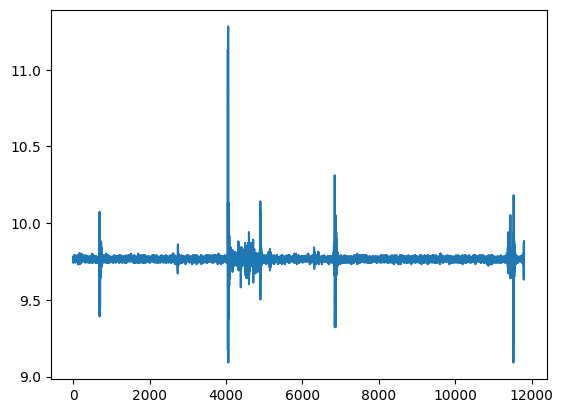

In [177]:

def remove_outliers(sensor_data, z_threshold=3):
    mean = np.mean(sensor_data)
    std_dev = np.std(sensor_data)
    
    # Identify the indices of outliers
    outlier_indices = np.where(np.abs((sensor_data - mean) / std_dev) > z_threshold)[0]
    
    # Remove outliers from the sensor data list using list comprehension
    cleaned_sensor_data = [value for idx, value in enumerate(sensor_data) if idx not in outlier_indices]
    
    return cleaned_sensor_data

# Example sensor data (replace this with your actual sensor data)
sensor_data = ax

cleaned_data = remove_outliers(sensor_data)
# print("Original Sensor Data:", sensor_data)
# print("Cleaned Sensor Data:", cleaned_data)

plt.plot(cleaned_data)

1691852537
1691852237


/var/folders/8g/zw9cjxxx2hz2444l1w_17w640000gn/T/ipykernel_1981/3112549326.py:188: RuntimeWarning: divide by zero encountered in divide
  outlier_indices = np.where(np.abs((sensor_data - mean) / std_dev) > z_threshold)[0]
/var/folders/8g/zw9cjxxx2hz2444l1w_17w640000gn/T/ipykernel_1981/3112549326.py:188: RuntimeWarning: invalid value encountered in divide
  outlier_indices = np.where(np.abs((sensor_data - mean) / std_dev) > z_threshold)[0]


The mean dt for the whole data 0.020805250845443265
The mean sampling rate for the whole data 53.211421839797396


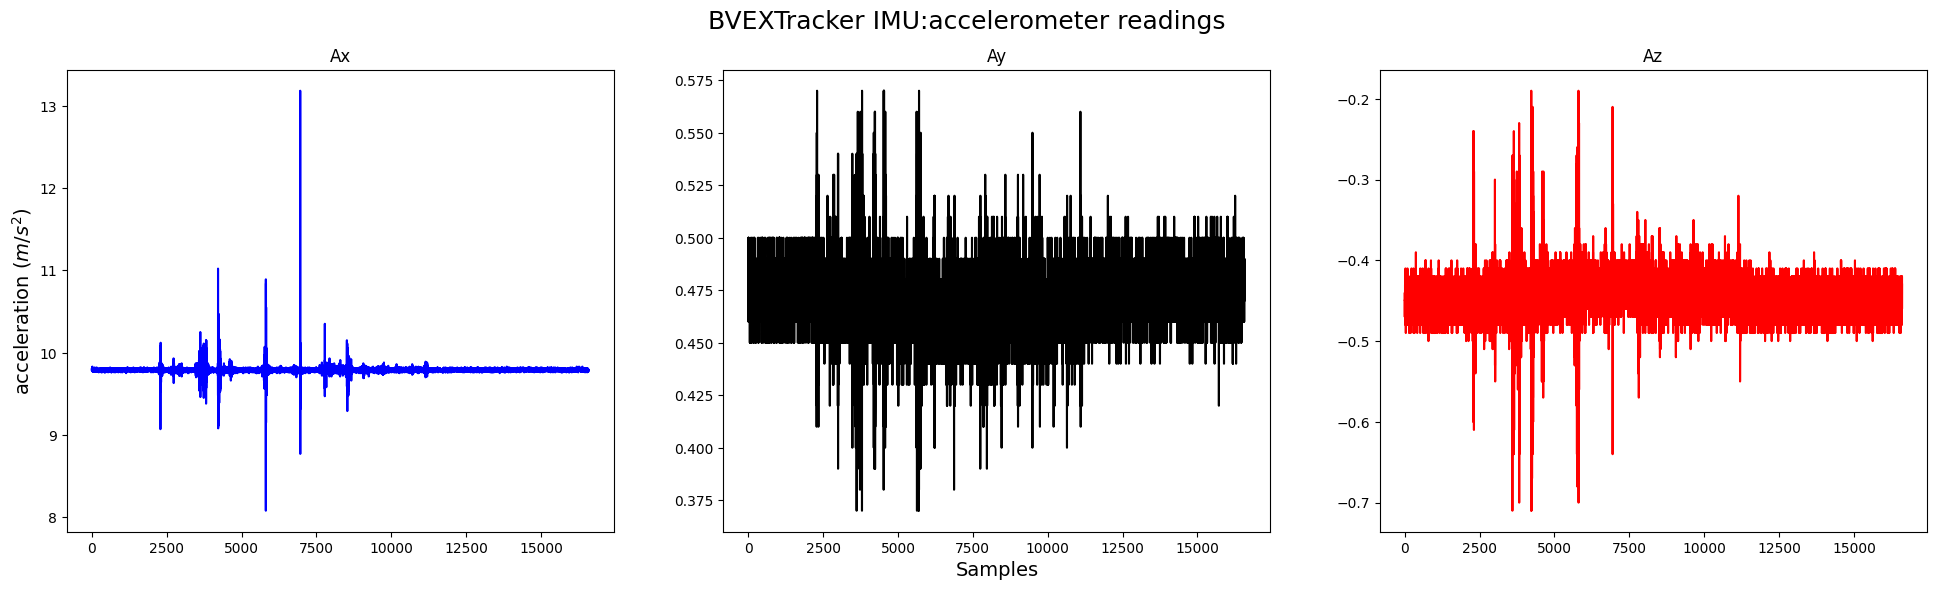

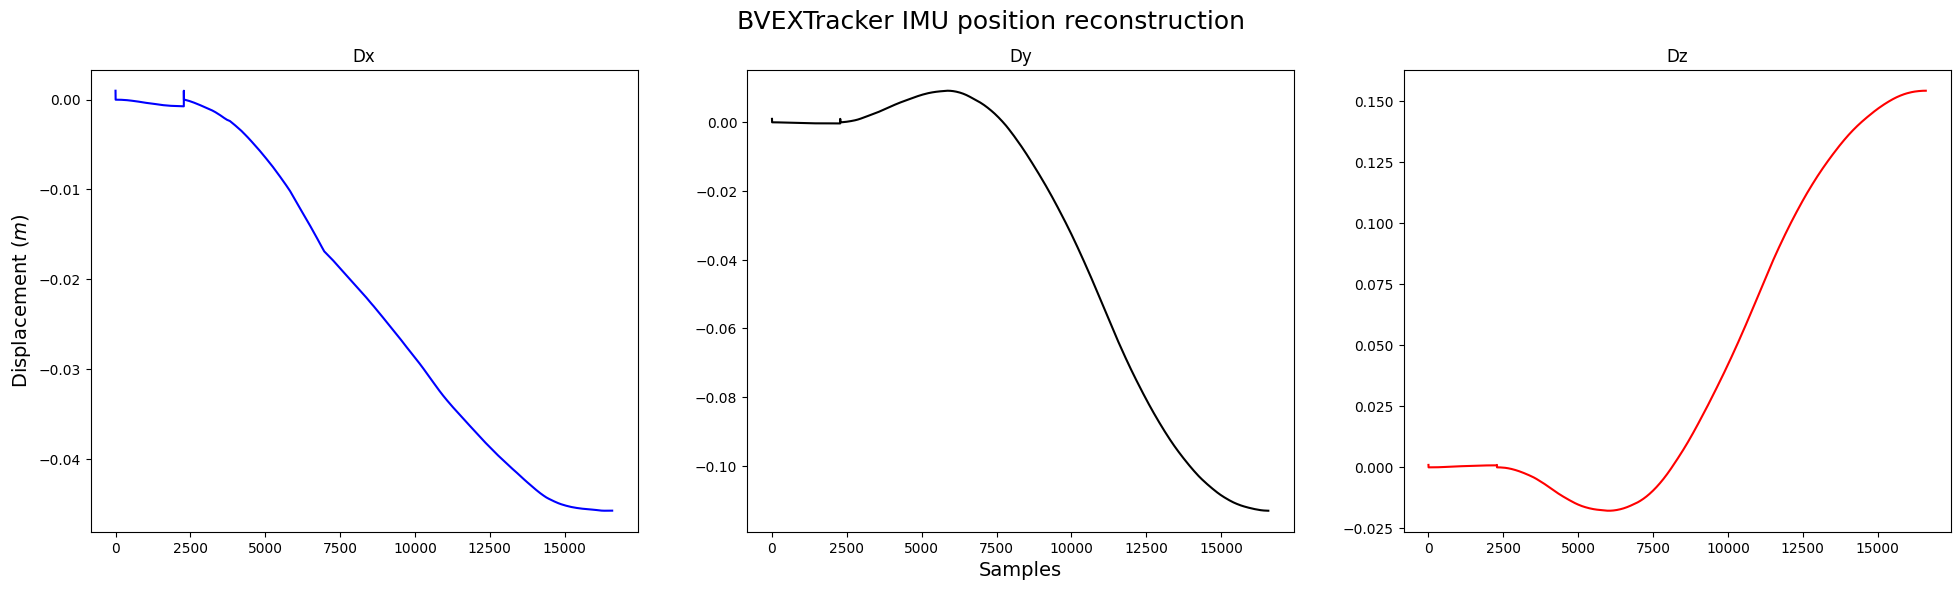

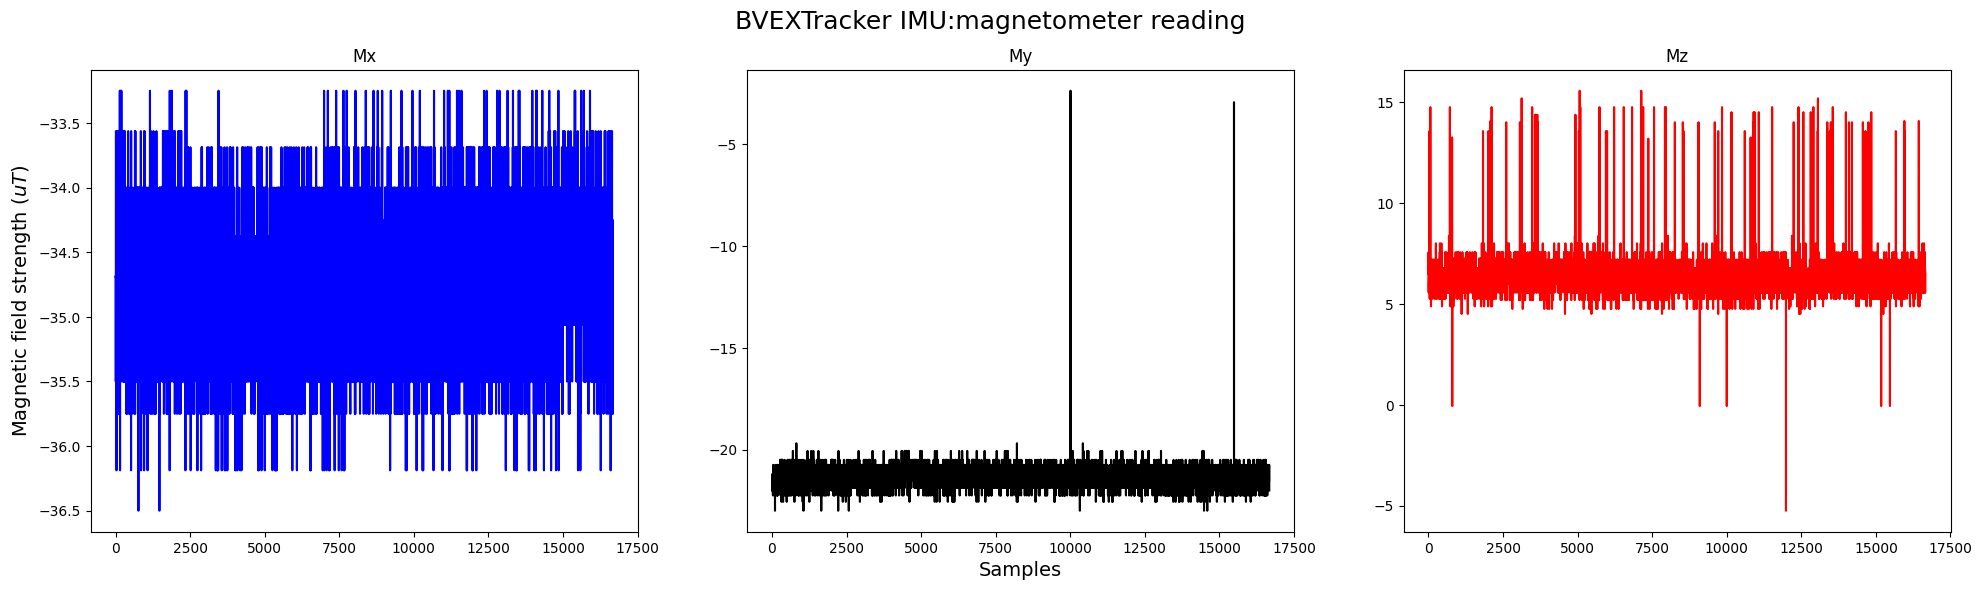

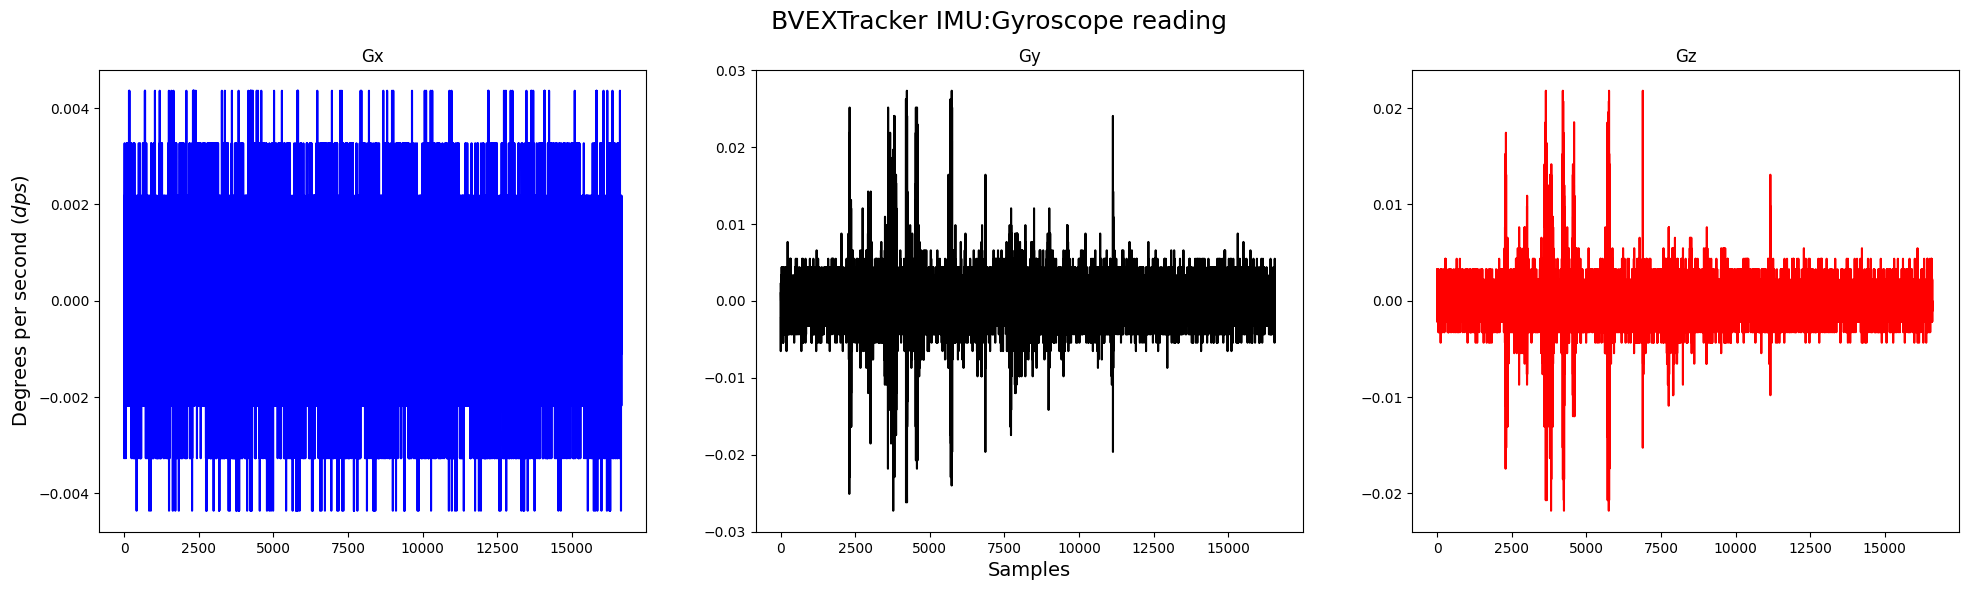

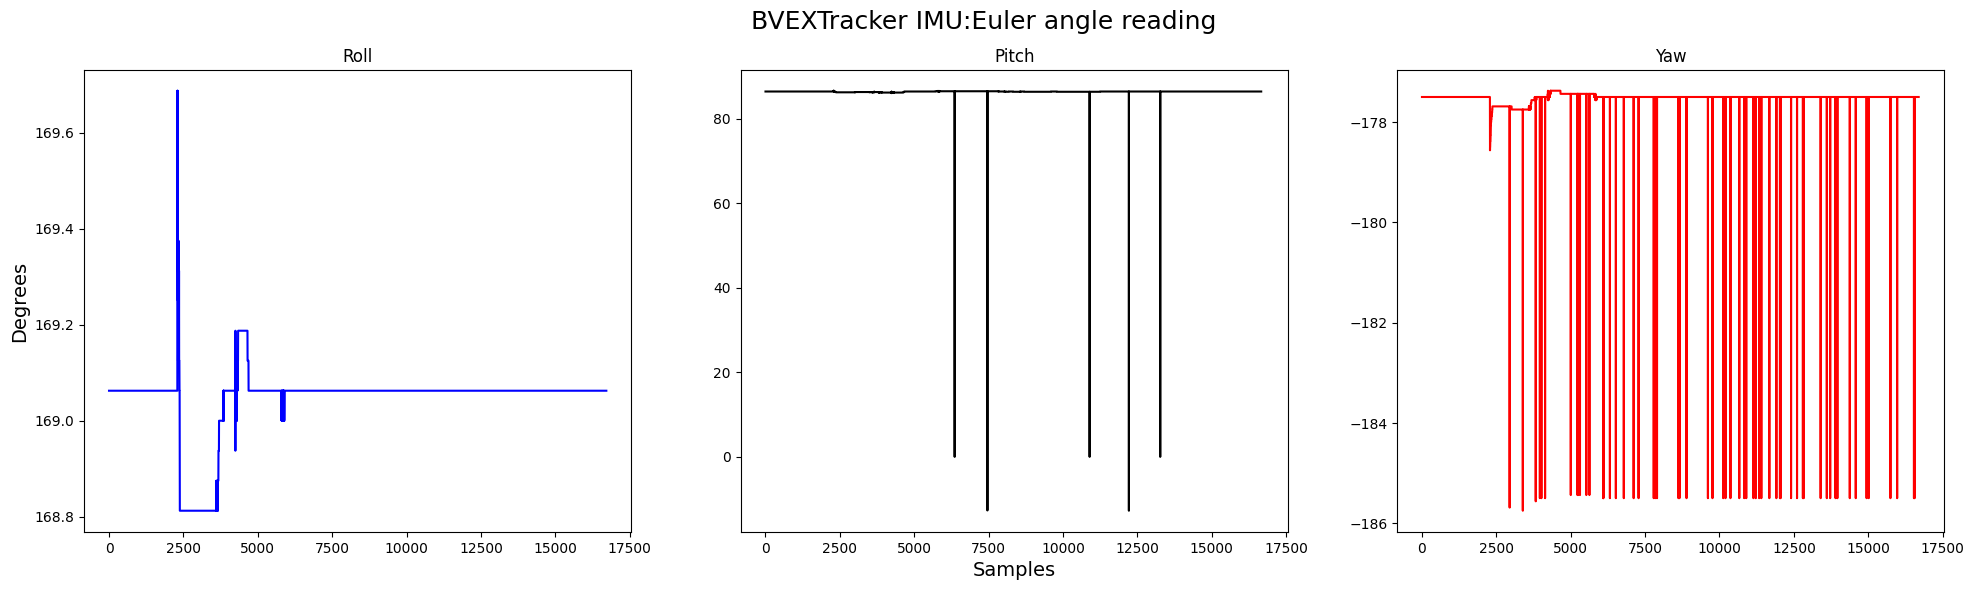

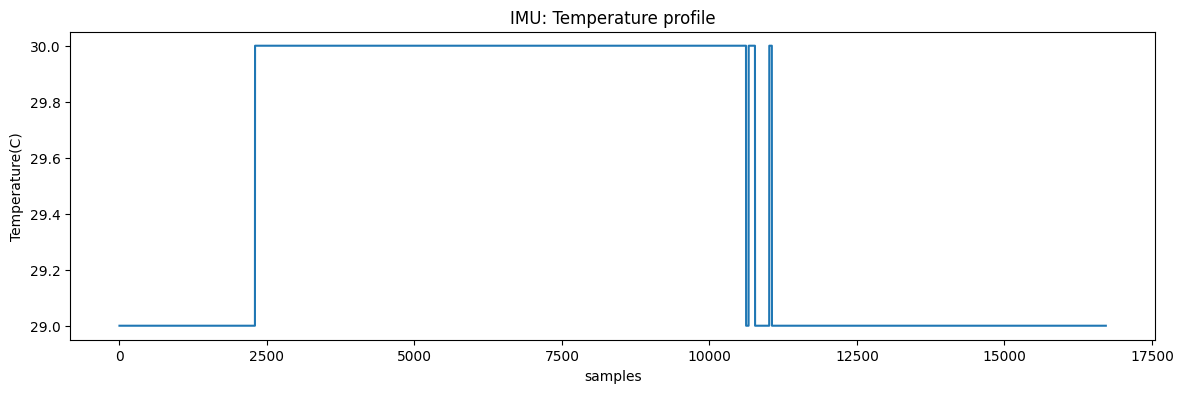

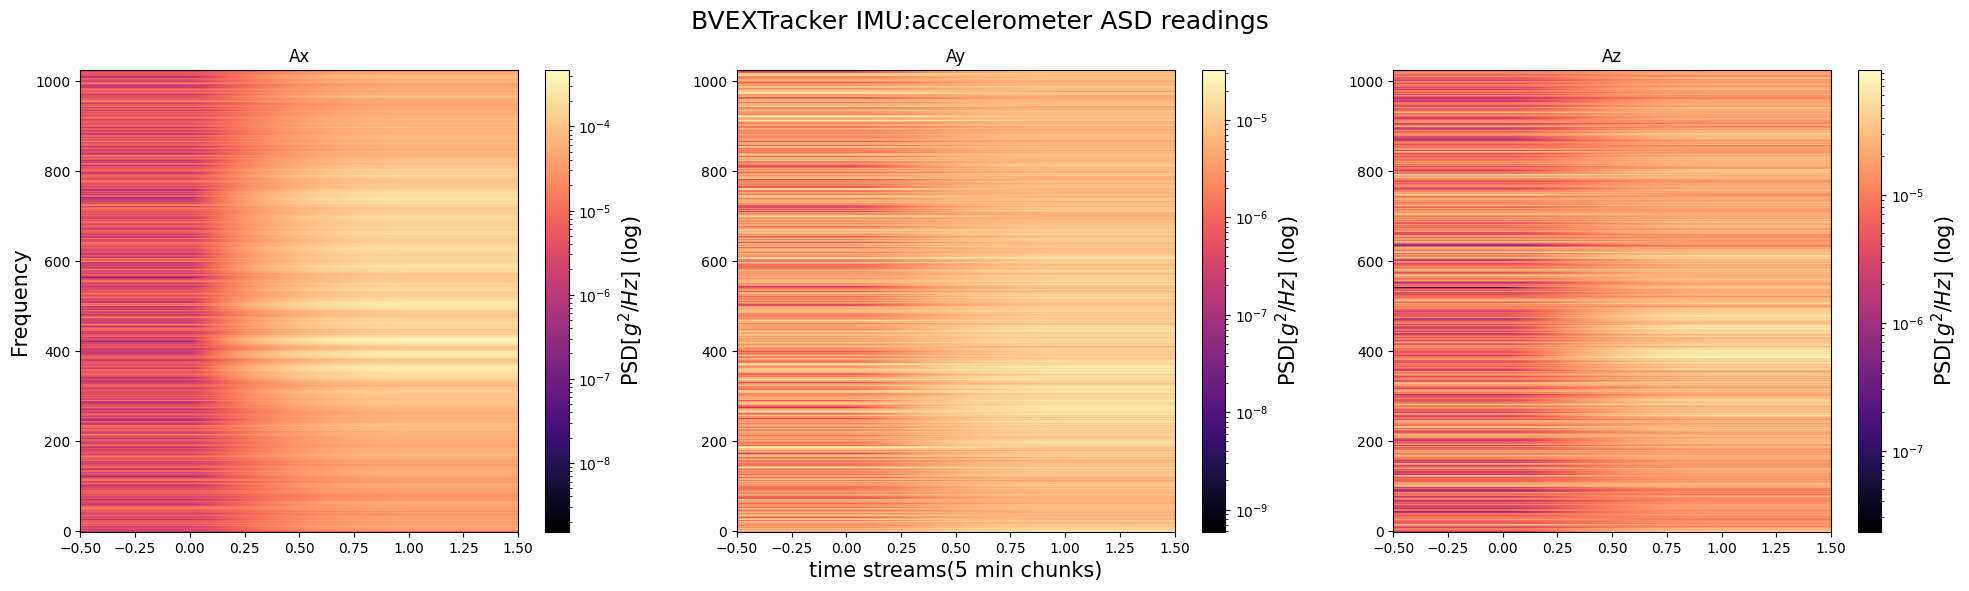

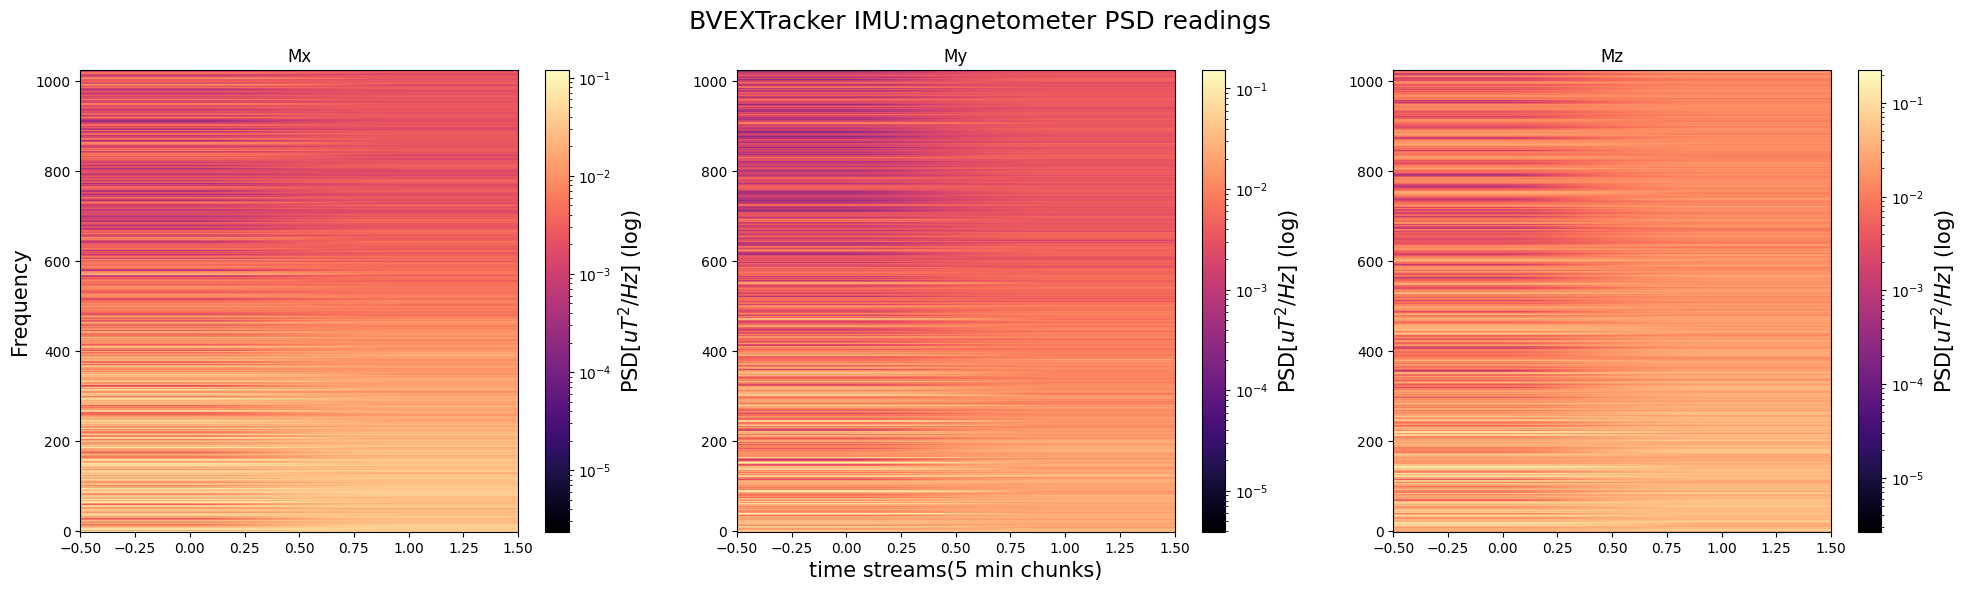

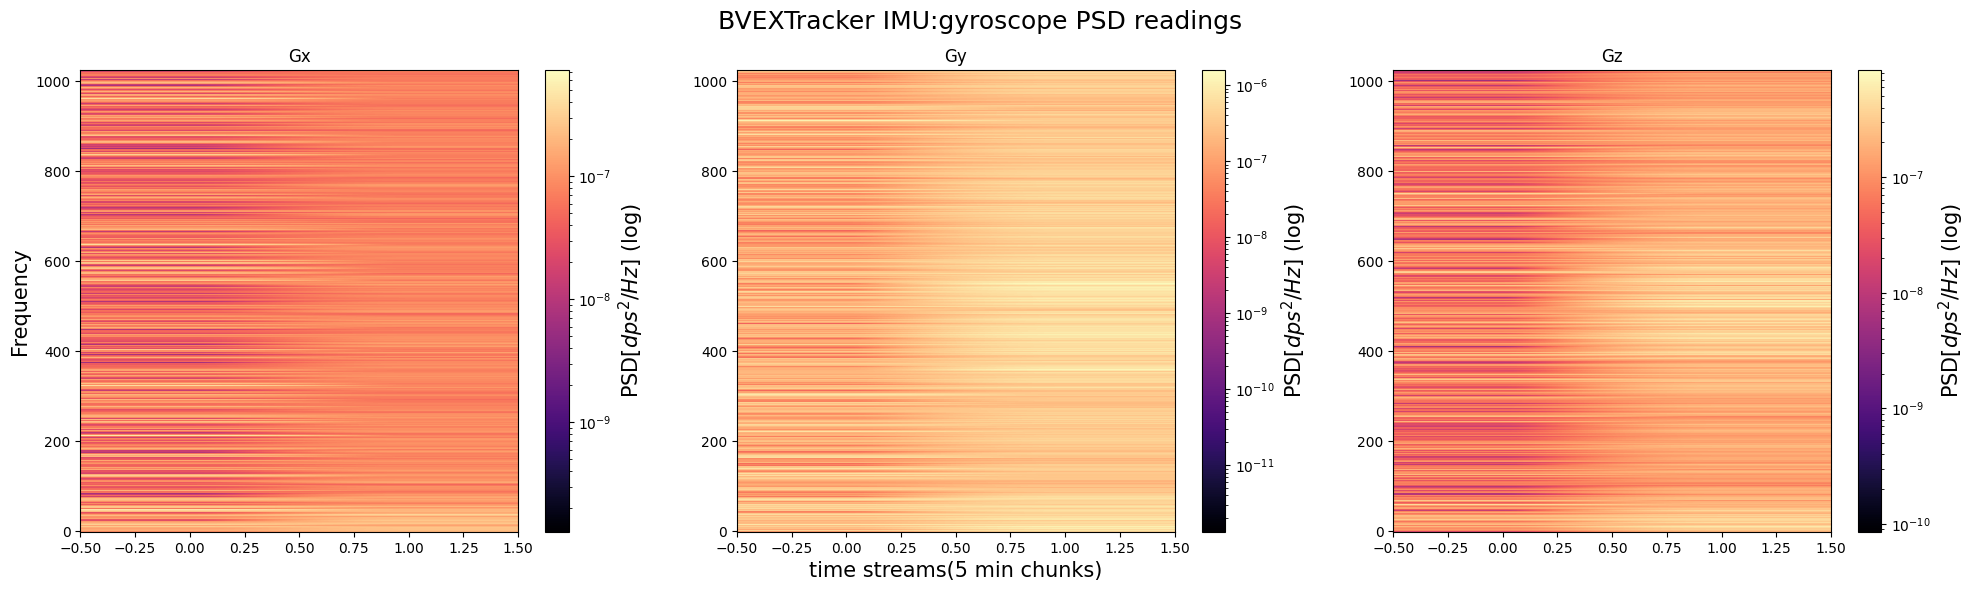

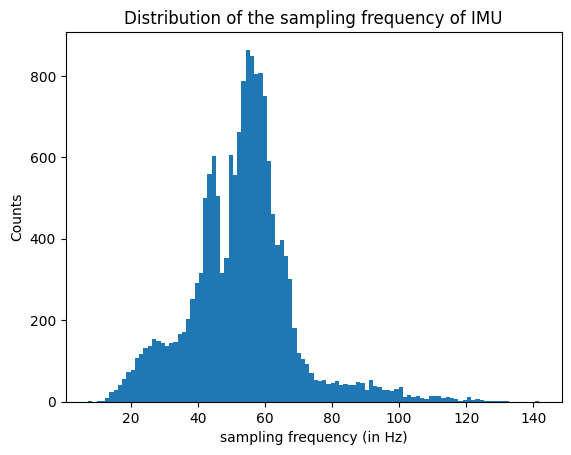

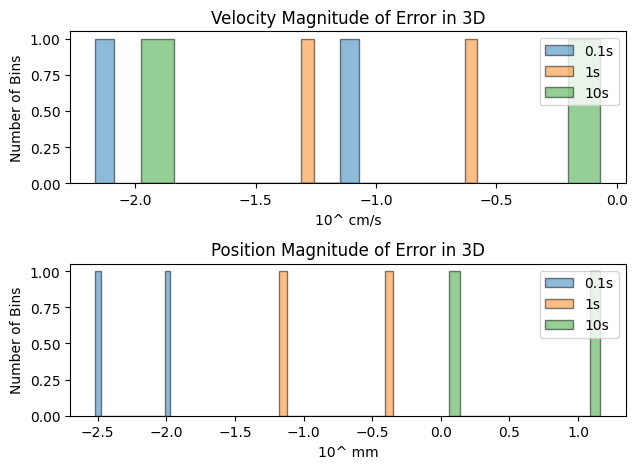

---Accelerometer stats(m/s^2)-------------
RMS ax: 9.791362399024624
RMS ay: 0.47231247703074186
RMS az: 0.44536309515053557
Std dev ax: 0.05223116180280387
median ax: 9.792091369628906
Std dev ay: 0.015710620192427572
median ay: 0.47010040283203125
Std dev az: 0.025893887522392158
median az: -0.440093994140625
---Magnetometer stats(uT)-------------
RMS mx: 34.725146426511806
RMS my: 21.361298587128907
RMS mz: 6.427755430771082
Std dev mx: 0.562475328138604
median mx: -34.6875
Std dev my: 0.5172065699728102
median my: -21.5
Std dev mz: 0.8101659080314397
median mz: 6.375
---Gyroscope stats(dps)-------------
RMS gx: 0.001552510130202921
RMS gy: 0.0033363429635515267
RMS gz: 0.002340916260377881
Std dev gx: 0.001551351678219255
median gx: 0.0
Std dev gy: 0.003336315094580823
median gy: 0.0
Std dev gz: 0.0023407729294486956
median gz: 0.0
---Euler angles stats(degrees)-------------
RMS roll: 169.04576890695978
RMS pitch: 86.39731059276163
RMS yaw: 177.54280371368222
---Temperature stats(C

In [178]:
def get_file_names_in_folder(folder_path):
    try:
        # Get a list of all file names in the folder
        file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return file_names
    except OSError as e:
        print(f"Error: {e}")
        return []

# Replace 'folder_path' with the actual path of the folder you want to list files from
folder_path = 'output_12_7/IMU/'
file_names_list = get_file_names_in_folder(folder_path)

if file_names_list:
    #print("List of file names in the folder:")
    for file_name in file_names_list:
        print(file_name)
else:
    print("No files found in the folder.")
    
#print("Total files analyzed:",len(file_name_list))

# file_names_list=np.array(file_names_list)

# file_names_list = file_names_list.astype(int)

# file_names_list 


axx =[]
ayy =[]
azz =[]

mxx=[]
myy=[]
mzz=[]

gxx=[]
gyy=[]
gzz=[]

roll_list=[]
pitch_list=[]
yaw_list=[]

tempa_list=[]

fsslist =[]
tlist=[]
timealllist=[]
timezerodatalist=[]

psdax_list =[]
psday_list=[]
psdaz_list =[]

psdmx_list=[]
psdmy_list=[]
psdmz_list=[]

psdgx_list=[]
psdgy_list=[]
psdgz_list=[]

ssdax_list =[]
ssday_list=[]
ssdaz_list =[]

fxlist =[]
fylist =[]
fzlist =[]

vxx =[]
vyy =[]
vzz =[]

dxx =[]
dyy=[]
dzz=[]

verr01 =[]
verr1 =[]
verr10 = []

derr01 =[]
derr1=[]
derr10 =[]

vstatss01 =[]
vstatss1 =[]
vstatss10 = []

dstatss01 =[]
dstatss1 =[]
dstatss10 =[]

mean_timespanlist=[]
mean_samplinglist=[]


def read_file(file):
    data=[]
    while True:
        try:
            temp  = []
            bin_dat = file.read(8)
            temp += struct.unpack("<d", bin_dat)

            bin_dat = file.read(12)
            temp += struct.unpack("<fff", bin_dat)#[i*scales["acceleration"] for i in struct.unpack("<fff", bin_dat)]

            bin_dat = file.read(12)
            temp +=struct.unpack("<fff", bin_dat)#[i*scales["magnetic"] for i in struct.unpack("<fff", bin_dat)]

            bin_dat = file.read(12)
            temp += struct.unpack("<fff", bin_dat)#[i*scales["gyro"] for i in struct.unpack("<fff", bin_dat)]

            bin_dat = file.read(12)
            temp += struct.unpack("<fff", bin_dat) #[i*scales["euler"] for i in struct.unpack("<fff", bin_dat)]
            
            bin_dat = file.read(4)
            temp += struct.unpack("<f", bin_dat) #[i*scales["euler"] for i in struct.unpack("<fff", bin_dat)]

            data += [temp]
        except Exception as e:
            #print(e)
            #print("IMU: got error reading data, returned processed data")
            return data
    return data

for i in file_names_list:

    with open(folder_path+'/'+i, "rb") as f:
        temp = 0
    
        data = read_file(f)
        time = []

        ax = [] #m/s^2
        ay = []
        az = []

        mx=[]  # uT
        my=[]
        mz=[]

        gx=[] #dps
        gy=[]
        gz=[]

        roll=[] #degrees
        pitch=[]
        yaw=[]

        tempa=[]
       
        for line in data:
            time += [line[0]]

            ax += [line[1]] 
            ay += [line[2]]
            az += [line[3]]   


            mx += [line[4]] 
            my += [line[5]] 
            mz += [line[6]] 


            gx += [line[7]] 
            gy += [line[8]] 
            gz += [line[9]] 

            roll += [line[10]] 
            pitch += [line[11]] 
            yaw += [line[12]] 

            tempa +=[line[13]]

            #fss = 1/np.diff(time)

    
    def remove_outliers(sensor_data, z_threshold=3):
        mean = np.mean(sensor_data)
        std_dev = np.std(sensor_data)

        # Identify the indices of outliers
        outlier_indices = np.where(np.abs((sensor_data - mean) / std_dev) > z_threshold)[0]

        # Remove outliers from the sensor data list using list comprehension
        cleaned_sensor_data = [value for idx, value in enumerate(sensor_data) if idx not in outlier_indices]

        return cleaned_sensor_data
    
    ax = remove_outliers(ax)
    ay = remove_outliers(ay)
    az = remove_outliers(az)
    
    mx = remove_outliers(mx)
    my = remove_outliers(my)
    mz = remove_outliers(mz)
    
    gx = remove_outliers(gx)
    gy = remove_outliers(gy)
    gz = remove_outliers(gz)
    
    roll = remove_outliers(roll)
    pitch = remove_outliers(pitch)
    yaw = remove_outliers(yaw)
    
    tempa = remove_outliers(tempa)

    time_span = np.diff(time)
    mean_time_span = np.mean(time_span)
    fss = 1/ time_span
    mean_fss = np.mean(fss)
    
    
    # print("mean dt :", mean_time_span," s")
    # print("mean sampling rate :",mean_fss, "Hz")
    # print("total samples",len(time))



    fs= mean_fss # Hz
    win = 2048

    fx,psdax = signal.welch(ax,fs,nperseg=win)
    fy,psday = signal.welch(ay,fs,nperseg=win)
    fz,psdaz = signal.welch(az,fs,nperseg=win)
    
    fx,psdmx = signal.welch(mx,fs,nperseg=win)
    fy,psdmy = signal.welch(my,fs,nperseg=win)
    fz,psdmz = signal.welch(mz,fs,nperseg=win)
    
    fx,psdgx = signal.welch(gx,fs,nperseg=win)
    fy,psdgy = signal.welch(gy,fs,nperseg=win)
    fz,psdgz = signal.welch(gz,fs,nperseg=win)


    ax_mean = np.mean(ax)
    ay_mean = np.mean(ay)
    az_mean = np.mean(az)

    ax_avg = az - ax_mean
    ay_avg = ay - ay_mean
    az_avg = az - az_mean

    # create empty lists to put data in for 0.1s 
    vx01 = []
    vy01 = []
    vz01 = []

    dx01 = []
    dy01 = []
    dz01 = []

    # 1s
    vx1 = []
    vy1 = []
    vz1 = []

    dx1 = []
    dy1 = []
    dz1 = []

    # 10s
    vx10 = []
    vy10 = []
    vz10 = []

    dx10 = []
    dy10 = []
    dz10 = []

    t = time
    x = ax
    y = ay 
    z = az 


    t01 = np.where(t == 101)  # where t = 0.1s
    t1 = np.where(t == 1002)
    t10 = np.where(t == 10000)

    xmean = np.mean(ax)
    ymean = np.mean(ay)
    zmean = np.mean(az)

    xavg = x-xmean
    xshape = np.reshape(xavg,len(xavg))
    yavg = y-ymean
    yshape = np.reshape(yavg,len(yavg))
    zavg = z-zmean
    zshape = np.reshape(zavg,(len(zavg)))
    tshape = np.reshape(t, len(t))

    vx = np.array(1/1000 * integrate.cumtrapz(xshape, initial=1))   # integrate over 1 ms
    vy = np.array(1/1000 * integrate.cumtrapz(yshape, initial=1))
    vz = np.array(1/1000 * integrate.cumtrapz(zshape, initial=1))   # same length array as t

    dx = np.array(1/1000 * integrate.cumtrapz(vx, initial=1))
    dy = np.array(1/1000 * integrate.cumtrapz(vy, initial=1))
    dz = np.array(1/1000 * integrate.cumtrapz(vz, initial=1))  

    vx01.append(vx[32])   # list value where t=0.1
    vy01.append(vy[32])
    vz01.append(vz[32])

    dx01.append(dx[32])
    dy01.append(dy[32])
    dz01.append(dz[32])

    vx1.append(vx[297])  # where t=1
    vy1.append(vy[297])
    vz1.append(vz[297])

    dx1.append(dx[297])
    dy1.append(dy[297])
    dz1.append(dz[297])

    vx10.append(vx[2243])  # where t=10
    vy10.append(vy[2243])
    vz10.append(vz[2243])

    dx10.append(dx[2243])
    dy10.append(dy[2243])
    dz10.append(dz[2243])


    # convert to arrays
    # 0.1 s
    vxarr01 = np.array(np.abs(vx01))
    vyarr01 = np.array(np.abs(vy01))
    vzarr01 = np.array(np.abs(vz01))

    dxarr01 = np.array(np.abs(dx01))
    dyarr01 = np.array(np.abs(dy01))
    dzarr01 = np.array(np.abs(dz01))

    # 1s
    vxarr1 = np.array(np.abs(vx1))
    vyarr1 = np.array(np.abs(vy1))
    vzarr1 = np.array(np.abs(vz1))

    dxarr1 = np.array(np.abs(dx1))
    dyarr1 = np.array(np.abs(dy1))
    dzarr1 = np.array(np.abs(dz1))

    # 10 s
    vxarr10 = np.array(np.abs(vx10))
    vyarr10 = np.array(np.abs(vy10))
    vzarr10 = np.array(np.abs(vz10))

    dxarr10 = np.array(np.abs(dx10))
    dyarr10 = np.array(np.abs(dy10))
    dzarr10 = np.array(np.abs(dz10))


    # magnitude of error at 0.1s
    mag_errv01 = np.sqrt((vxarr01*100)**2 + (vyarr01*100)**2 + (vzarr01*100)**2)  # cm/s
    mag_errd01 = np.sqrt((dxarr01*1000)**2 + (dyarr01*1000)**2 + (dzarr01*1000)**2)  # mm

    # magnitude of error at 1 s
    mag_errv1 = np.sqrt((vxarr1*100)**2 + (vyarr1*100)**2 + (vzarr1*100)**2)  # cm/s
    mag_errd1 = np.sqrt((dxarr1*1000)**2 + (dyarr1*1000)**2 + (dzarr1*1000)**2)  # mm

    # magnitude of error at 10 s
    mag_errv10 = np.sqrt((vxarr10*100)**2 + (vyarr10*100)**2 + (vzarr10*100)**2)  # cm/s
    mag_errd10 = np.sqrt((dxarr10*1000)**2 + (dyarr10*1000)**2 + (dzarr10*1000)**2)  # mm


    # # log transform data to evenly distribute
    # fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

    log_verr01 = np.log10(mag_errv01)
    log_verr1 = np.log10(mag_errv1)
    log_verr10 = np.log10(mag_errv10)

    log_derr01 = np.log10(mag_errd01)
    log_derr1 = np.log10(mag_errd1)
    log_derr10 = np.log10(mag_errd10)
    
## --------------corection from the final list-------------------------------------------


# #----------------------------------------appending all dara----------------------------    
    
    fsslist.append(fss)
    
    axx.append(ax)
    ayy.append(ay)
    azz.append(az)
    
    mxx.append(mx)
    myy.append(my)
    mzz.append(mz)
    
    gxx.append(gx)
    gyy.append(gy)
    gzz.append(gz)
        
    roll_list.append(roll)
    pitch_list.append(pitch)
    yaw_list.append(yaw)
    
    tempa_list.append(tempa)
    
    ## cleaned data above 3 sigma
    
        
    tlist.append(time)
    #timealllist.append(timeall)
    #timezerodatalist.append(timezerodata)
    
    mean_timespanlist.append(mean_time_span)
    mean_samplinglist.append(mean_fss)

    
    #axalllist.append(axall)

    psdax_list.append(psdax)
    psday_list.append(psday)
    psdaz_list.append(psdaz)
    
    psdmx_list.append(psdmx)
    psdmy_list.append(psdmy)
    psdmz_list.append(psdmz)
    
    psdgx_list.append(psdgx)
    psdgy_list.append(psdgy)
    psdgz_list.append(psdgz)
    
    # ssdax_list.append(Sxx)
    # ssday_list.append(Syy)
    # ssdaz_list.append(Szz)

    fxlist.append(fx)
    fylist.append(fy)
    fzlist.append(fy)

    vxx.append(vx)
    vyy.append(vy)
    vzz.append(vz)

    dxx.append(dx)
    dyy.append(dy)
    dzz.append(dz)

    verr01.append(log_verr01)
    verr1.append(log_verr1)
    verr10.append(log_verr10)

    derr01.append(log_derr01)
    derr1.append(log_derr1)
    derr10.append(log_derr10)

#     vstatss01.append(vstats01)
#     vstatss1.append(vstats1)
#     vstatss10.append(vstats10)

#     dstatss01.append(pstats01)
#     dstatss1.append(pstats1)
#     dstatss10.append(pstats10)
    
#-------------------------------------list flatenning and array mods-----------------------------    
    
def flatten_list(nested_list):
    flattened_list = []
    for item in nested_list:
        if isinstance(item, list):
            flattened_list.extend(flatten_list(item))
        else:
            flattened_list.append(item)
    return flattened_list

axx = flatten_list(axx)
ayy = flatten_list(ayy)
azz = flatten_list(azz)


gxx = flatten_list(gxx)
gyy = flatten_list(gyy)
gzz = flatten_list(gzz)

mxx = flatten_list(mxx)
myy = flatten_list(myy)
mzz = flatten_list(mzz)

roll_list = flatten_list(roll_list)
pitch_list = flatten_list(pitch_list)
yaw_list = flatten_list(yaw_list)

tempa_list = flatten_list(tempa_list)

#fsslist = flatten_list(fsslist)

psdax_list = np.array(psdax_list)
psday_list = np.array(psday_list)
psdaz_list = np.array(psdaz_list)

psdmx_list = np.array(psdmx_list)
psdmy_list = np.array(psdmy_list)
psdmz_list = np.array(psdmz_list)

psdgx_list = np.array(psdgx_list)
psdgy_list = np.array(psdgy_list)
psdgz_list = np.array(psdgz_list)

verr01= flatten_list(verr01)


def flatten_arrays_list(arrays_list):
    flattened_list = np.concatenate(arrays_list).ravel()
    return flattened_list

fsslist = flatten_arrays_list(fsslist)
#timealllist= flatten_arrays_list(timealllist)
tlist = flatten_arrays_list(tlist)

# axalllist = flatten_arrays_list(axalllist)
# timezerodatalist = flatten_arrays_list(timezerodatalist)


verr01 = flatten_arrays_list(verr01)
verr1 = flatten_arrays_list(verr1)
verr10 = flatten_arrays_list(verr10)

derr01 = flatten_arrays_list(derr01)
derr1 = flatten_arrays_list(derr1)
derr10 = flatten_arrays_list(derr10)

dxx = flatten_arrays_list(dxx)
dyy = flatten_arrays_list(dyy)
dzz = flatten_arrays_list(dzz)


# mean_timespanlist = flatten_arrays_list(mean_timespanlist)
# mean_samplinglist = flatten_arrays_list(mean_timespanlist)

#-------------------------------plotting data--------------------------------


print("The mean dt for the whole data",np.mean(mean_timespanlist))
print("The mean sampling rate for the whole data",np.mean(mean_samplinglist))

fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker IMU:accelerometer readings',size=18)

axs[0].plot(axx,color = 'blue')
axs[0].set_title("Ax")


axs[1].plot(ayy,color = 'black')
axs[1].set_title("Ay")

axs[2].plot(azz,color = 'red')
axs[2].set_title("Az")

axs[1].set_xlabel('Samples',size=14)
axs[0].set_ylabel(r'acceleration ($m/s^2$)',size=14)


plt.savefig("IMU:accelerometer_ax_ay_az.png",dpi="figure")
plt.show()



fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker IMU position reconstruction',size=18)

axs[0].plot(dxx,color = 'blue')
axs[0].set_title("Dx")


axs[1].plot(dyy,color = 'black')
axs[1].set_title("Dy")

axs[2].plot(dzz,color = 'red')
axs[2].set_title("Dz")

axs[1].set_xlabel('Samples',size=14)
axs[0].set_ylabel(r'Displacement ($m$)',size=14)


plt.savefig("IMU:accelerometer_disp.png",dpi="figure")
plt.show()



fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker IMU:magnetometer reading',size=18)

axs[0].plot(mxx,color = 'blue')
axs[0].set_title("Mx")


axs[1].plot(myy,color = 'black')
axs[1].set_title("My")

axs[2].plot(mzz,color = 'red')
axs[2].set_title("Mz")

axs[1].set_xlabel('Samples',size=14)
axs[0].set_ylabel(r'Magnetic field strength ($uT$)',size=14)


plt.savefig("IMU:magnetometer_mx_my_mz.png",dpi="figure")
plt.show()

fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker IMU:Gyroscope reading',size=18)

axs[0].plot(gxx,color = 'blue')
axs[0].set_title("Gx")


axs[1].plot(gyy,color = 'black')
axs[1].set_title("Gy")

axs[2].plot(gzz,color = 'red')
axs[2].set_title("Gz")

axs[1].set_xlabel('Samples',size=14)
axs[0].set_ylabel(r'Degrees per second ($dps$)',size=14)


plt.savefig("IMU:gyroscope_gx_gy_gz.png",dpi="figure")
plt.show()


fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker IMU:Euler angle reading',size=18)

axs[0].plot(roll_list,color = 'blue')
axs[0].set_title("Roll")


axs[1].plot(pitch_list,color = 'black')
axs[1].set_title("Pitch")

axs[2].plot(yaw_list,color = 'red')
axs[2].set_title("Yaw")

axs[1].set_xlabel('Samples',size=14)
axs[0].set_ylabel(r'Degrees',size=14)


plt.savefig("IMU:euler angles.png",dpi="figure")
plt.show()

plt.figure(figsize=(14,4))
plt.title("IMU: Temperature profile")
plt.plot(tempa_list)
plt.xlabel("samples")
plt.ylabel("Temperature(C)")

plt.savefig("IMU:temperature.png",dpi="figure")
plt.show()


fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker IMU:accelerometer ASD readings',size=18)

ps1=axs[0].imshow(psdax_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[0].set_title("Ax")
cb1=fig.colorbar(ps1)
cb1.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

ps2=axs[1].imshow(psday_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[1].set_title("Ay")
cb2=fig.colorbar(ps2)
cb2.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

ps3=axs[2].imshow(psdaz_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[2].set_title("Az")
cb3=fig.colorbar(ps3)
cb3.set_label(label='PSD[$g^2/Hz$] (log)', size='15')

axs[0].set_ylabel('Frequency',size=15)
axs[1].set_xlabel('time streams(5 min chunks)',size=15)


plt.savefig("IMU:accelerometer_asd.png",dpi="figure")
plt.show()


fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker IMU:magnetometer PSD readings',size=18)

ps1=axs[0].imshow(psdmx_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[0].set_title("Mx")
cb1=fig.colorbar(ps1)
cb1.set_label(label='PSD[$uT^2/Hz$] (log)', size='15')

ps2=axs[1].imshow(psdmy_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[1].set_title("My")
cb2=fig.colorbar(ps2)
cb2.set_label(label='PSD[$uT^2/Hz$] (log)', size='15')

ps3=axs[2].imshow(psdmz_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[2].set_title("Mz")
cb3=fig.colorbar(ps3)
cb3.set_label(label='PSD[$uT^2/Hz$] (log)', size='15')

axs[0].set_ylabel('Frequency',size=15)
axs[1].set_xlabel('time streams(5 min chunks)',size=15)


plt.savefig("IMU:magnetomete_asd.png",dpi="figure")
plt.show()

fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker IMU:gyroscope PSD readings',size=18)

ps1=axs[0].imshow(psdgx_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[0].set_title("Gx")
cb1=fig.colorbar(ps1)
cb1.set_label(label='PSD[$dps^2/Hz$] (log)', size='15')

ps2=axs[1].imshow(psdgy_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[1].set_title("Gy")
cb2=fig.colorbar(ps2)
cb2.set_label(label='PSD[$dps^2/Hz$] (log)', size='15')

ps3=axs[2].imshow(psdgz_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[2].set_title("Gz")
cb3=fig.colorbar(ps3)
cb3.set_label(label='PSD[$dps^2/Hz$] (log)', size='15')

axs[0].set_ylabel('Frequency',size=15)
axs[1].set_xlabel('time streams(5 min chunks)',size=15)


plt.savefig("IMU:gyroscope_asd.png",dpi="figure")
plt.show()


# plt.figure(figsize=(10,5))
# plt.title("histogram of time steps")
# plt.hist(np.diff(timealllist),range=[0, 0.002],bins=30)
# plt.ylabel("Counts")
# plt.xlabel("Time steps")
# plt.savefig("IMU_hist_dt.png",dpi="figure")

# plt.show()

plt.hist(fsslist,bins="auto")
plt.title("Distribution of the sampling frequency of IMU")
plt.xlabel("sampling frequency (in Hz)")
plt.ylabel("Counts")
plt.show()


fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1)

# velocity magnitude of error
n1, bins01, patches = ax1.hist(verr01, bins=14, label='0.1s',alpha=0.5,zorder=5, histtype='bar', ec='black')
n2, bins1, patches = ax1.hist(verr1, bins=14, label='1s',alpha=0.5, histtype='bar', ec='black')
n3, bins10, patches = ax1.hist(verr10, bins=14, label='10s',alpha=0.5, histtype='bar', ec='black')
ax1.legend()
ax1.set_xscale('linear')
ax1.set_ylabel('Number of Bins')
ax1.set_title('Velocity Magnitude of Error in 3D')
ax1.set_xlabel('10^ cm/s')

nd1, binsd01, patchesd = ax2.hist(derr01, bins=14, label='0.1s',alpha=0.5, histtype='bar', ec='black')
nd2, binsd1, patchesd = ax2.hist(derr1, bins=14, label='1s',alpha=0.5, histtype='bar', ec='black')
nd3, binsd10, patchesd = ax2.hist(derr10, bins=14, label='10s',alpha=0.5, histtype='bar', ec='black')
ax2.legend()
ax2.set_xlabel('10^ mm')
ax2.set_ylabel('Number of Bins')
ax2.set_title('Position Magnitude of Error in 3D')
ax2.set_xscale('linear')

bin_centers = 0.5*(bins01[1:]+bins01[:-1])
sqrtn1 = np.sqrt(n1)

plt.tight_layout()

plt.savefig("accelerometer_vel_disp_errstats.png",dpi="figure")

plt.show()

# plt.title("Variation of the Sampling rate")
# plt.plot(fsslist)
# plt.ylabel("Sampling frequency")
# plt.xlabel("samples")
# plt.show()

#print(len(tlist)/len(timealllist) *100,"% of data does not have zero as its time")


def calculate_rms(accel_data):
    squared_data = np.square(accel_data)
    mean_squared = np.mean(squared_data)
    rms_value = np.sqrt(mean_squared)
    return rms_value

axx_rms = calculate_rms(axx)
ayy_rms = calculate_rms(ayy)
azz_rms = calculate_rms(azz)

mxx_rms = calculate_rms(mxx)
myy_rms = calculate_rms(myy)
mzz_rms = calculate_rms(mzz)

gxx_rms = calculate_rms(gxx)
gyy_rms = calculate_rms(gyy)
gzz_rms = calculate_rms(gzz)

roll_rms = calculate_rms(roll_list)
pitch_rms = calculate_rms(pitch_list)
yaw_rms = calculate_rms(yaw_list)

temp_rms = calculate_rms(tempa_list)




print("---Accelerometer stats(m/s^2)-------------")
print("RMS ax:",axx_rms)
print("RMS ay:",ayy_rms)
print("RMS az:",azz_rms)

print("Std dev ax:",np.std(axx))
print("median ax:",np.median(axx))
print("Std dev ay:",np.std(ayy))
print("median ay:",np.median(ayy))
print("Std dev az:",np.std(azz))
print("median az:",np.median(azz))

print("---Magnetometer stats(uT)-------------")

print("RMS mx:",mxx_rms)
print("RMS my:",myy_rms)
print("RMS mz:",mzz_rms)

print("Std dev mx:",np.std(mxx))
print("median mx:",np.median(mxx))
print("Std dev my:",np.std(myy))
print("median my:",np.median(myy))
print("Std dev mz:",np.std(mzz))
print("median mz:",np.median(mzz))

print("---Gyroscope stats(dps)-------------")
print("RMS gx:",gxx_rms)
print("RMS gy:",gyy_rms)
print("RMS gz:",gzz_rms)

print("Std dev gx:",np.std(gxx))
print("median gx:",np.median(gxx))
print("Std dev gy:",np.std(gyy))
print("median gy:",np.median(gyy))
print("Std dev gz:",np.std(gzz))
print("median gz:",np.median(gzz))


print("---Euler angles stats(degrees)-------------")
print("RMS roll:",roll_rms)
print("RMS pitch:",pitch_rms)
print("RMS yaw:",yaw_rms)


print("---Temperature stats(C)-------------")
print("RMS temp:",temp_rms)

### magnetometer test

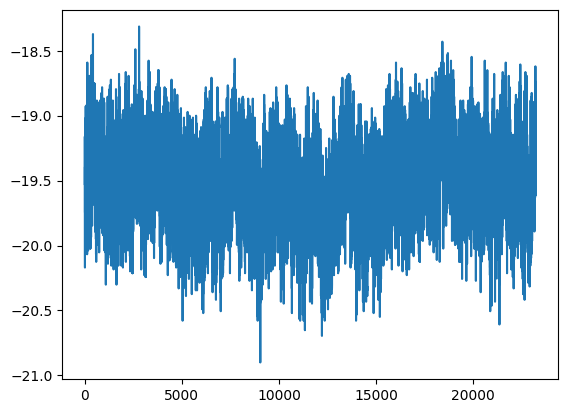

In [132]:
def read_file(file):
    #data = [self.header]
    data=[]
    while True:
        try:
            bin_dat = file.read(20)
            data += [struct.unpack("<dfff", bin_dat)] # magx, magy, magz
        except Exception as e:
            #self.log("got error reading data, returned processed data")
            #self.log(str(e))
            return data
    self.log("process finished running")
    return data

with open('output_12_5/Magnetometer/1691852404', "rb") as f:
    temp = 0
    #dataa=[]
    data = read_file(f)
    time += []
    
    mx = [] # uT
    my = []
    mz = []
    for line in data:
        time += [line[0]]

        mx += [line[1]] 
        my += [line[2]]
        mz += [line[3]]   
        
        
plt.plot(mx)

List of file names in the folder:
1691852536
1691852236
mean dt : 0.011071828370844125  s
mean sampling rate : 94.69576774683429 Hz
total samples 4408
mean dt : 0.011005402406756  s
mean sampling rate : 94.91632617689557 Hz
total samples 27277


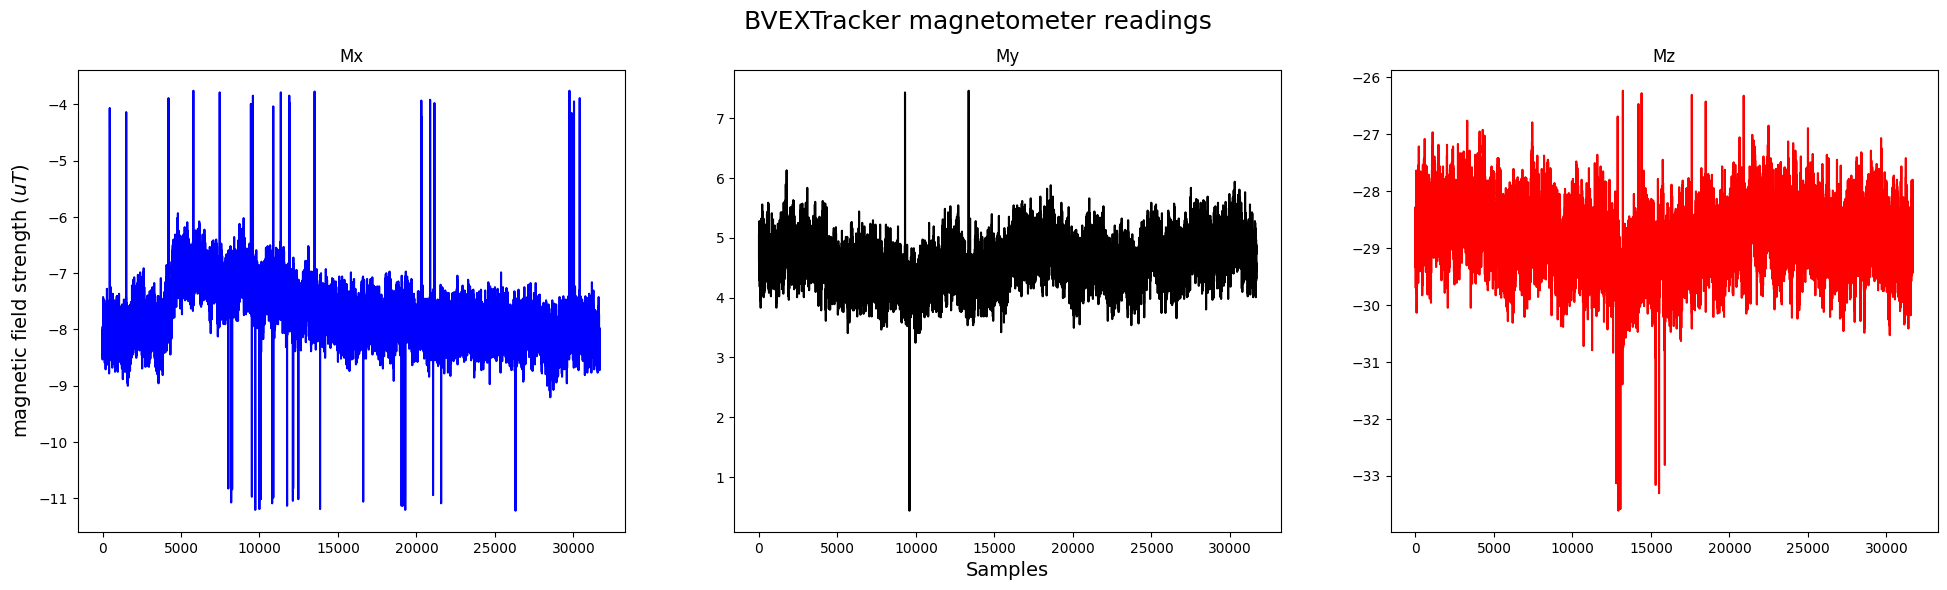

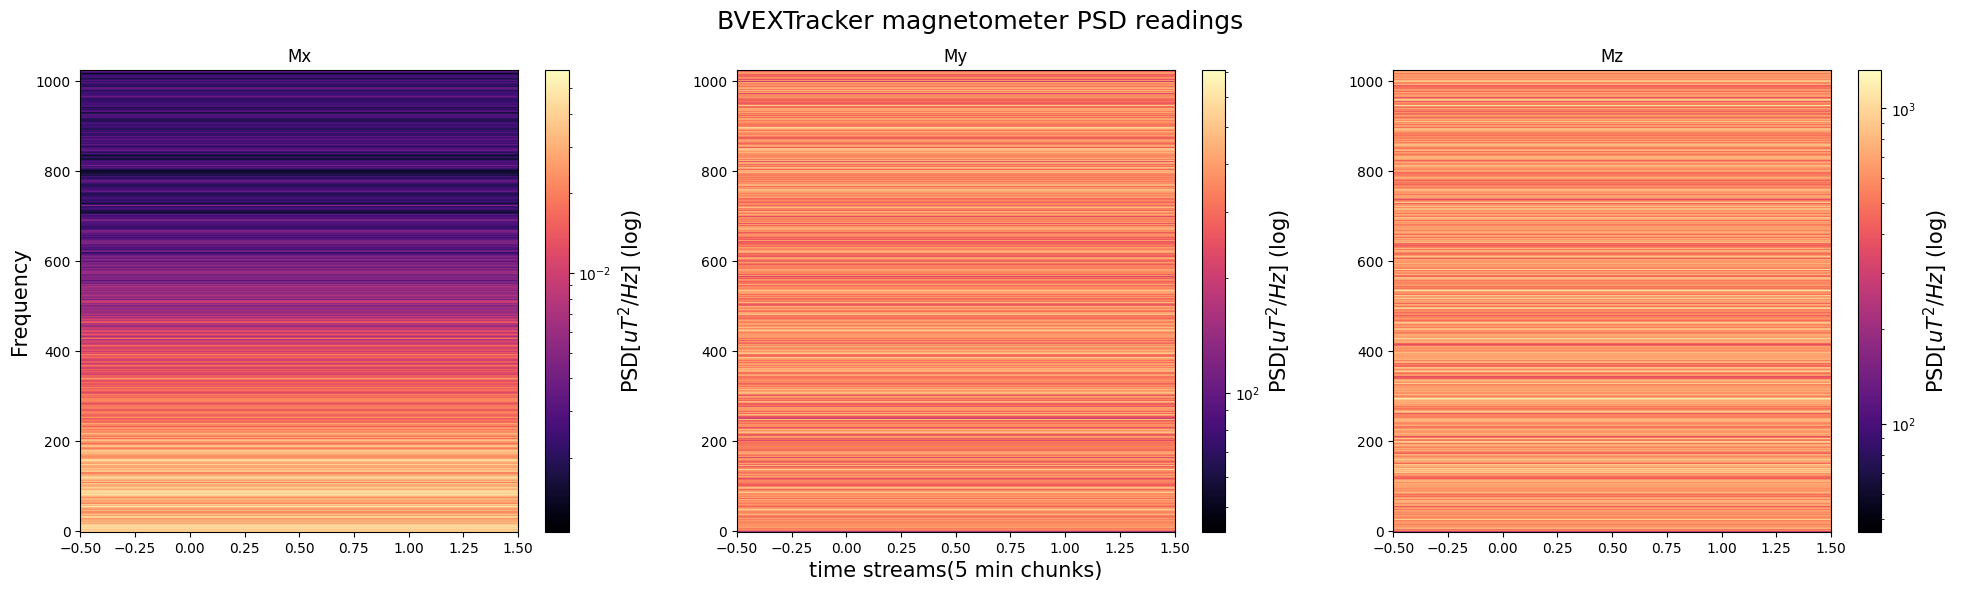

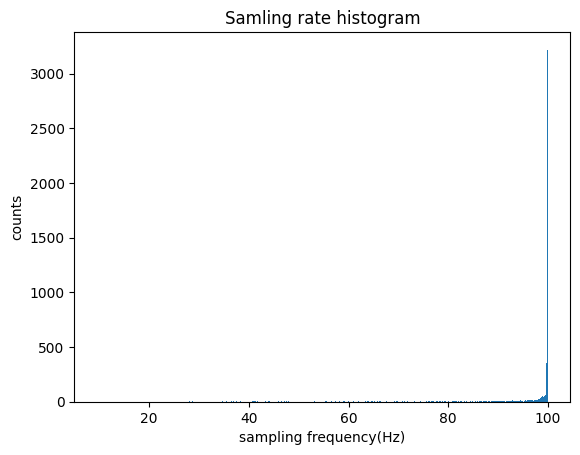

---Magnetometer stats(uT)-------------
RMS mx: 7.739866672287498
RMS my: 4.611938282537421
RMS mz: 28.826965308419165
Std dev mx: 0.47965010714774264
median mx: -7.790119647979736
Std dev my: 0.3534888473955561
median my: 4.603917121887207
Std dev mz: 0.5366629890009126
median mz: -28.82198143005371


In [143]:
def get_file_names_in_folder(folder_path):
    try:
        # Get a list of all file names in the folder
        file_names = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]
        return file_names
    except OSError as e:
        print(f"Error: {e}")
        return []

# Replace 'folder_path' with the actual path of the folder you want to list files from
folder_path = 'output_12_7 /Magnetometer/'
file_names_list = get_file_names_in_folder(folder_path)

if file_names_list:
    print("List of file names in the folder:")
    for file_name in file_names_list:
        print(file_name)
else:
    print("No files found in the folder.")


mxx =[]
myy =[]
mzz =[]

fsslist =[]

psdmx_list =[]
psdmy_list=[]
psdmz_list =[]

fxlist =[]
fylist =[]
fzlist =[]

def read_file(file):
    #data = [self.header]
    data=[]
    while True:
        try:
            bin_dat = file.read(20)
            data += [struct.unpack("<dfff", bin_dat)] # magx, magy, magz
        except Exception as e:
            #self.log("got error reading data, returned processed data")
            #self.log(str(e))
            return data
    self.log("process finished running")
    return data

for i in file_names_list:

    with open(folder_path+'/'+i, "rb") as f:
        temp = 0
    #dataa=[]
        data = read_file(f)
        time = []

        mx = [] # uT
        my = []
        mz = []
        for line in data:
            time += [line[0]]

            mx += [line[1]] 
            my += [line[2]]
            mz += [line[3]]   


    time_span = np.diff(time)
    mean_time_span = np.mean(time_span)
    fss = 1/ time_span
    mean_fss = np.mean(fss)

    print("mean dt :", mean_time_span," s")
    print("mean sampling rate :",mean_fss, "Hz")
    print("total samples",len(time))


    fs= mean_fss # Hz
    win = 2048

    fx,psdax = signal.welch(ax,fs,nperseg=win)
    fy,psday = signal.welch(ay,fs,nperseg=win)
    fz,psdaz = signal.welch(az,fs,nperseg=win)

    
#----------------------------------------appending all dara----------------------------    
    
    fsslist.append(fss)
    
    mxx.append(mx)
    myy.append(my)
    mzz.append(mz)

    psdmx_list.append(psdmx)
    psdmy_list.append(psdmy)
    psdmz_list.append(psdmz)
    
    # ssdax_list.append(Sxx)
    # ssday_list.append(Syy)
    # ssdaz_list.append(Szz)

    fxlist.append(fx)
    fylist.append(fy)
    fzlist.append(fy)
    
#-------------------------------------list flatenning and array mods-----------------------------    
    
def flatten_list(nested_list):
    flattened_list = []
    for item in nested_list:
        if isinstance(item, list):
            flattened_list.extend(flatten_list(item))
        else:
            flattened_list.append(item)
    return flattened_list

mxx = flatten_list(mxx)
myy = flatten_list(myy)
mzz = flatten_list(mzz)

#fsslist = flatten_list(fsslist)

psdmx_list = np.array(psdmx_list)
psdmy_list = np.array(psdmy_list)
psdmz_list = np.array(psdmz_list)

#verr01= flatten_list(verr01)


def flatten_arrays_list(arrays_list):
    flattened_list = np.concatenate(arrays_list).ravel()
    return flattened_list

fsslist = flatten_arrays_list(fsslist)

#-------------------------------plotting data--------------------------------

fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker magnetometer readings',size=18)

axs[0].plot(mxx,color = 'blue')
axs[0].set_title("Mx")


axs[1].plot(myy,color = 'black')
axs[1].set_title("My")

axs[2].plot(mzz,color = 'red')
axs[2].set_title("Mz")

axs[1].set_xlabel('Samples',size=14)
axs[0].set_ylabel(r'magnetic field strength ($uT$)',size=14)


#plt.savefig("imuasd.png",dpi="figure")
plt.show()


fig, axs = plt.subplots(1,3,sharex=True,figsize=(24,6))
fig.suptitle('BVEXTracker magnetometer PSD readings',size=18)

ps1=axs[0].imshow(psdmx_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[0].set_title("Mx")
cb1=fig.colorbar(ps1)
cb1.set_label(label='PSD[$uT^2/Hz$] (log)', size='15')

ps2=axs[1].imshow(psdmy_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[1].set_title("My")
cb2=fig.colorbar(ps2)
cb2.set_label(label='PSD[$uT^2/Hz$] (log)', size='15')

ps3=axs[2].imshow(psdmz_list.T,norm=LogNorm(),origin="lower",cmap='magma',aspect="auto")
axs[2].set_title("Mz")
cb3=fig.colorbar(ps3)
cb3.set_label(label='PSD[$uT^2/Hz$] (log)', size='15')

axs[0].set_ylabel('Frequency',size=15)
axs[1].set_xlabel('time streams(5 min chunks)',size=15)


#plt.savefig("imuasd.png",dpi="figure")
plt.show()


plt.title("Samling rate histogram")
plt.xlabel("sampling frequency(Hz)")
plt.ylabel("counts")
plt.hist(fsslist,bins="auto")
plt.show()


def calculate_rms(accel_data):
    squared_data = np.square(accel_data)
    mean_squared = np.mean(squared_data)
    rms_value = np.sqrt(mean_squared)
    return rms_value

mxx_rms = calculate_rms(mxx)
myy_rms = calculate_rms(myy)
mzz_rms = calculate_rms(mzz)

print("---Magnetometer stats(uT)-------------")

print("RMS mx:",mxx_rms)
print("RMS my:",myy_rms)
print("RMS mz:",mzz_rms)

print("Std dev mx:",np.std(mxx))
print("median mx:",np.median(mxx))
print("Std dev my:",np.std(myy))
print("median my:",np.median(myy))
print("Std dev mz:",np.std(mzz))
print("median mz:",np.median(mzz))